# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing as mp
import wandb
from sklearn.model_selection import train_test_split 

In [2]:
torch.__version__

'2.2.2'

In [3]:
# get the DGD modules (once the current version is public we can switch to the repo)
# git clone https://github.com/Center-for-Health-Data-Science/DeepGenerativeDecoder.git
# for now I added them to this repo, but the imports will stay the same
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD

# get the new stuff
from base.utils.helpers import set_seed, get_activation
from base.model.decoder_debug import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd_all

# Set seeds, device, and directory

In [4]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

datadir = "./data/"

cuda


# Load Data

In [5]:
# tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_transposed.tsv", sep='\t', index_col=[0])
# tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_transposed.tsv", sep='\t', index_col=[0])
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])

In [6]:
def data_filtering(df, filter_zero=True, filter_tumor=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal'])]
        
    return df

tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

In [7]:
# shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

In [8]:
# make data split for train, validation, and test sets
train_ratio= 0.7

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

In [9]:
# Subset the gene, so we don't use all genes when training the model
# Only subset the n most varied genes
is_subset = False
n = 5000

if is_subset:
    # Extract the expression data (excluding the last four columns)
    expression_data = train_mrna.iloc[:, :-4]
    variances = expression_data.var(axis=0)
    top_gene = variances.nlargest(n).index
    selected_columns = expression_data[top_gene].columns

    annot = train_mrna.iloc[:,-4:].columns
    train_mrna = train_mrna[selected_columns.append(annot)]
    val_mrna = val_mrna[selected_columns.append(annot)]
    test_mrna = test_mrna[selected_columns.append(annot)]

In [10]:
# Train, val, and test data loaders
batch_size = 128

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

In [11]:
# Out dimension of mRNA and miRNA
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

In [12]:
print(train_loader.dataset.mrna_data.shape)
print(validation_loader.dataset.mrna_data.shape)
print(test_loader.dataset.mrna_data.shape)

print(train_loader.dataset.mirna_data.shape)
print(validation_loader.dataset.mirna_data.shape)
print(test_loader.dataset.mirna_data.shape)

print(mrna_out_dim)
print(mirna_out_dim)

torch.Size([7473, 19741])
torch.Size([1601, 19741])
torch.Size([1602, 19741])
torch.Size([7473, 2024])
torch.Size([1601, 2024])
torch.Size([1602, 2024])
19741
2024


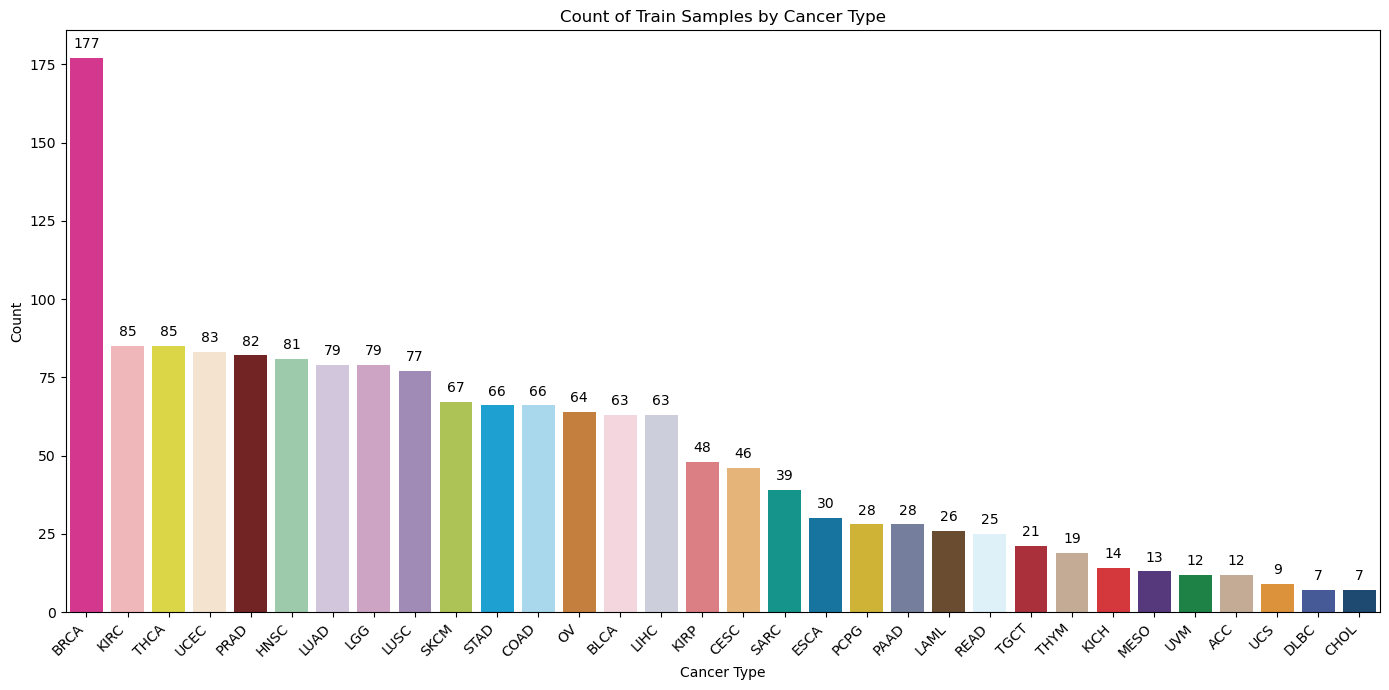

In [13]:
color_mapping = dict(zip(val_mrna['cancer_type'], val_mrna['color']))

primary_site_counts = val_mrna['cancer_type'].value_counts().reset_index()
primary_site_counts.columns = ['cancer_type', 'count']

# Create a bar plot
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
plt.xlabel('Cancer Type')
plt.ylabel('Count')
plt.title('Count of Train Samples by Cancer Type')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels to show them more clearly

# Annotate each bar with the count
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                     (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                     ha='center', va='center',  # Center the text horizontally and vertically
                     xytext=(0, 10),  # Offset the text by 10 points vertically
                     textcoords='offset points')  # Use offset points for the text coordinates

plt.tight_layout()  # Adjust the layout to fit the x labels
plt.show()

# Model Setup

In [14]:
# This one is used for n GMM mixture component 
n_tissues = len(np.unique(train_dataset.label))
# n_tissues = 30

# Hyperparameters for Decoder
latent_dim = 20 # For the representation layer 
hidden_dims = [128, 128] # Decoder common hidden dimension
reduction_type = "sum" # Output loss reduction, you can choose "mean". This is how you want calculate the total loss. 
activation = "relu" # ["relu", "leaky_relu"]
r_init = 2

# Hyperparameters for GMM
gmm_mean = 5.0 # usually between 2 and 10
sd_mean = 0.2 # default 0.2

In [15]:
# Output Module setup
# Set up an output module for the miRNA expression data
mirna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, mirna_out_dim)
    # nn.Linear(hidden_dims[-1], mirna_out_dim)
    )
output_mirna_layer = NB_Module(mirna_out_fc, mirna_out_dim, r_init=r_init, scaling_type="mean")
output_mirna_layer.n_features = mirna_out_dim

# Set up an output module for the mRNA expression data
mrna_out_fc = nn.Sequential(
    nn.Linear(hidden_dims[-1], 128),
    get_activation(activation),
    nn.Linear(128, 512),
    get_activation(activation),
    nn.Linear(512, mrna_out_dim)
    # nn.Linear(hidden_dims[-1], mrna_out_dim)
    )
output_mrna_layer = NB_Module(mrna_out_fc, mrna_out_dim, r_init=r_init, scaling_type="mean")
output_mrna_layer.n_features = mrna_out_dim

# Decoder Setup
decoder = Decoder(latent_dim, 
                  hidden_dims, 
                  output_module_mirna=output_mirna_layer, 
                  output_module_mrna=output_mrna_layer, 
                  activation=activation).to(device)

# GMM init parameter, we will learn this along the way
gmm_mean_scale = gmm_mean # usually between 2 and 10
sd_mean_init = sd_mean * gmm_mean_scale / n_tissues # empirically good for single-cell data at dimensionality 20
gmm_spec={"mean_init": (gmm_mean_scale, 5.0), "sd_init": (sd_mean_init, 1.0), "weight_alpha": 1}

In [16]:
# init a DGD model
dgd = DGD(
        decoder=decoder,
        n_mix=n_tissues,
        rep_dim=latent_dim,
        gmm_spec=gmm_spec
)

In [17]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (out_module_mirna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
)

In [18]:
# Training hyperparameters
learning_rates = {'dec':1e-4,'rep':1e-2,'gmm':1e-2}
weight_decay = 1e-4
betas = (0.5, 0.7)

nepochs = 801
pr = 5 # how often to print epoch
plot = 200 # how often to print plot

sample_mirna = ['MIMAT0000421', 'MIMAT0000422', 'MIMAT0000435', 'MIMAT0000728']
sample_index = [tcga_mirna.columns.get_loc(a) for a in sample_mirna]
subset = 1371
sample_index = [1382, 1310, 34, 360, 
                765, 999, 2000, 93,
                0, 10, 20, 300, 
                123, 345, 456, 567,
                789, 12, 1050, 56,
                1371, 2, 1304, 4]

In [19]:
print("Hyperparameters:")
print(f"Latent dimension: {latent_dim}")
print(f"Learning rates: {learning_rates}")
print(f"Weight decay: {weight_decay}")
print(f"betas: {betas}")
print(f"Number of epochs: {nepochs}")
print(f"Hidden dimensions: {hidden_dims}")
print(f"Batch size: {batch_size}")
print(f"Reduction type: {reduction_type}")

Hyperparameters:
Latent dimension: 20
Learning rates: {'dec': 0.0001, 'rep': 0.01, 'gmm': 0.01}
Weight decay: 0.0001
betas: (0.5, 0.7)
Number of epochs: 801
Hidden dimensions: [128, 128]
Batch size: 128
Reduction type: sum


# Training

  0%|                                                                                                                                                                                            | 0/801 [00:00<?, ?it/s]

0 train_recon_mirna: 14.434858268091876 train_recon_mrna: 10.890671639183331 train_gmm: 7.838458677475892 train_mse: 818099712.0 train_mae: 6203.5595703125 train_r2: -0.01273643970489502 train_spearman: 0.08857481926679611 train_pearson: 0.02931886352598667 train_msle: 44.08382797241211
0 test_recon_mirna: 14.331600355385591 test_recon_mrna: 10.728460483941623 test_gmm: 3.9682312049841895 test_mse: 462989952.0 test_mae: 5026.2265625 test_r2: -0.009978890419006348 test_spearman: 0.061785466969013214 test_pearson: 0.019375205039978027 test_msle: 43.935882568359375


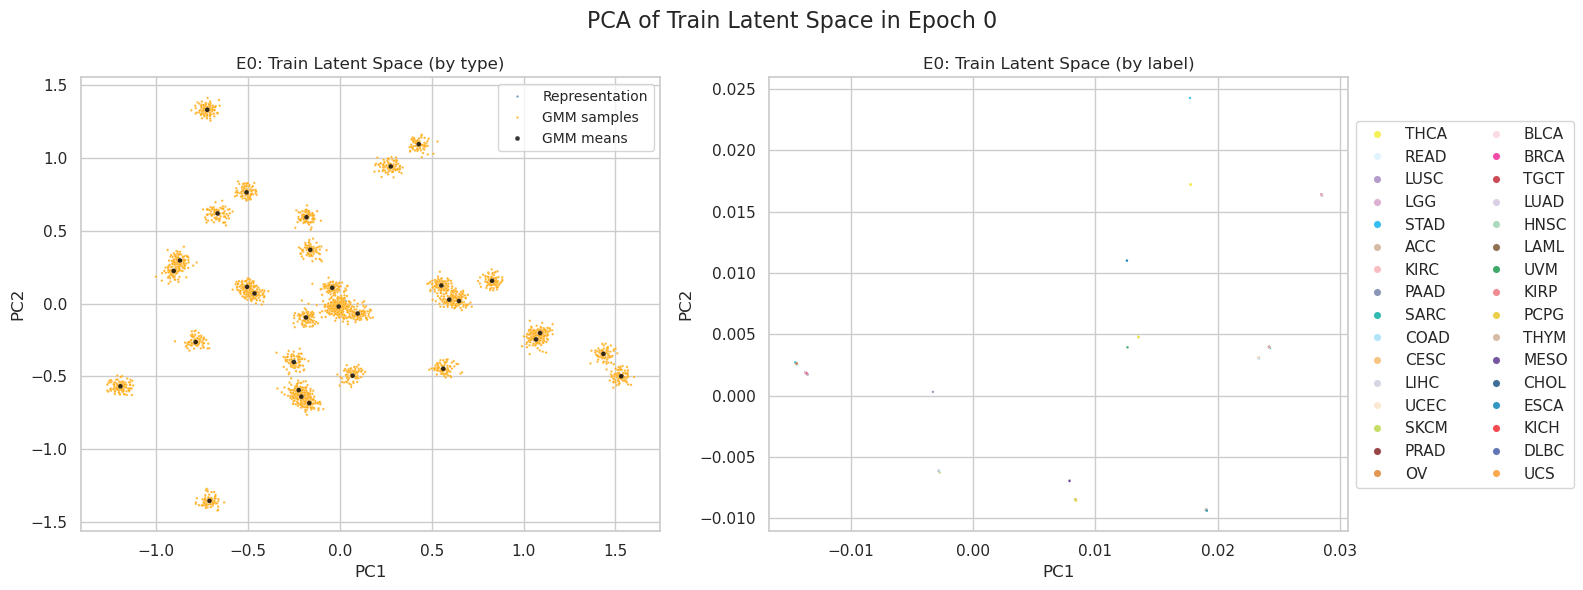

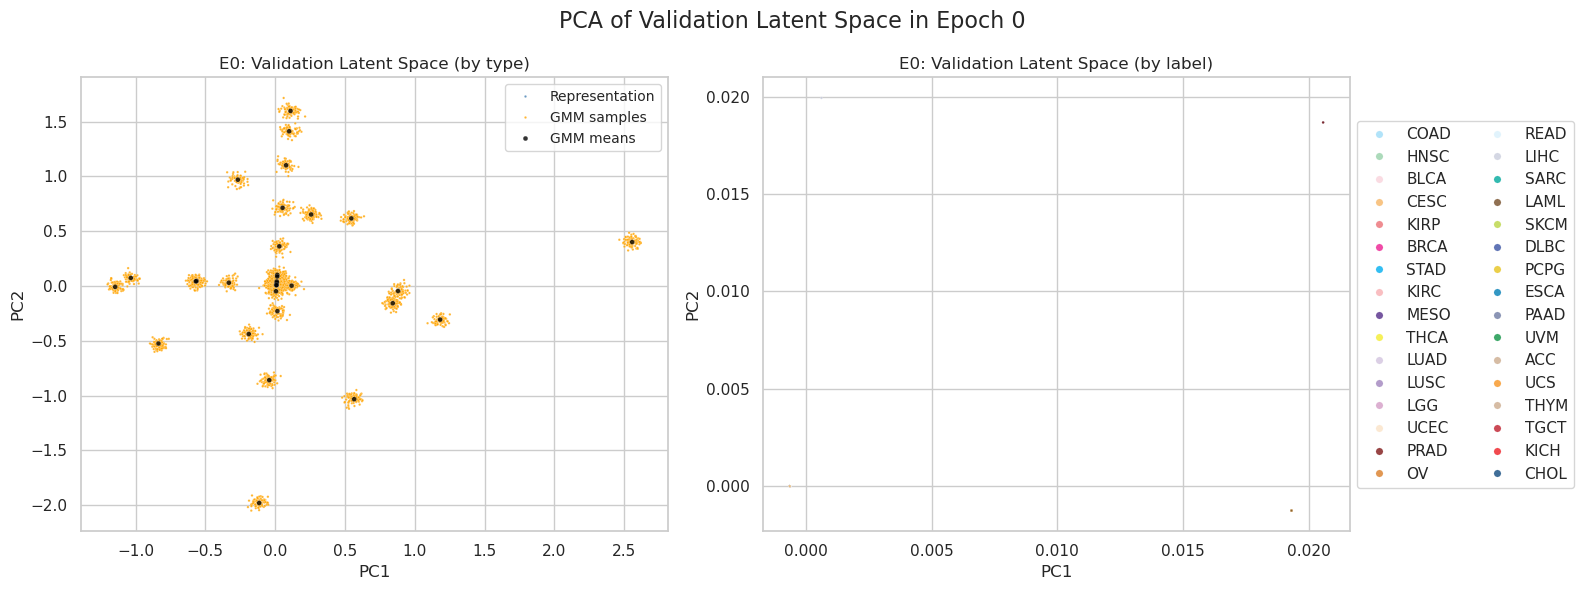

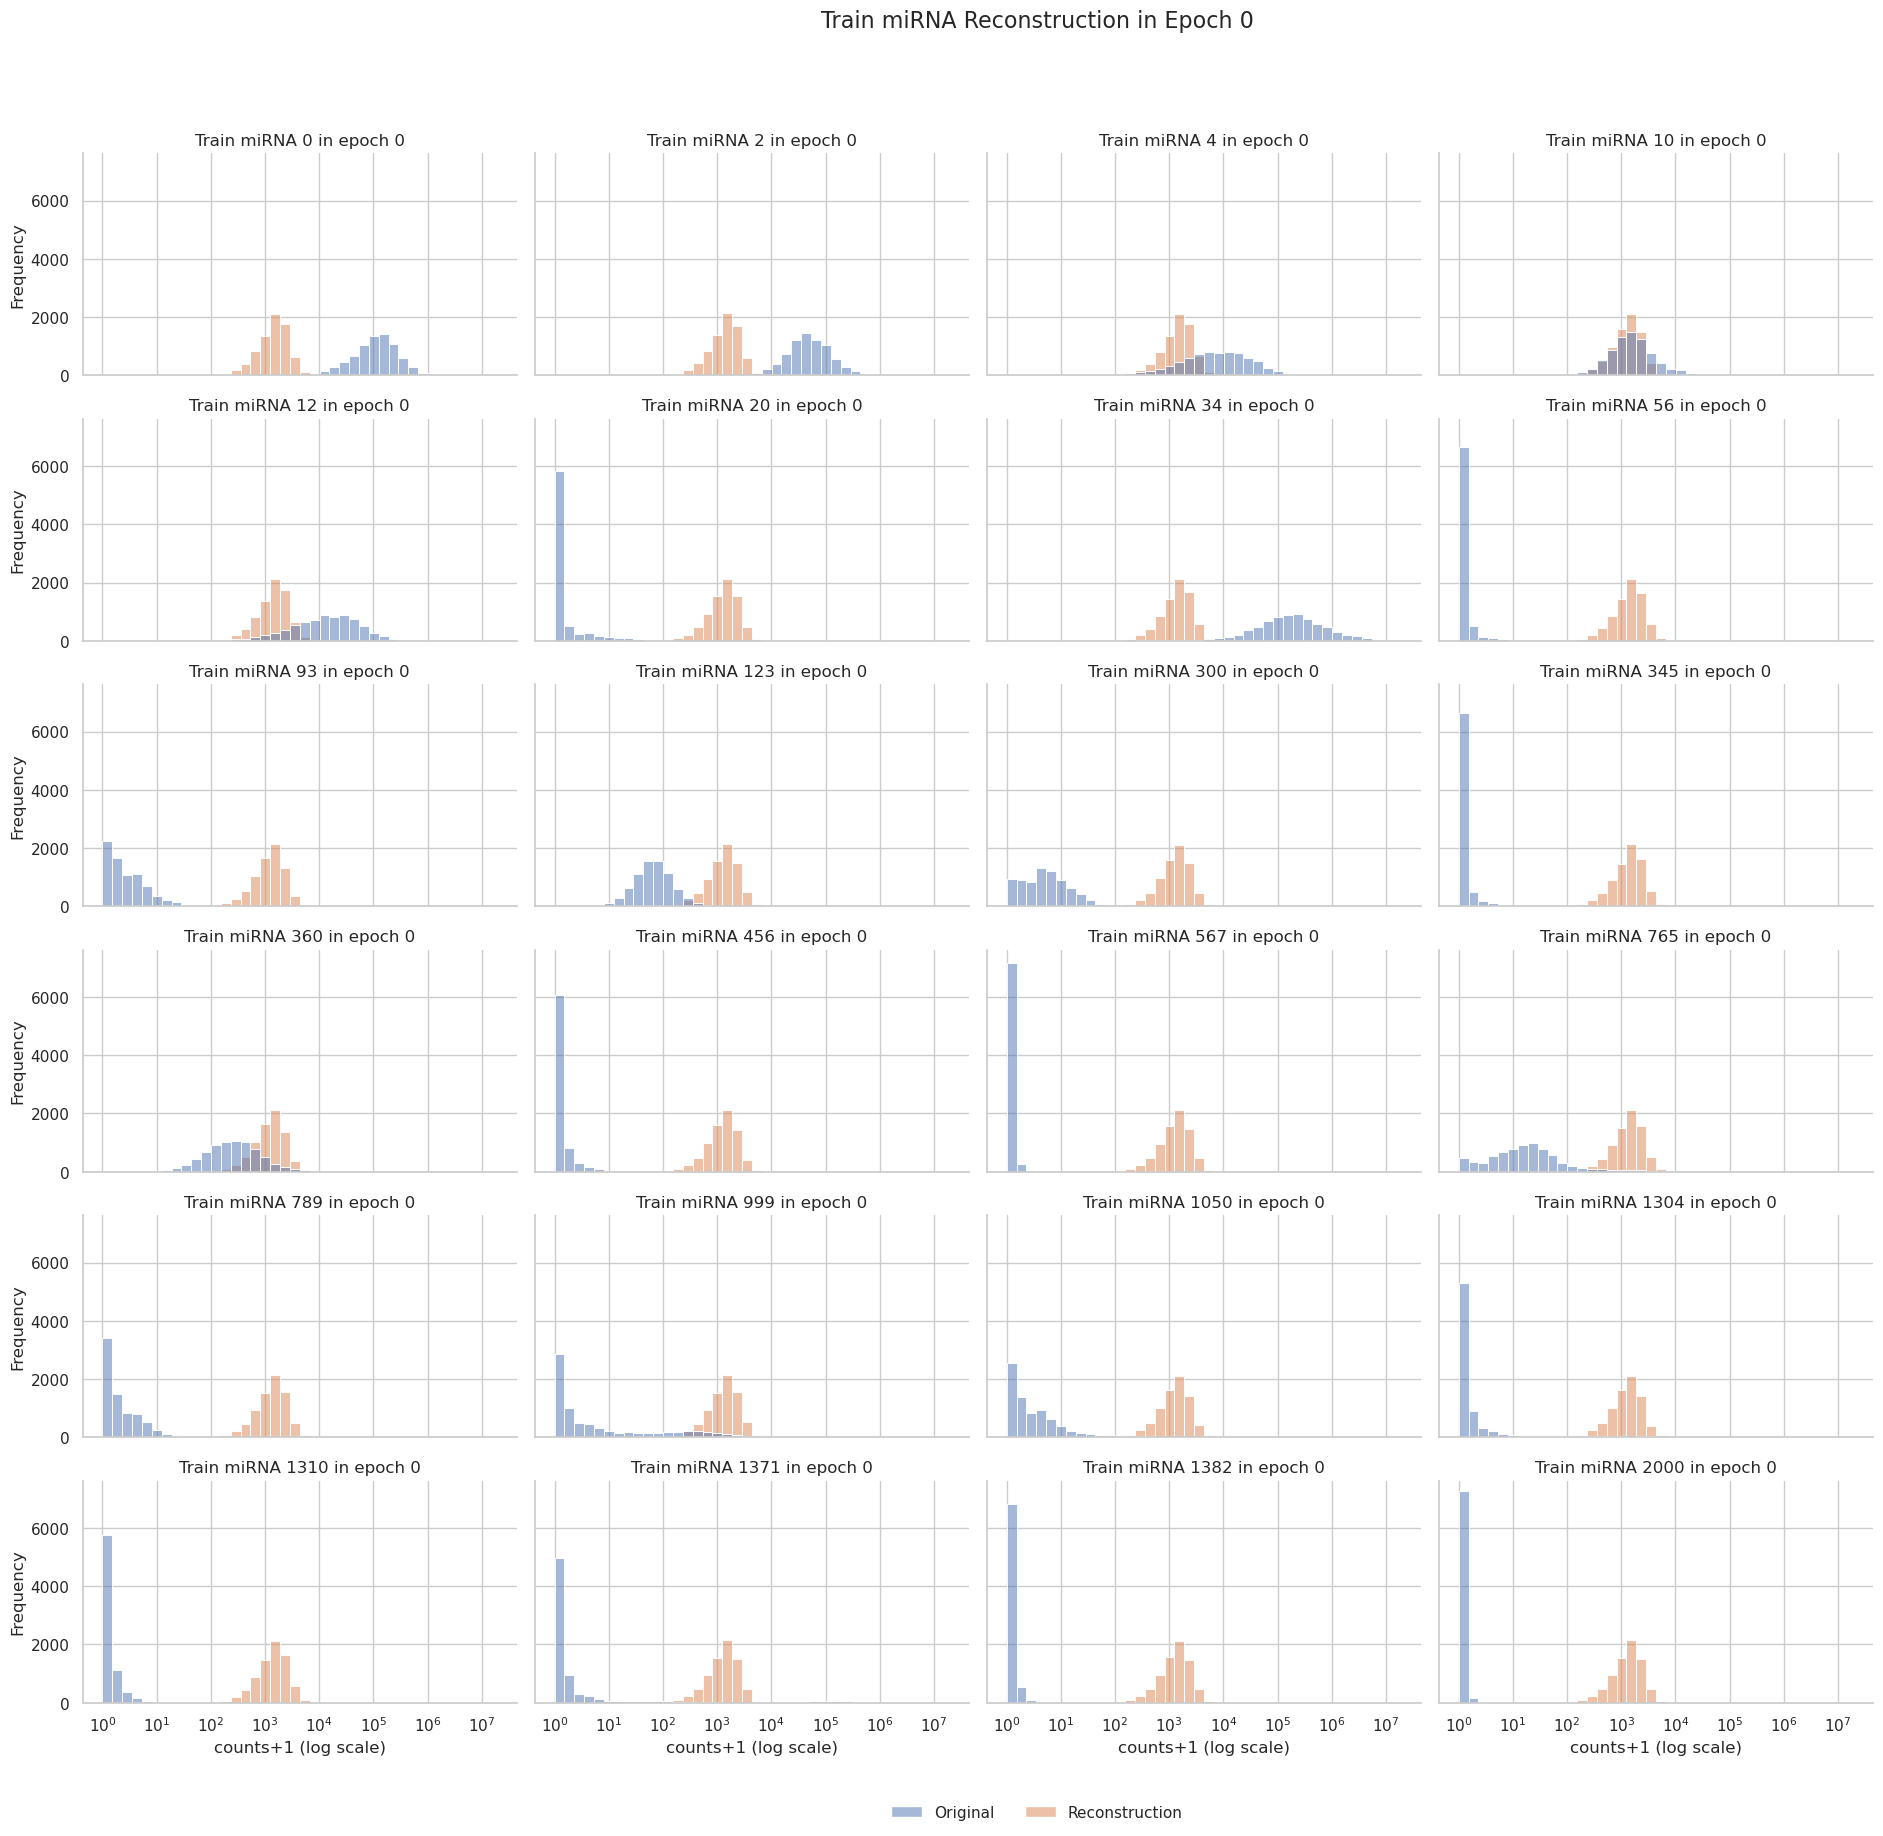

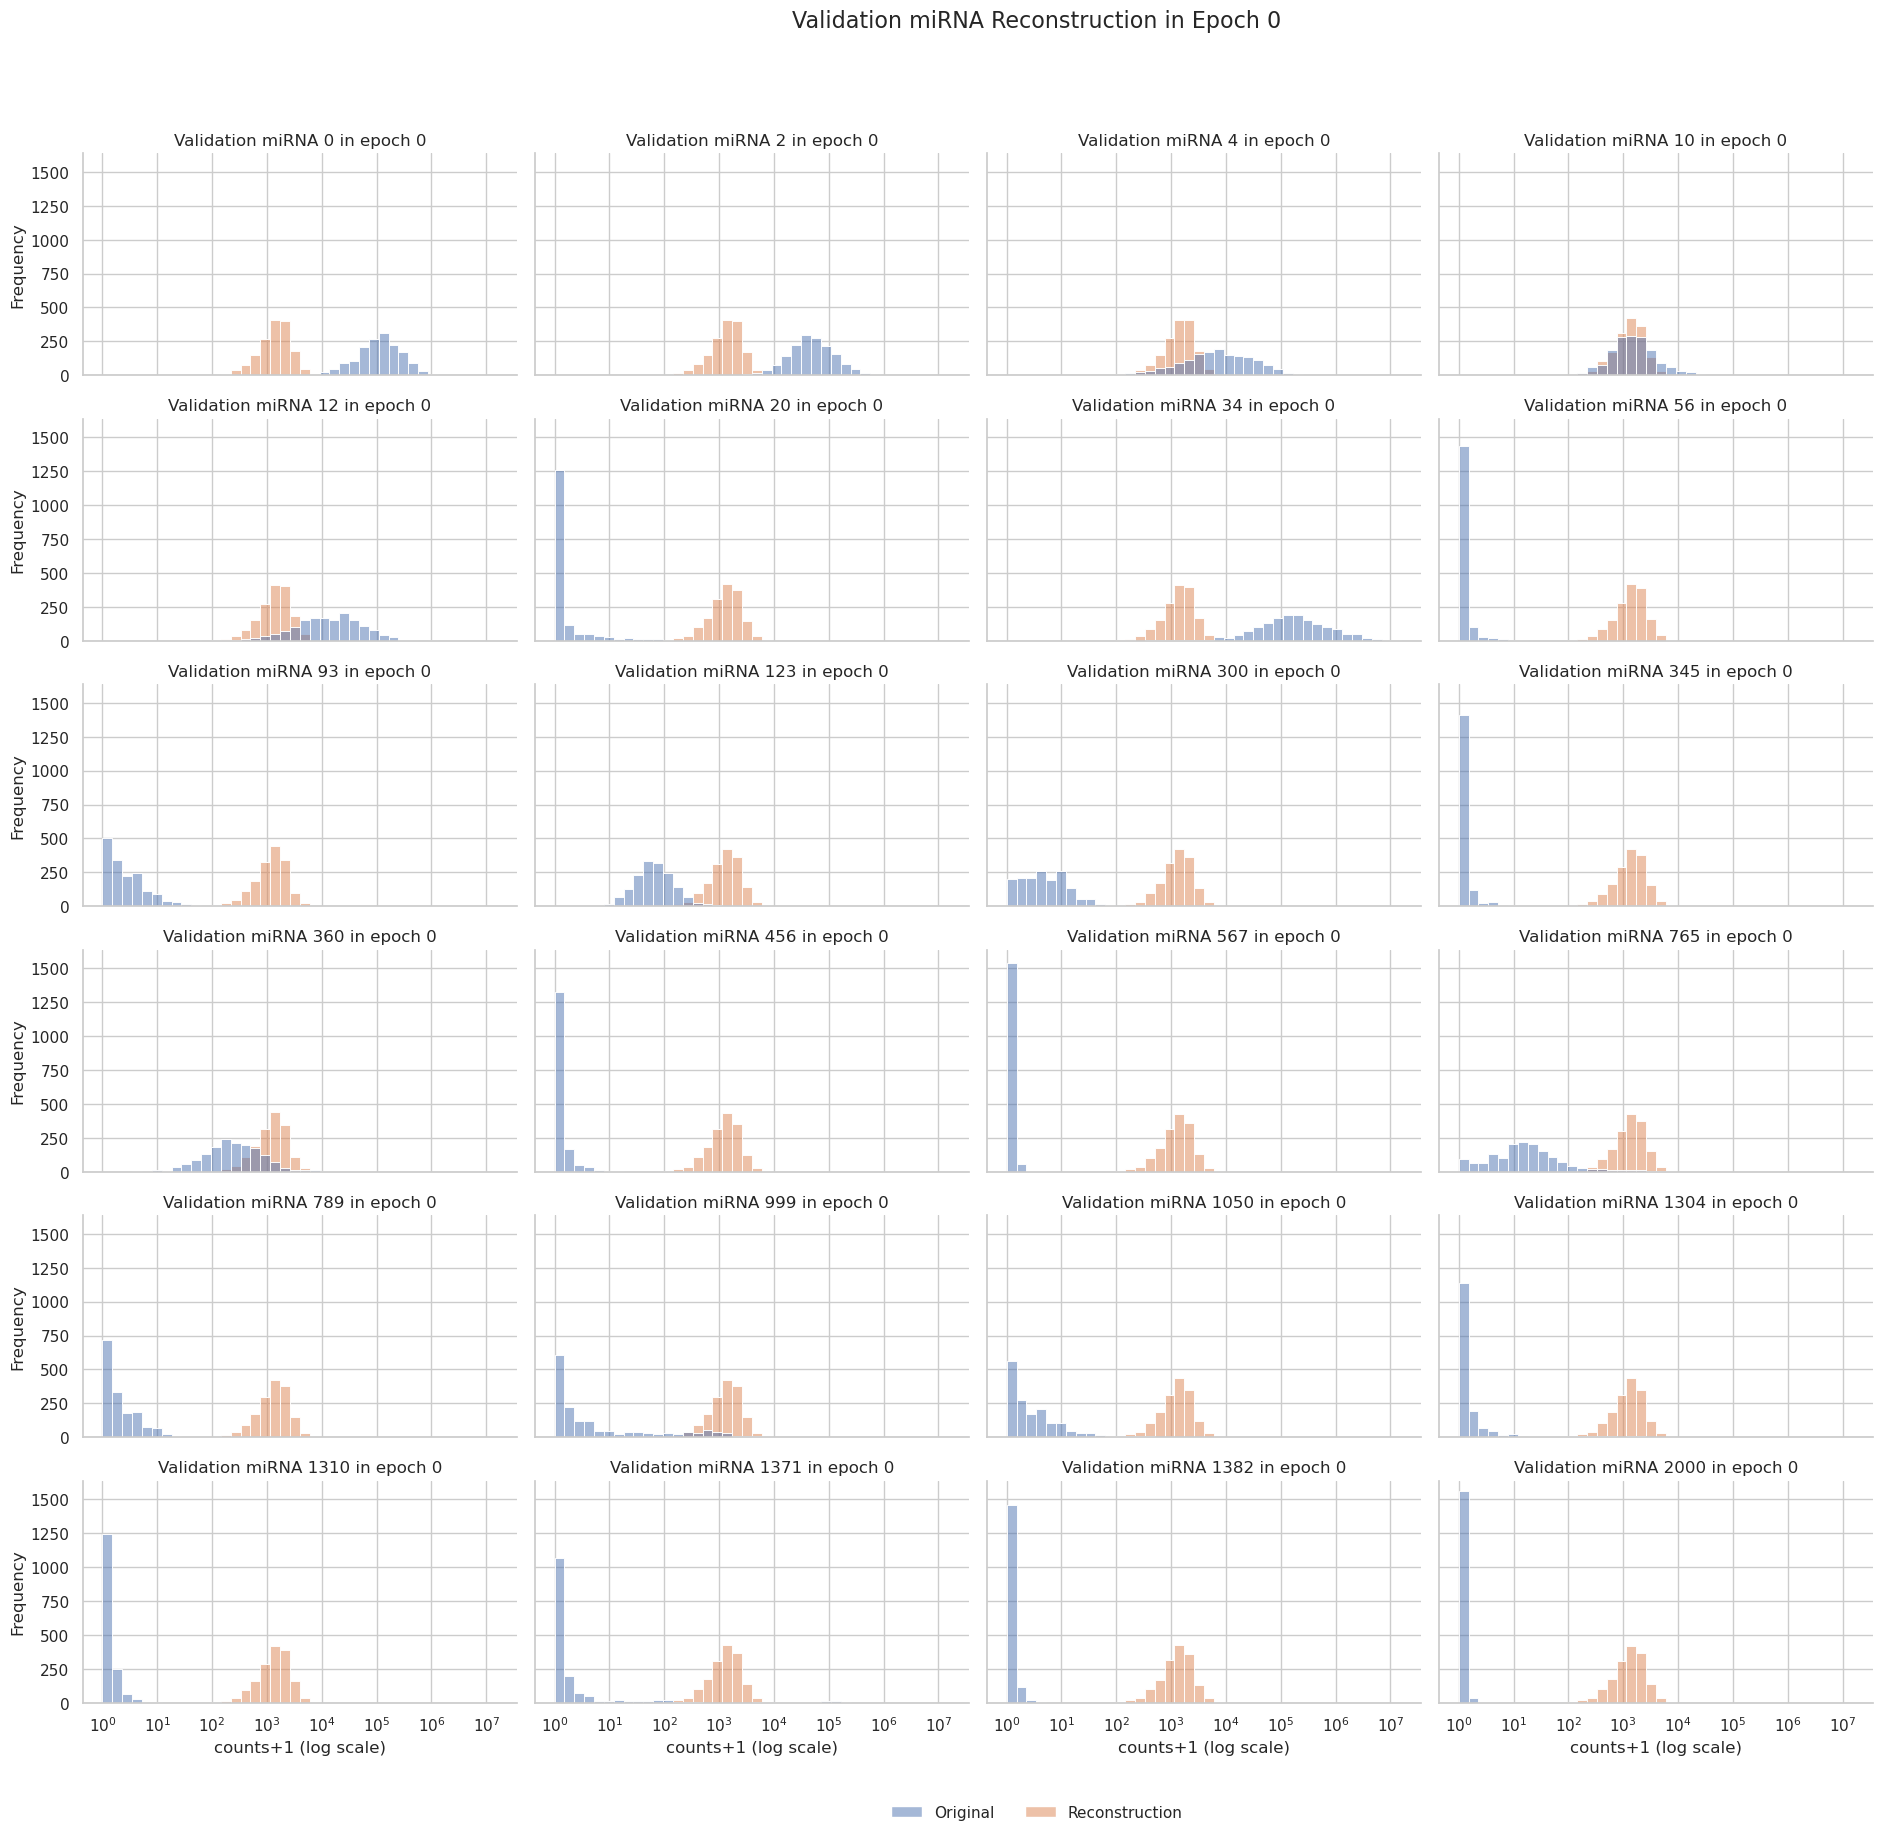

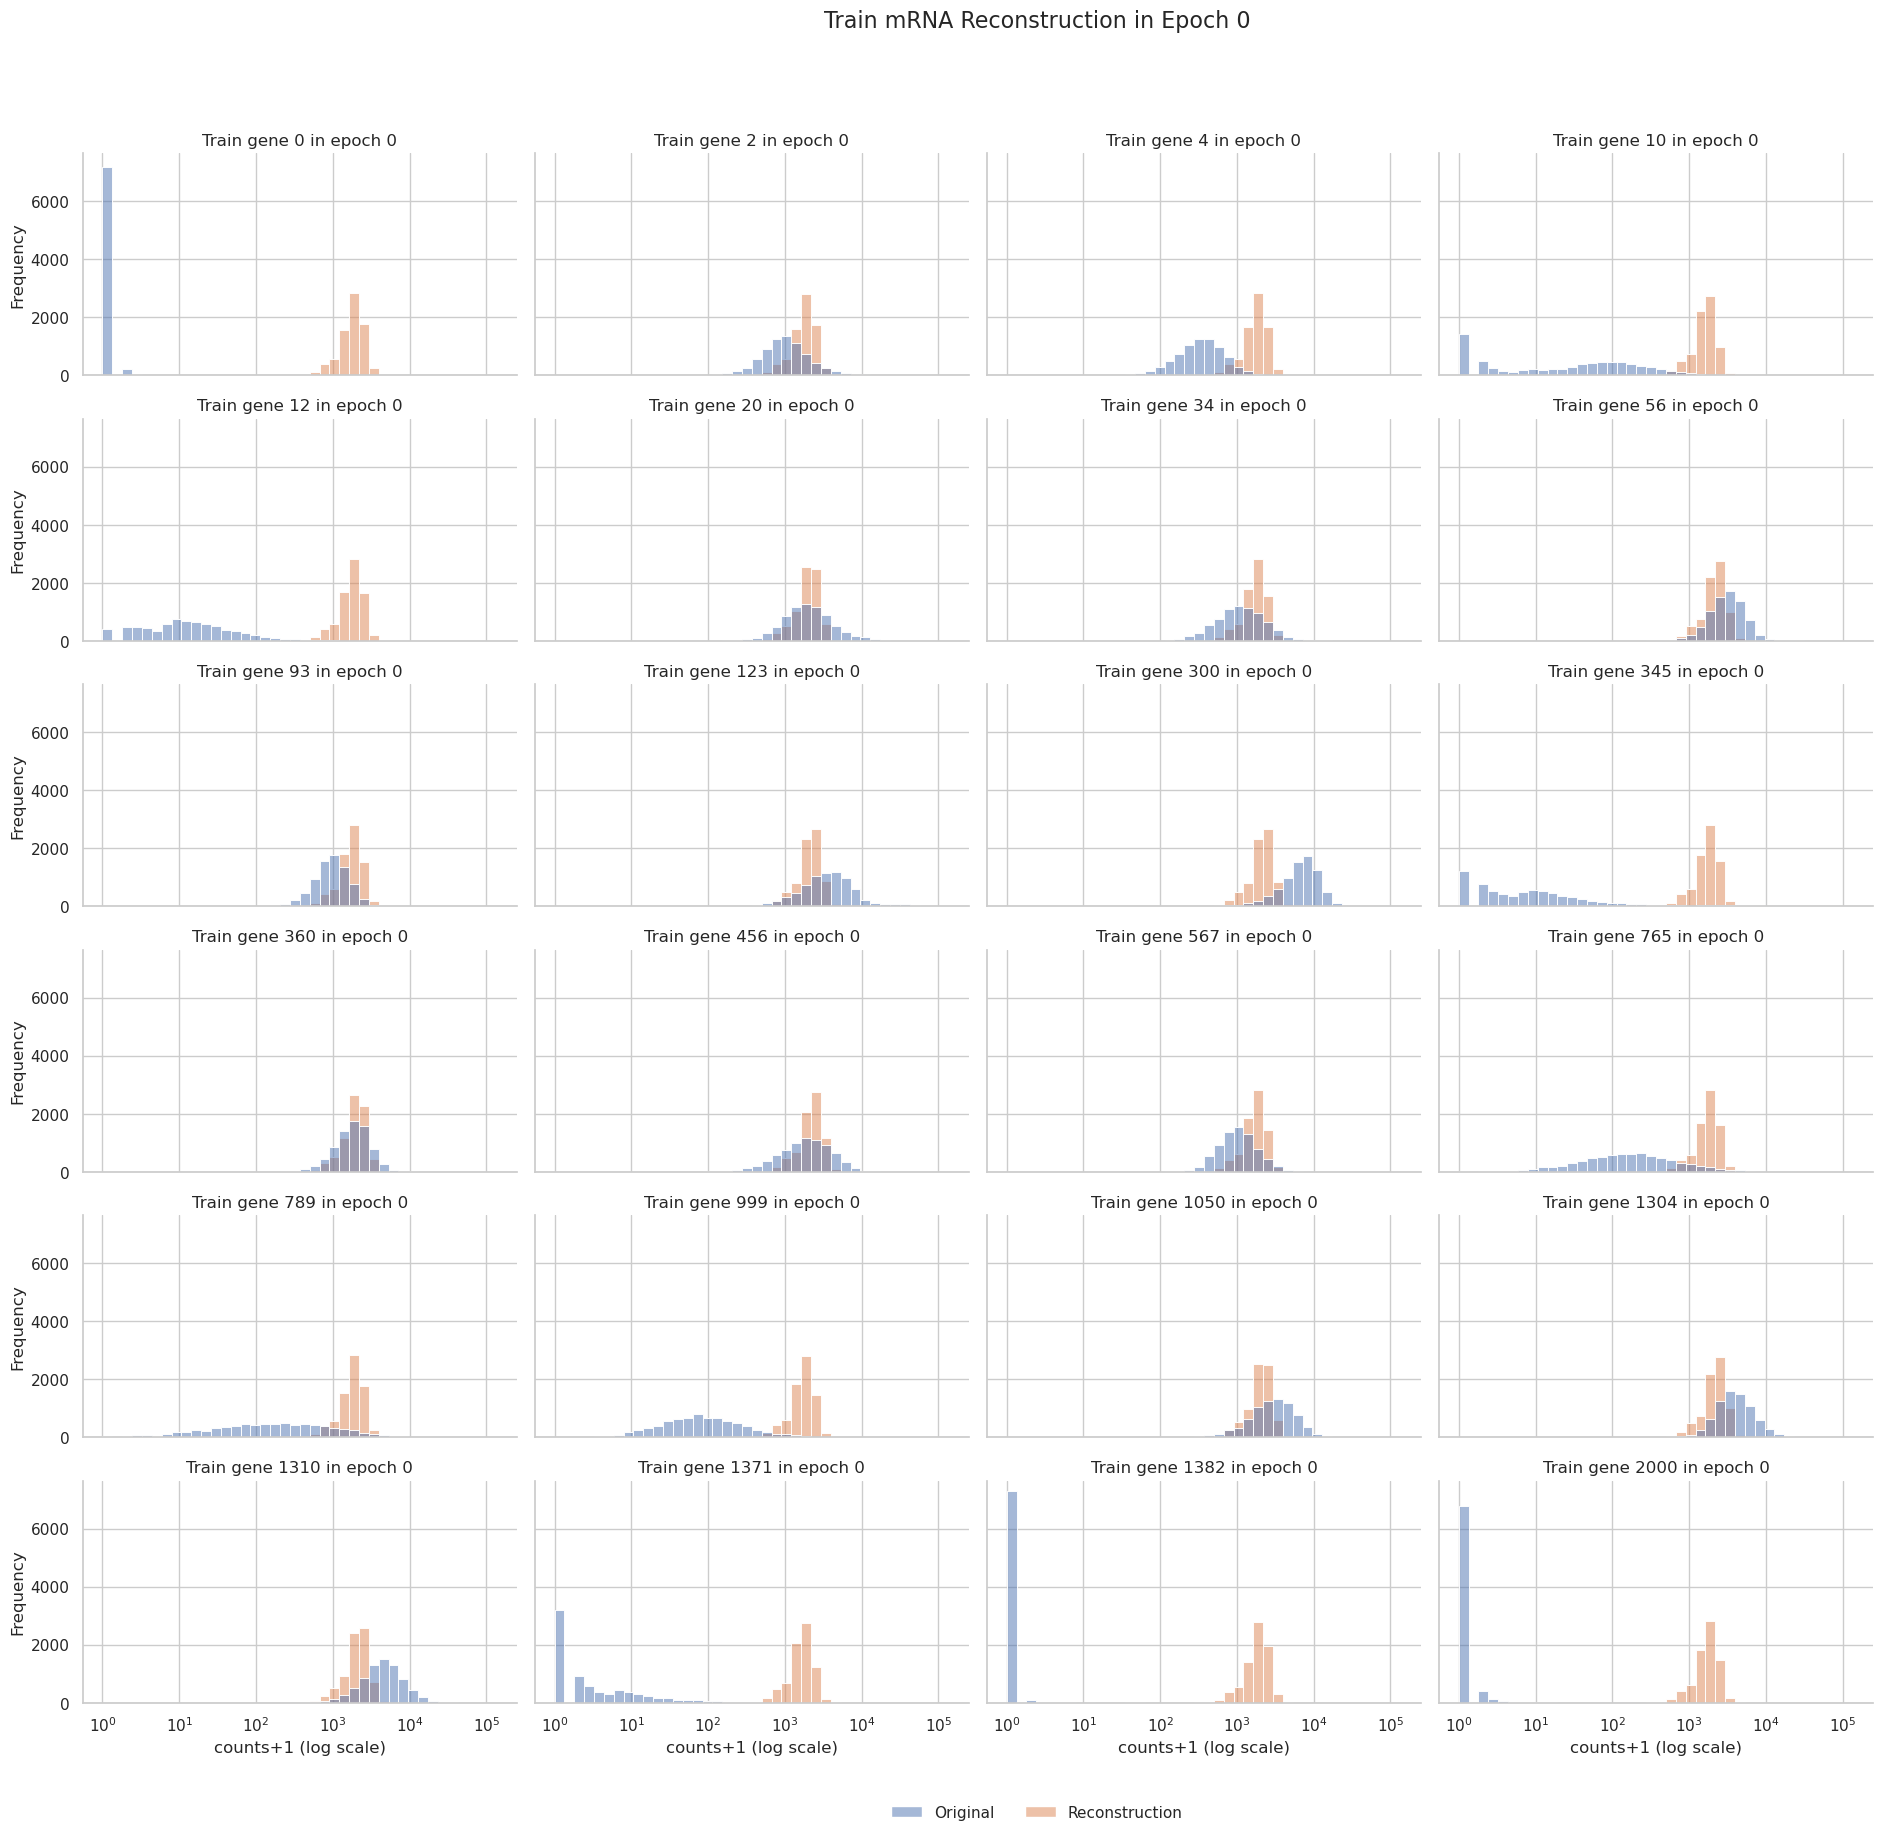

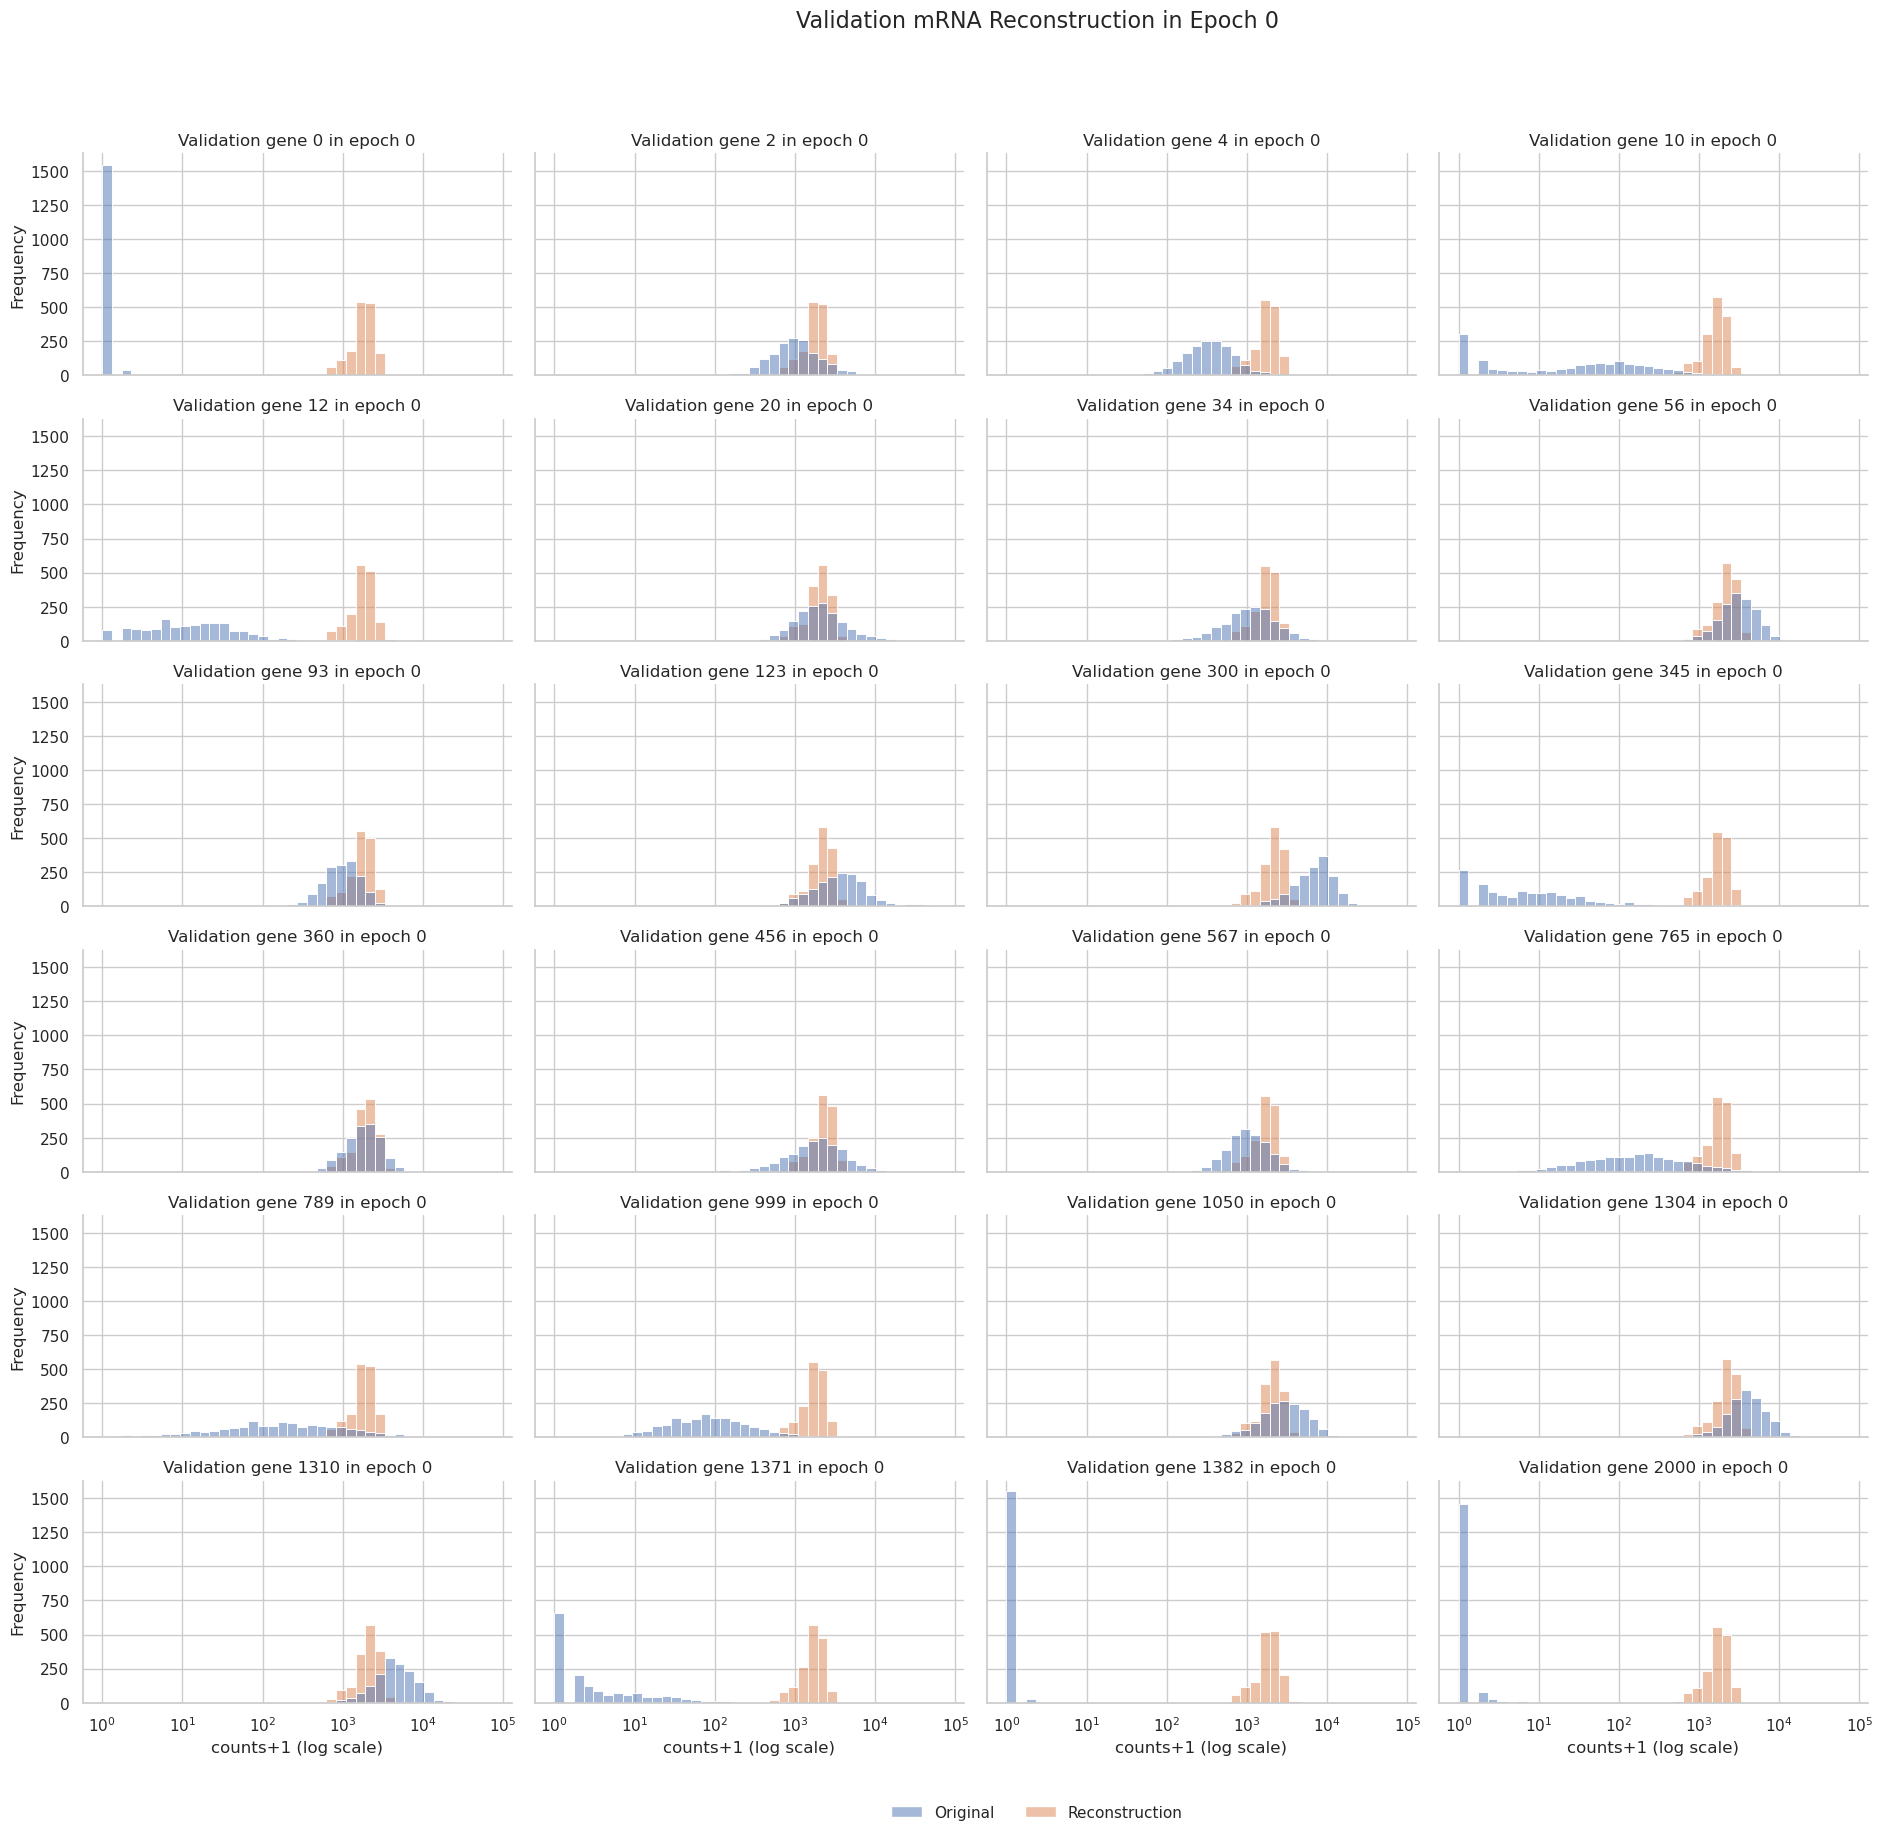

  1%|█▎                                                                                                                                                                                | 6/801 [02:27<2:22:47, 10.78s/it]

5 train_recon_mirna: 10.708104776669 train_recon_mrna: 7.792112324019307 train_gmm: 2.1438781305407804 train_mse: 810668096.0 train_mae: 7786.91455078125 train_r2: -0.003536701202392578 train_spearman: 0.08079442381858826 train_pearson: 0.03118341602385044 train_msle: 54.050846099853516
5 test_recon_mirna: 9.879120371284746 test_recon_mrna: 7.7711166286736155 test_gmm: 2.1451926560792085 test_mse: 460931968.0 test_mae: 6630.548828125 test_r2: -0.005489468574523926 test_spearman: 0.053513310849666595 test_pearson: 0.019826341420412064 test_msle: 53.949886322021484


  1%|██▍                                                                                                                                                                              | 11/801 [02:45<1:00:04,  4.56s/it]

10 train_recon_mirna: 2.7079750110939567 train_recon_mrna: 7.687423806296355 train_gmm: 2.146692142820926 train_mse: 812884608.0 train_mae: 9843.4169921875 train_r2: -0.00628054141998291 train_spearman: 0.06678180396556854 train_pearson: 0.03566914424300194 train_msle: 61.51240158081055
10 test_recon_mirna: 2.639786211233468 test_recon_mrna: 7.694857460958893 test_gmm: 2.1471905376522487 test_mse: 470589856.0 test_mae: 8692.67578125 test_r2: -0.026557445526123047 test_spearman: 0.04604414105415344 test_pearson: 0.023068109527230263 test_msle: 61.35799026489258


  2%|███▌                                                                                                                                                                               | 16/801 [03:04<53:08,  4.06s/it]

15 train_recon_mirna: 2.5437293634967966 train_recon_mrna: 7.662835631639825 train_gmm: 2.147479931660227 train_mse: 810358912.0 train_mae: 9289.5048828125 train_r2: -0.0031540393829345703 train_spearman: 0.06871433556079865 train_pearson: 0.037524498999118805 train_msle: 59.83595657348633
15 test_recon_mirna: 2.548581817533755 test_recon_mrna: 7.669564077793054 test_gmm: 2.1475966330247696 test_mse: 466216832.0 test_mae: 8168.4599609375 test_r2: -0.01701796054840088 test_spearman: 0.04786743223667145 test_pearson: 0.026129864156246185 test_msle: 59.800262451171875


  3%|████▋                                                                                                                                                                              | 21/801 [03:21<47:07,  3.63s/it]

20 train_recon_mirna: 2.5174143168287917 train_recon_mrna: 7.629718341075742 train_gmm: 2.147636950378132 train_mse: 809249216.0 train_mae: 9124.8828125 train_r2: -0.0017802715301513672 train_spearman: 0.07238965481519699 train_pearson: 0.04164436087012291 train_msle: 59.30866622924805
20 test_recon_mirna: 2.5160547084270455 test_recon_mrna: 7.6327926979177345 test_gmm: 2.1477792200187382 test_mse: 464518112.0 test_mae: 7979.69384765625 test_r2: -0.013312458992004395 test_spearman: 0.05116092786192894 test_pearson: 0.030304929241538048 test_msle: 59.203792572021484


  3%|█████▊                                                                                                                                                                             | 26/801 [03:39<45:21,  3.51s/it]

25 train_recon_mirna: 2.4703901312511602 train_recon_mrna: 7.534421873932486 train_gmm: 2.1500587891147713 train_mse: 807489088.0 train_mae: 9100.056640625 train_r2: 0.0003986358642578125 train_spearman: 0.07907041162252426 train_pearson: 0.05255512893199921 train_msle: 59.216217041015625
25 test_recon_mirna: 2.4640751295200873 test_recon_mrna: 7.536290527604179 test_gmm: 2.1514429381904865 test_mse: 463413728.0 test_mae: 7924.8623046875 test_r2: -0.010903239250183105 test_spearman: 0.05630848929286003 test_pearson: 0.03779066726565361 test_msle: 58.99974822998047


  4%|██████▉                                                                                                                                                                            | 31/801 [03:56<45:20,  3.53s/it]

30 train_recon_mirna: 2.45328339094191 train_recon_mrna: 7.441901305161577 train_gmm: 2.152776479701927 train_mse: 805430784.0 train_mae: 8682.99609375 train_r2: 0.002946615219116211 train_spearman: 0.07310579717159271 train_pearson: 0.0640782043337822 train_msle: 57.72679901123047
30 test_recon_mirna: 2.4544356405982675 test_recon_mrna: 7.4442957600109425 test_gmm: 2.153128034602397 test_mse: 460798592.0 test_mae: 7536.41650390625 test_r2: -0.005198478698730469 test_spearman: 0.05342768505215645 test_pearson: 0.04552524909377098 test_msle: 57.613712310791016


  4%|████████                                                                                                                                                                           | 36/801 [04:14<44:36,  3.50s/it]

35 train_recon_mirna: 2.407119037626364 train_recon_mrna: 7.3587555864367555 train_gmm: 2.1544153810488593 train_mse: 796636928.0 train_mae: 7465.458984375 train_r2: 0.013832628726959229 train_spearman: 0.08870697766542435 train_pearson: 0.16736213862895966 train_msle: 52.47462844848633
35 test_recon_mirna: 2.4000438677160765 test_recon_mrna: 7.368051653041807 test_gmm: 2.1550973848132027 test_mse: 450111104.0 test_mae: 6310.86474609375 test_r2: 0.018115460872650146 test_spearman: 0.08621085435152054 test_pearson: 0.14978577196598053 test_msle: 52.39202117919922


  5%|█████████▏                                                                                                                                                                         | 41/801 [04:31<44:13,  3.49s/it]

40 train_recon_mirna: 2.319999621950947 train_recon_mrna: 7.310151508197354 train_gmm: 2.156636756908203 train_mse: 791844672.0 train_mae: 5958.455078125 train_r2: 0.019765019416809082 train_spearman: 0.10084359347820282 train_pearson: 0.3940235376358032 train_msle: 40.38986587524414
40 test_recon_mirna: 2.316174278042009 test_recon_mrna: 7.322119448102142 test_gmm: 2.1570753127317888 test_mse: 443910208.0 test_mae: 4746.70751953125 test_r2: 0.03164219856262207 test_spearman: 0.1205625981092453 test_pearson: 0.3944990932941437 test_msle: 40.08485412597656


  6%|██████████▎                                                                                                                                                                        | 46/801 [04:49<45:21,  3.60s/it]

45 train_recon_mirna: 2.2772665865065487 train_recon_mrna: 7.259532486581737 train_gmm: 2.1581669318792445 train_mse: 788755136.0 train_mae: 5301.0546875 train_r2: 0.023589611053466797 train_spearman: 0.11163566261529922 train_pearson: 0.5901217460632324 train_msle: 28.75069236755371
45 test_recon_mirna: 2.271830206479152 test_recon_mrna: 7.2710466246828345 test_gmm: 2.1585716233262415 test_mse: 441625952.0 test_mae: 4092.943359375 test_r2: 0.03662514686584473 test_spearman: 0.13333921134471893 test_pearson: 0.58842933177948 test_msle: 28.310850143432617


  6%|███████████▍                                                                                                                                                                       | 51/801 [05:07<43:39,  3.49s/it]

50 train_recon_mirna: 2.2582733260521803 train_recon_mrna: 7.185676110068042 train_gmm: 2.1604743727810742 train_mse: 782699456.0 train_mae: 5245.0361328125 train_r2: 0.0310860276222229 train_spearman: 0.11290386319160461 train_pearson: 0.6054388284683228 train_msle: 25.559978485107422
50 test_recon_mirna: 2.2491364266682385 test_recon_mrna: 7.196556240288627 test_gmm: 2.1608039088728725 test_mse: 438012992.0 test_mae: 4017.00048828125 test_r2: 0.04450654983520508 test_spearman: 0.14101393520832062 test_pearson: 0.6038451194763184 test_msle: 24.571407318115234


  7%|████████████▌                                                                                                                                                                      | 56/801 [05:25<44:10,  3.56s/it]

55 train_recon_mirna: 2.232767725422192 train_recon_mrna: 7.108329780872387 train_gmm: 2.1645547947219366 train_mse: 776099008.0 train_mae: 5247.77490234375 train_r2: 0.03925681114196777 train_spearman: 0.1331939548254013 train_pearson: 0.6135743260383606 train_msle: 24.315942764282227
55 test_recon_mirna: 2.2197299547065446 test_recon_mrna: 7.119910492343683 test_gmm: 2.165464669298485 test_mse: 433778080.0 test_mae: 4034.967041015625 test_r2: 0.05374467372894287 test_spearman: 0.16229400038719177 test_pearson: 0.6018319725990295 test_msle: 23.56438446044922


  8%|█████████████▋                                                                                                                                                                     | 61/801 [05:42<43:16,  3.51s/it]

60 train_recon_mirna: 2.200954087713132 train_recon_mrna: 7.049550307554692 train_gmm: 2.168976229465137 train_mse: 774654592.0 train_mae: 5068.30322265625 train_r2: 0.04104489088058472 train_spearman: 0.1435229480266571 train_pearson: 0.7059511542320251 train_msle: 20.358983993530273
60 test_recon_mirna: 2.188912826299892 test_recon_mrna: 7.062204233138949 test_gmm: 2.170086528866236 test_mse: 431935584.0 test_mae: 3841.208984375 test_r2: 0.05776399374008179 test_spearman: 0.16910670697689056 test_pearson: 0.7200914025306702 test_msle: 19.381858825683594


  8%|██████████████▋                                                                                                                                                                    | 66/801 [06:00<42:58,  3.51s/it]

65 train_recon_mirna: 2.177289458701523 train_recon_mrna: 6.997370128226775 train_gmm: 2.172610499360197 train_mse: 768058304.0 train_mae: 4931.15625 train_r2: 0.04921048879623413 train_spearman: 0.14252151548862457 train_pearson: 0.7846380472183228 train_msle: 17.231964111328125
65 test_recon_mirna: 2.168503662637976 test_recon_mrna: 7.011298691572415 test_gmm: 2.173128031552545 test_mse: 428610016.0 test_mae: 3713.42919921875 test_r2: 0.06501853466033936 test_spearman: 0.15961147844791412 test_pearson: 0.7978140711784363 test_msle: 16.18482780456543


  9%|███████████████▊                                                                                                                                                                   | 71/801 [06:18<43:08,  3.55s/it]

70 train_recon_mirna: 2.1588615890145895 train_recon_mrna: 6.9495030225252155 train_gmm: 2.1752790873969206 train_mse: 759302848.0 train_mae: 4865.5283203125 train_r2: 0.06004899740219116 train_spearman: 0.14358486235141754 train_pearson: 0.8033053278923035 train_msle: 15.742996215820312
70 test_recon_mirna: 2.1518912436304634 test_recon_mrna: 6.965161173233347 test_gmm: 2.175505284172978 test_mse: 421321152.0 test_mae: 3673.3349609375 test_r2: 0.08091866970062256 test_spearman: 0.1571420133113861 test_pearson: 0.8079517483711243 test_msle: 15.296724319458008


  9%|████████████████▉                                                                                                                                                                  | 76/801 [06:35<42:11,  3.49s/it]

75 train_recon_mirna: 2.140651678098136 train_recon_mrna: 6.906657947300995 train_gmm: 2.177115339832773 train_mse: 752007872.0 train_mae: 4826.02880859375 train_r2: 0.06907957792282104 train_spearman: 0.16120272874832153 train_pearson: 0.8040525317192078 train_msle: 14.912599563598633
75 test_recon_mirna: 2.135793089885768 test_recon_mrna: 6.9226670897175255 test_gmm: 2.177129497921221 test_mse: 415755328.0 test_mae: 3631.360595703125 test_r2: 0.09306007623672485 test_spearman: 0.16957150399684906 test_pearson: 0.8095090985298157 test_msle: 14.364470481872559


 10%|██████████████████                                                                                                                                                                 | 81/801 [06:53<42:31,  3.54s/it]

80 train_recon_mirna: 2.1217750771188664 train_recon_mrna: 6.8678379053978516 train_gmm: 2.1792711737515473 train_mse: 744540416.0 train_mae: 4769.01806640625 train_r2: 0.0783236026763916 train_spearman: 0.19504062831401825 train_pearson: 0.8077406287193298 train_msle: 13.693747520446777
80 test_recon_mirna: 2.1164162081875704 test_recon_mrna: 6.886414546199644 test_gmm: 2.178836698133003 test_mse: 411711424.0 test_mae: 3570.118408203125 test_r2: 0.10188156366348267 test_spearman: 0.20091252028942108 test_pearson: 0.8071975708007812 test_msle: 12.728793144226074


 11%|███████████████████▏                                                                                                                                                               | 86/801 [07:10<41:03,  3.45s/it]

85 train_recon_mirna: 2.10234658299192 train_recon_mrna: 6.834577740253613 train_gmm: 2.182071507230718 train_mse: 738306368.0 train_mae: 4705.236328125 train_r2: 0.08604085445404053 train_spearman: 0.22866570949554443 train_pearson: 0.8094968199729919 train_msle: 12.161964416503906
85 test_recon_mirna: 2.098259074275465 test_recon_mrna: 6.855620415549384 test_gmm: 2.183246829374219 test_mse: 405714016.0 test_mae: 3518.206787109375 test_r2: 0.11496442556381226 test_spearman: 0.2330390214920044 test_pearson: 0.8043942451477051 test_msle: 11.412325859069824


 11%|████████████████████▎                                                                                                                                                              | 91/801 [07:28<41:35,  3.51s/it]

90 train_recon_mirna: 2.0840638245972722 train_recon_mrna: 6.806196392079788 train_gmm: 2.1850852603879174 train_mse: 736776576.0 train_mae: 4641.02099609375 train_r2: 0.08793455362319946 train_spearman: 0.2609265446662903 train_pearson: 0.8168136477470398 train_msle: 10.057120323181152
90 test_recon_mirna: 2.0785648729919295 test_recon_mrna: 6.826170045119905 test_gmm: 2.1851740840075538 test_mse: 407157248.0 test_mae: 3483.09228515625 test_r2: 0.11181610822677612 test_spearman: 0.2602941393852234 test_pearson: 0.8054897785186768 test_msle: 9.628805160522461


 12%|█████████████████████▍                                                                                                                                                             | 96/801 [07:45<41:11,  3.51s/it]

95 train_recon_mirna: 2.0677042383873117 train_recon_mrna: 6.781528817048705 train_gmm: 2.187662391249122 train_mse: 731345472.0 train_mae: 4605.7734375 train_r2: 0.09465783834457397 train_spearman: 0.2868894338607788 train_pearson: 0.8133963346481323 train_msle: 9.344674110412598
95 test_recon_mirna: 2.062291308174486 test_recon_mrna: 6.805228647904795 test_gmm: 2.188280136804146 test_mse: 403628096.0 test_mae: 3458.212158203125 test_r2: 0.11951470375061035 test_spearman: 0.28151845932006836 test_pearson: 0.7948973774909973 test_msle: 8.844063758850098


 13%|██████████████████████▍                                                                                                                                                           | 101/801 [08:03<40:44,  3.49s/it]

100 train_recon_mirna: 2.0536651663544756 train_recon_mrna: 6.760088685747932 train_gmm: 2.1903300285977436 train_mse: 728291008.0 train_mae: 4568.31689453125 train_r2: 0.09843897819519043 train_spearman: 0.30764448642730713 train_pearson: 0.8192142844200134 train_msle: 8.343585014343262
100 test_recon_mirna: 2.048595704605323 test_recon_mrna: 6.781358157154514 test_gmm: 2.190658090890459 test_mse: 399767488.0 test_mae: 3423.87646484375 test_r2: 0.12793636322021484 test_spearman: 0.30224141478538513 test_pearson: 0.7965389490127563 test_msle: 8.058308601379395


 13%|███████████████████████▌                                                                                                                                                          | 106/801 [08:21<41:09,  3.55s/it]

105 train_recon_mirna: 2.040339558089293 train_recon_mrna: 6.741315220110602 train_gmm: 2.19275091991325 train_mse: 722698432.0 train_mae: 4541.48974609375 train_r2: 0.10536205768585205 train_spearman: 0.31981727480888367 train_pearson: 0.8235947489738464 train_msle: 8.028404235839844
105 test_recon_mirna: 2.035646106805776 test_recon_mrna: 6.766408626946945 test_gmm: 2.1937297947327843 test_mse: 398112320.0 test_mae: 3407.7060546875 test_r2: 0.13154703378677368 test_spearman: 0.31251659989356995 test_pearson: 0.7991178631782532 test_msle: 7.6445817947387695


 14%|████████████████████████▋                                                                                                                                                         | 111/801 [08:38<39:58,  3.48s/it]

110 train_recon_mirna: 2.0282450120830244 train_recon_mrna: 6.72416160413444 train_gmm: 2.1952746799284717 train_mse: 718611584.0 train_mae: 4518.69921875 train_r2: 0.11042129993438721 train_spearman: 0.3316801190376282 train_pearson: 0.8242189884185791 train_msle: 7.710792064666748
110 test_recon_mirna: 2.023886303150452 test_recon_mrna: 6.749024824633279 test_gmm: 2.1955958845911736 test_mse: 395018976.0 test_mae: 3388.186279296875 test_r2: 0.13829487562179565 test_spearman: 0.32280081510543823 test_pearson: 0.8016480803489685 test_msle: 7.475208759307861


 14%|█████████████████████████▊                                                                                                                                                        | 116/801 [08:56<40:21,  3.53s/it]

115 train_recon_mirna: 2.0172067348829303 train_recon_mrna: 6.7084943921820495 train_gmm: 2.1978453340227944 train_mse: 714701248.0 train_mae: 4496.673828125 train_r2: 0.11526191234588623 train_spearman: 0.33735665678977966 train_pearson: 0.8289415836334229 train_msle: 7.415663719177246
115 test_recon_mirna: 2.0129901114020883 test_recon_mrna: 6.730623409505374 test_gmm: 2.1981274978285055 test_mse: 395121568.0 test_mae: 3378.496826171875 test_r2: 0.13807111978530884 test_spearman: 0.32806506752967834 test_pearson: 0.7965807914733887 test_msle: 7.086840629577637


 15%|██████████████████████████▉                                                                                                                                                       | 121/801 [09:13<39:43,  3.50s/it]

120 train_recon_mirna: 2.0071524006928896 train_recon_mrna: 6.694222558690644 train_gmm: 2.200185162026002 train_mse: 710342336.0 train_mae: 4473.52294921875 train_r2: 0.12065780162811279 train_spearman: 0.3434887230396271 train_pearson: 0.8323701024055481 train_msle: 7.12602424621582
120 test_recon_mirna: 2.002991824912419 test_recon_mrna: 6.7183971848302475 test_gmm: 2.200578251873829 test_mse: 389704672.0 test_mae: 3347.028564453125 test_r2: 0.14988768100738525 test_spearman: 0.3338133692741394 test_pearson: 0.8001160621643066 test_msle: 6.838968276977539


 16%|████████████████████████████                                                                                                                                                      | 126/801 [09:31<39:15,  3.49s/it]

125 train_recon_mirna: 1.9978717964299277 train_recon_mrna: 6.680904743051718 train_gmm: 2.202396730443137 train_mse: 707390272.0 train_mae: 4448.1376953125 train_r2: 0.12431228160858154 train_spearman: 0.3497559726238251 train_pearson: 0.8369972705841064 train_msle: 6.517706871032715
125 test_recon_mirna: 1.9940032924703681 test_recon_mrna: 6.704457705423903 test_gmm: 2.202694673556078 test_mse: 387348640.0 test_mae: 3326.509765625 test_r2: 0.15502715110778809 test_spearman: 0.33771809935569763 test_pearson: 0.8015503287315369 test_msle: 6.356194496154785


 16%|█████████████████████████████                                                                                                                                                     | 131/801 [09:48<39:09,  3.51s/it]

130 train_recon_mirna: 1.9897721925744274 train_recon_mrna: 6.668376047223561 train_gmm: 2.20385858328263 train_mse: 702711744.0 train_mae: 4425.25146484375 train_r2: 0.13010388612747192 train_spearman: 0.3554580807685852 train_pearson: 0.8394041061401367 train_msle: 6.384468078613281
130 test_recon_mirna: 1.9861702897522053 test_recon_mrna: 6.6917316601646535 test_gmm: 2.204852092869203 test_mse: 385522304.0 test_mae: 3313.770263671875 test_r2: 0.15901118516921997 test_spearman: 0.3418271839618683 test_pearson: 0.8016237616539001 test_msle: 6.254025936126709


 17%|██████████████████████████████▏                                                                                                                                                   | 136/801 [10:06<39:38,  3.58s/it]

135 train_recon_mirna: 1.9822474710010054 train_recon_mrna: 6.6564634592575755 train_gmm: 2.2058424864015667 train_mse: 699613888.0 train_mae: 4407.77978515625 train_r2: 0.13393878936767578 train_spearman: 0.3600831627845764 train_pearson: 0.8452889919281006 train_msle: 6.189512729644775
135 test_recon_mirna: 1.9787162015680664 test_recon_mrna: 6.679398902862652 test_gmm: 2.207564165828974 test_mse: 385028000.0 test_mae: 3300.26318359375 test_r2: 0.16008949279785156 test_spearman: 0.3446742296218872 test_pearson: 0.8113653063774109 test_msle: 6.02607536315918


 18%|███████████████████████████████▎                                                                                                                                                  | 141/801 [10:24<39:05,  3.55s/it]

140 train_recon_mirna: 1.9753494445534225 train_recon_mrna: 6.6451441795499 train_gmm: 2.2082247833737916 train_mse: 694068480.0 train_mae: 4384.2333984375 train_r2: 0.1408035159111023 train_spearman: 0.36331722140312195 train_pearson: 0.8492525815963745 train_msle: 6.194066047668457
140 test_recon_mirna: 1.9720047920426462 test_recon_mrna: 6.668821734908666 test_gmm: 2.211100491697084 test_mse: 380076160.0 test_mae: 3274.276611328125 test_r2: 0.17089158296585083 test_spearman: 0.3500838577747345 test_pearson: 0.8123565316200256 test_msle: 5.955529689788818


 18%|████████████████████████████████▍                                                                                                                                                 | 146/801 [10:44<45:02,  4.13s/it]

145 train_recon_mirna: 1.9692336819252207 train_recon_mrna: 6.634455690012098 train_gmm: 2.2105407036947593 train_mse: 691376256.0 train_mae: 4366.59814453125 train_r2: 0.1441362500190735 train_spearman: 0.3667270243167877 train_pearson: 0.8539119362831116 train_msle: 5.944488048553467
145 test_recon_mirna: 1.96597411422857 test_recon_mrna: 6.658602417863487 test_gmm: 2.212661306654044 test_mse: 379039968.0 test_mae: 3260.708740234375 test_r2: 0.1731519103050232 test_spearman: 0.34992191195487976 test_pearson: 0.8235733509063721 test_msle: 5.8080291748046875


 19%|█████████████████████████████████▌                                                                                                                                                | 151/801 [11:09<52:03,  4.81s/it]

150 train_recon_mirna: 1.9634960850828462 train_recon_mrna: 6.624025998177808 train_gmm: 2.2126972008083268 train_mse: 689533120.0 train_mae: 4354.927734375 train_r2: 0.14641785621643066 train_spearman: 0.3695545792579651 train_pearson: 0.8592287302017212 train_msle: 5.772851943969727
150 test_recon_mirna: 1.9599056423634684 test_recon_mrna: 6.651460492073159 test_gmm: 2.215227977936153 test_mse: 376360448.0 test_mae: 3236.401123046875 test_r2: 0.17899709939956665 test_spearman: 0.35191625356674194 test_pearson: 0.8315022587776184 test_msle: 5.595241069793701


 19%|██████████████████████████████████▋                                                                                                                                               | 156/801 [11:33<52:10,  4.85s/it]

155 train_recon_mirna: 1.9583049703570534 train_recon_mrna: 6.614145747309906 train_gmm: 2.2148978216109243 train_mse: 688080896.0 train_mae: 4344.4423828125 train_r2: 0.14821553230285645 train_spearman: 0.37364158034324646 train_pearson: 0.8647356033325195 train_msle: 5.650542259216309
155 test_recon_mirna: 1.9542686148093582 test_recon_mrna: 6.638140338368759 test_gmm: 2.2176950410632026 test_mse: 376714208.0 test_mae: 3232.087646484375 test_r2: 0.17822539806365967 test_spearman: 0.35565435886383057 test_pearson: 0.8363249897956848 test_msle: 5.460406303405762


 20%|███████████████████████████████████▊                                                                                                                                              | 161/801 [11:58<53:37,  5.03s/it]

160 train_recon_mirna: 1.9534443747986823 train_recon_mrna: 6.60492180101917 train_gmm: 2.217029522426569 train_mse: 686058432.0 train_mae: 4331.72216796875 train_r2: 0.15071922540664673 train_spearman: 0.3767983019351959 train_pearson: 0.8694257140159607 train_msle: 5.340330123901367
160 test_recon_mirna: 1.9500973676592939 test_recon_mrna: 6.63168364486243 test_gmm: 2.2197759853460726 test_mse: 374693856.0 test_mae: 3212.13134765625 test_r2: 0.1826326847076416 test_spearman: 0.3586508631706238 test_pearson: 0.8411669731140137 test_msle: 5.188690662384033


 21%|████████████████████████████████████▉                                                                                                                                             | 166/801 [12:23<52:31,  4.96s/it]

165 train_recon_mirna: 1.948840049102659 train_recon_mrna: 6.595983576774604 train_gmm: 2.2190507964087383 train_mse: 684640960.0 train_mae: 4320.869140625 train_r2: 0.15247392654418945 train_spearman: 0.38032400608062744 train_pearson: 0.8723211288452148 train_msle: 5.217714786529541
165 test_recon_mirna: 1.945206828064784 test_recon_mrna: 6.624143969843578 test_gmm: 2.221161654947103 test_mse: 375097568.0 test_mae: 3206.823486328125 test_r2: 0.18175196647644043 test_spearman: 0.3606357276439667 test_pearson: 0.8505979776382446 test_msle: 5.063255310058594


 21%|██████████████████████████████████████                                                                                                                                            | 171/801 [12:48<53:11,  5.07s/it]

170 train_recon_mirna: 1.9449186362323998 train_recon_mrna: 6.587220076058828 train_gmm: 2.2207371096494253 train_mse: 684277824.0 train_mae: 4315.48583984375 train_r2: 0.15292346477508545 train_spearman: 0.38469114899635315 train_pearson: 0.8762406706809998 train_msle: 4.982172012329102
170 test_recon_mirna: 1.9414727536427332 test_recon_mrna: 6.617627413037562 test_gmm: 2.2225391280718108 test_mse: 374979040.0 test_mae: 3199.195068359375 test_r2: 0.18201053142547607 test_spearman: 0.36492791771888733 test_pearson: 0.8610255122184753 test_msle: 4.784471035003662


 22%|███████████████████████████████████████                                                                                                                                           | 176/801 [13:13<52:08,  5.01s/it]

175 train_recon_mirna: 1.9409883144785656 train_recon_mrna: 6.57875324811318 train_gmm: 2.222402966761069 train_mse: 681969152.0 train_mae: 4302.4140625 train_r2: 0.15578138828277588 train_spearman: 0.3875782787799835 train_pearson: 0.8793039321899414 train_msle: 4.747486591339111
175 test_recon_mirna: 1.9371211047535755 test_recon_mrna: 6.603436836830838 test_gmm: 2.2237769027414505 test_mse: 373007872.0 test_mae: 3185.908203125 test_r2: 0.18631047010421753 test_spearman: 0.36785009503364563 test_pearson: 0.8612856864929199 test_msle: 4.685269355773926


 23%|████████████████████████████████████████▏                                                                                                                                         | 181/801 [13:38<51:20,  4.97s/it]

180 train_recon_mirna: 1.937197241550147 train_recon_mrna: 6.570616331486054 train_gmm: 2.2239474265559136 train_mse: 680945472.0 train_mae: 4295.0263671875 train_r2: 0.15704864263534546 train_spearman: 0.39227330684661865 train_pearson: 0.880940318107605 train_msle: 4.5448384284973145
180 test_recon_mirna: 1.9334002616247132 test_recon_mrna: 6.600132395344192 test_gmm: 2.226331397490826 test_mse: 373320224.0 test_mae: 3180.90966796875 test_r2: 0.18562918901443481 test_spearman: 0.3708336651325226 test_pearson: 0.8680591583251953 test_msle: 4.404993534088135


 23%|█████████████████████████████████████████▎                                                                                                                                        | 186/801 [14:03<50:31,  4.93s/it]

185 train_recon_mirna: 1.933932405341707 train_recon_mrna: 6.562738049877589 train_gmm: 2.2255845915085977 train_mse: 678494912.0 train_mae: 4284.65625 train_r2: 0.1600821614265442 train_spearman: 0.39700883626937866 train_pearson: 0.8834346532821655 train_msle: 4.495155334472656
185 test_recon_mirna: 1.9299970515046796 test_recon_mrna: 6.589028038014208 test_gmm: 2.2267844224556916 test_mse: 370303616.0 test_mae: 3163.85107421875 test_r2: 0.19220960140228271 test_spearman: 0.3757098317146301 test_pearson: 0.872775137424469 test_msle: 4.362371444702148


 24%|██████████████████████████████████████████▍                                                                                                                                       | 191/801 [14:28<51:09,  5.03s/it]

190 train_recon_mirna: 1.9305600582055875 train_recon_mrna: 6.554881229112239 train_gmm: 2.2271227280841237 train_mse: 677627072.0 train_mae: 4278.84130859375 train_r2: 0.16115647554397583 train_spearman: 0.4041905701160431 train_pearson: 0.8859803080558777 train_msle: 4.161633014678955
190 test_recon_mirna: 1.92661687560023 test_recon_mrna: 6.581137631136459 test_gmm: 2.2279572886574797 test_mse: 369254496.0 test_mae: 3151.231201171875 test_r2: 0.1944982409477234 test_spearman: 0.38024836778640747 test_pearson: 0.8751367926597595 test_msle: 4.154112815856934


 24%|███████████████████████████████████████████▌                                                                                                                                      | 196/801 [14:53<50:06,  4.97s/it]

195 train_recon_mirna: 1.927572173196366 train_recon_mrna: 6.547246591791371 train_gmm: 2.228803087273037 train_mse: 673818752.0 train_mae: 4262.97900390625 train_r2: 0.16587090492248535 train_spearman: 0.4058241546154022 train_pearson: 0.8852003812789917 train_msle: 4.226531505584717
195 test_recon_mirna: 1.9239220025681825 test_recon_mrna: 6.575736961673662 test_gmm: 2.229696283572767 test_mse: 363507296.0 test_mae: 3119.81591796875 test_r2: 0.2070353627204895 test_spearman: 0.38148608803749084 test_pearson: 0.8756892085075378 test_msle: 4.0844316482543945


 25%|████████████████████████████████████████████▍                                                                                                                                     | 200/801 [15:12<49:12,  4.91s/it]

200 train_recon_mirna: 1.9249535636840056 train_recon_mrna: 6.5403221246793235 train_gmm: 2.230044449079185 train_mse: 672461440.0 train_mae: 4253.8486328125 train_r2: 0.16755110025405884 train_spearman: 0.4129074513912201 train_pearson: 0.8864145874977112 train_msle: 3.893031120300293
200 test_recon_mirna: 1.921727917588871 test_recon_mrna: 6.567404920579721 test_gmm: 2.2314830696634917 test_mse: 365297760.0 test_mae: 3122.577880859375 test_r2: 0.20312952995300293 test_spearman: 0.3861287832260132 test_pearson: 0.8793002367019653 test_msle: 3.8751120567321777


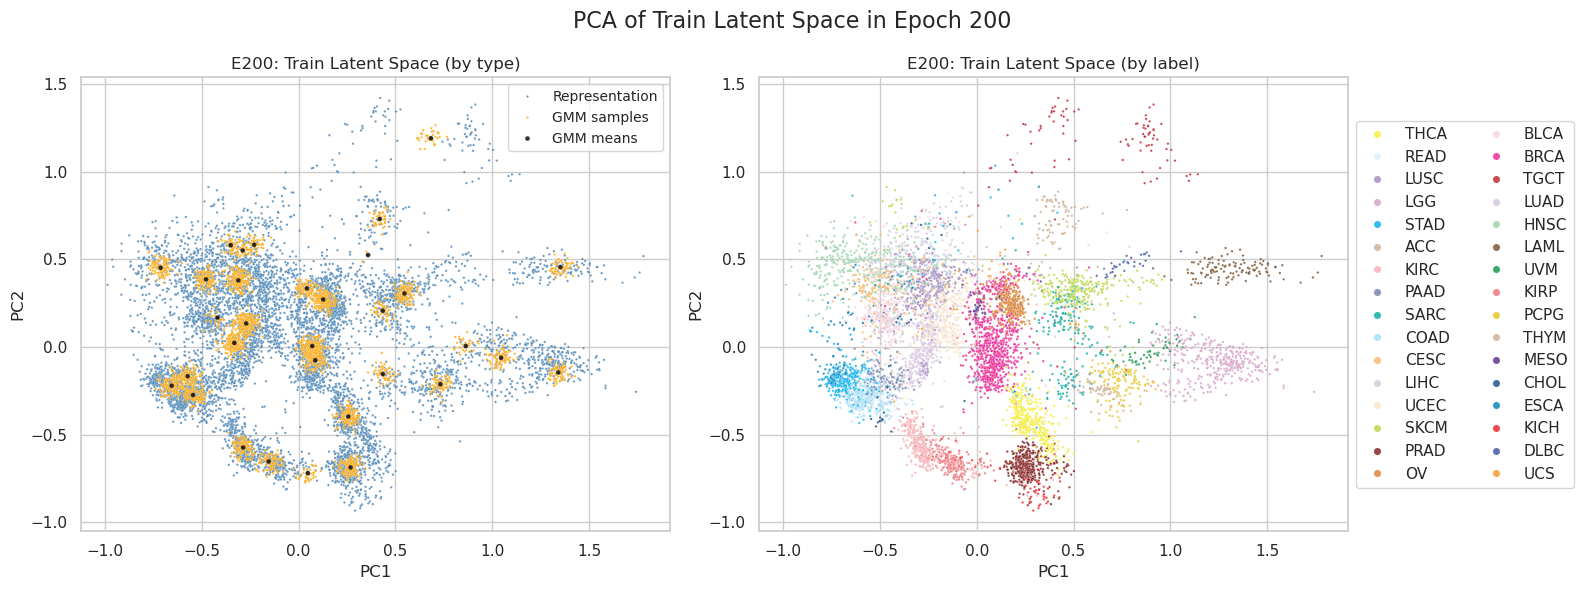

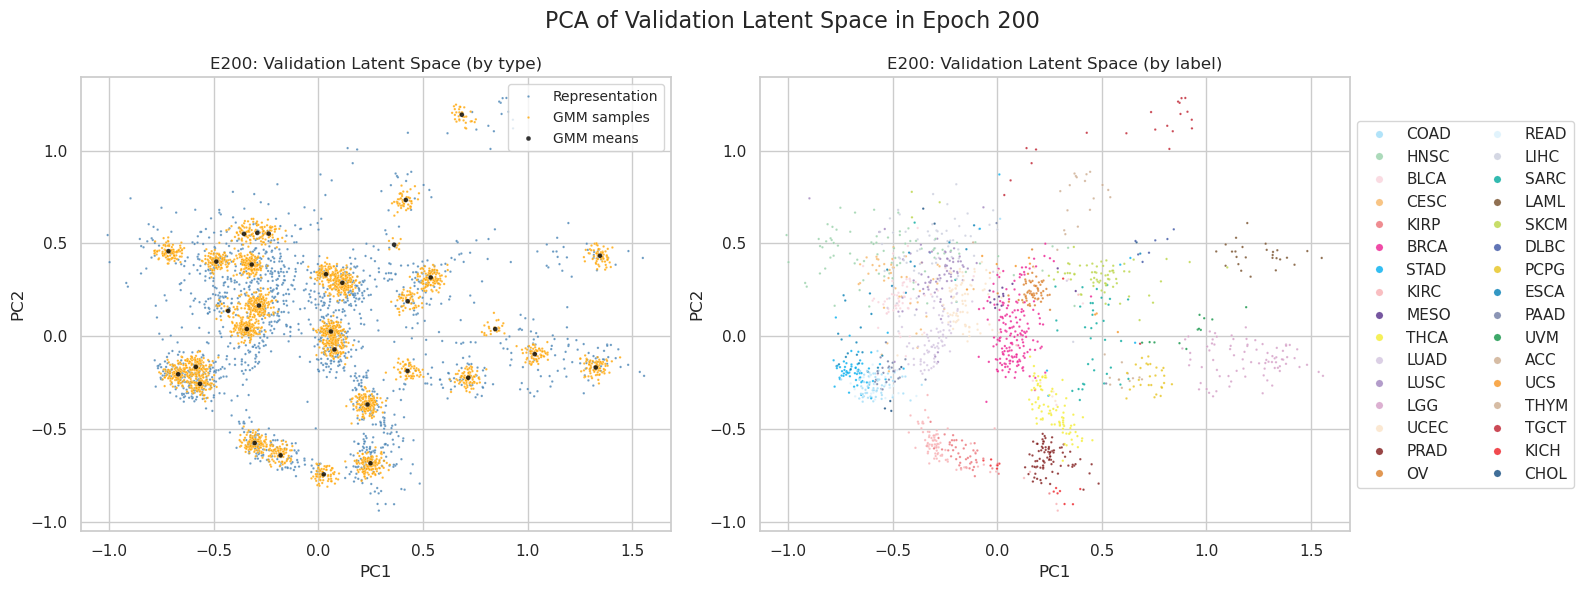

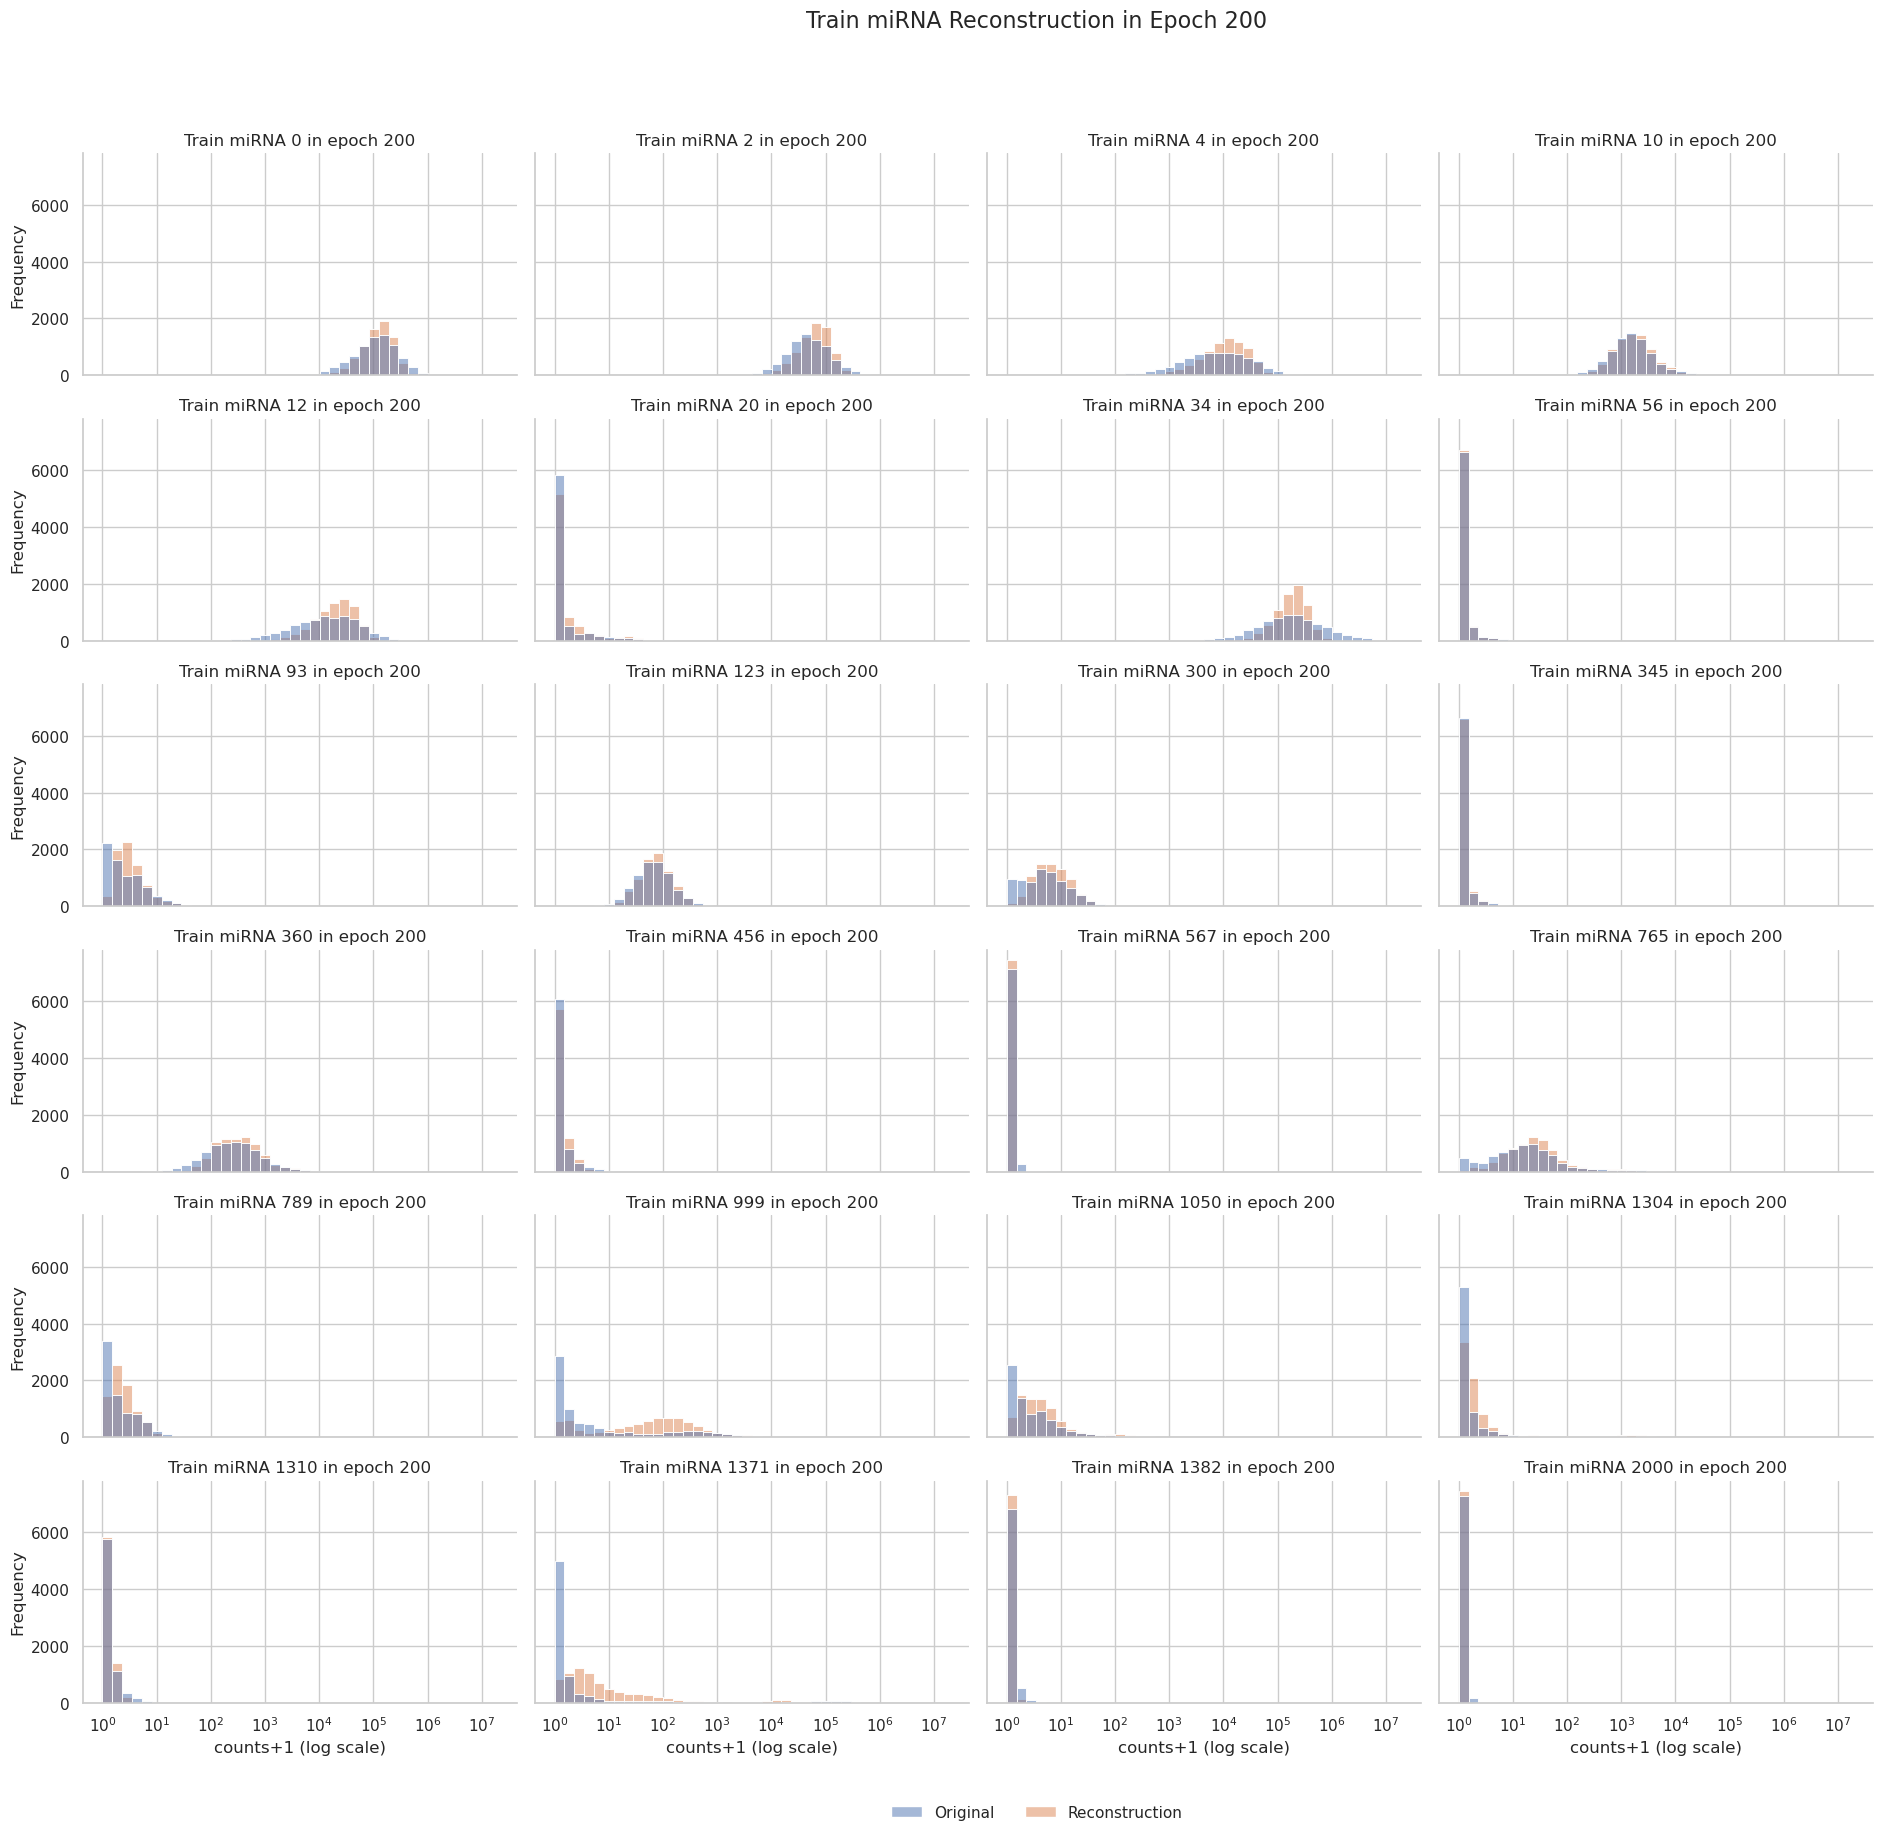

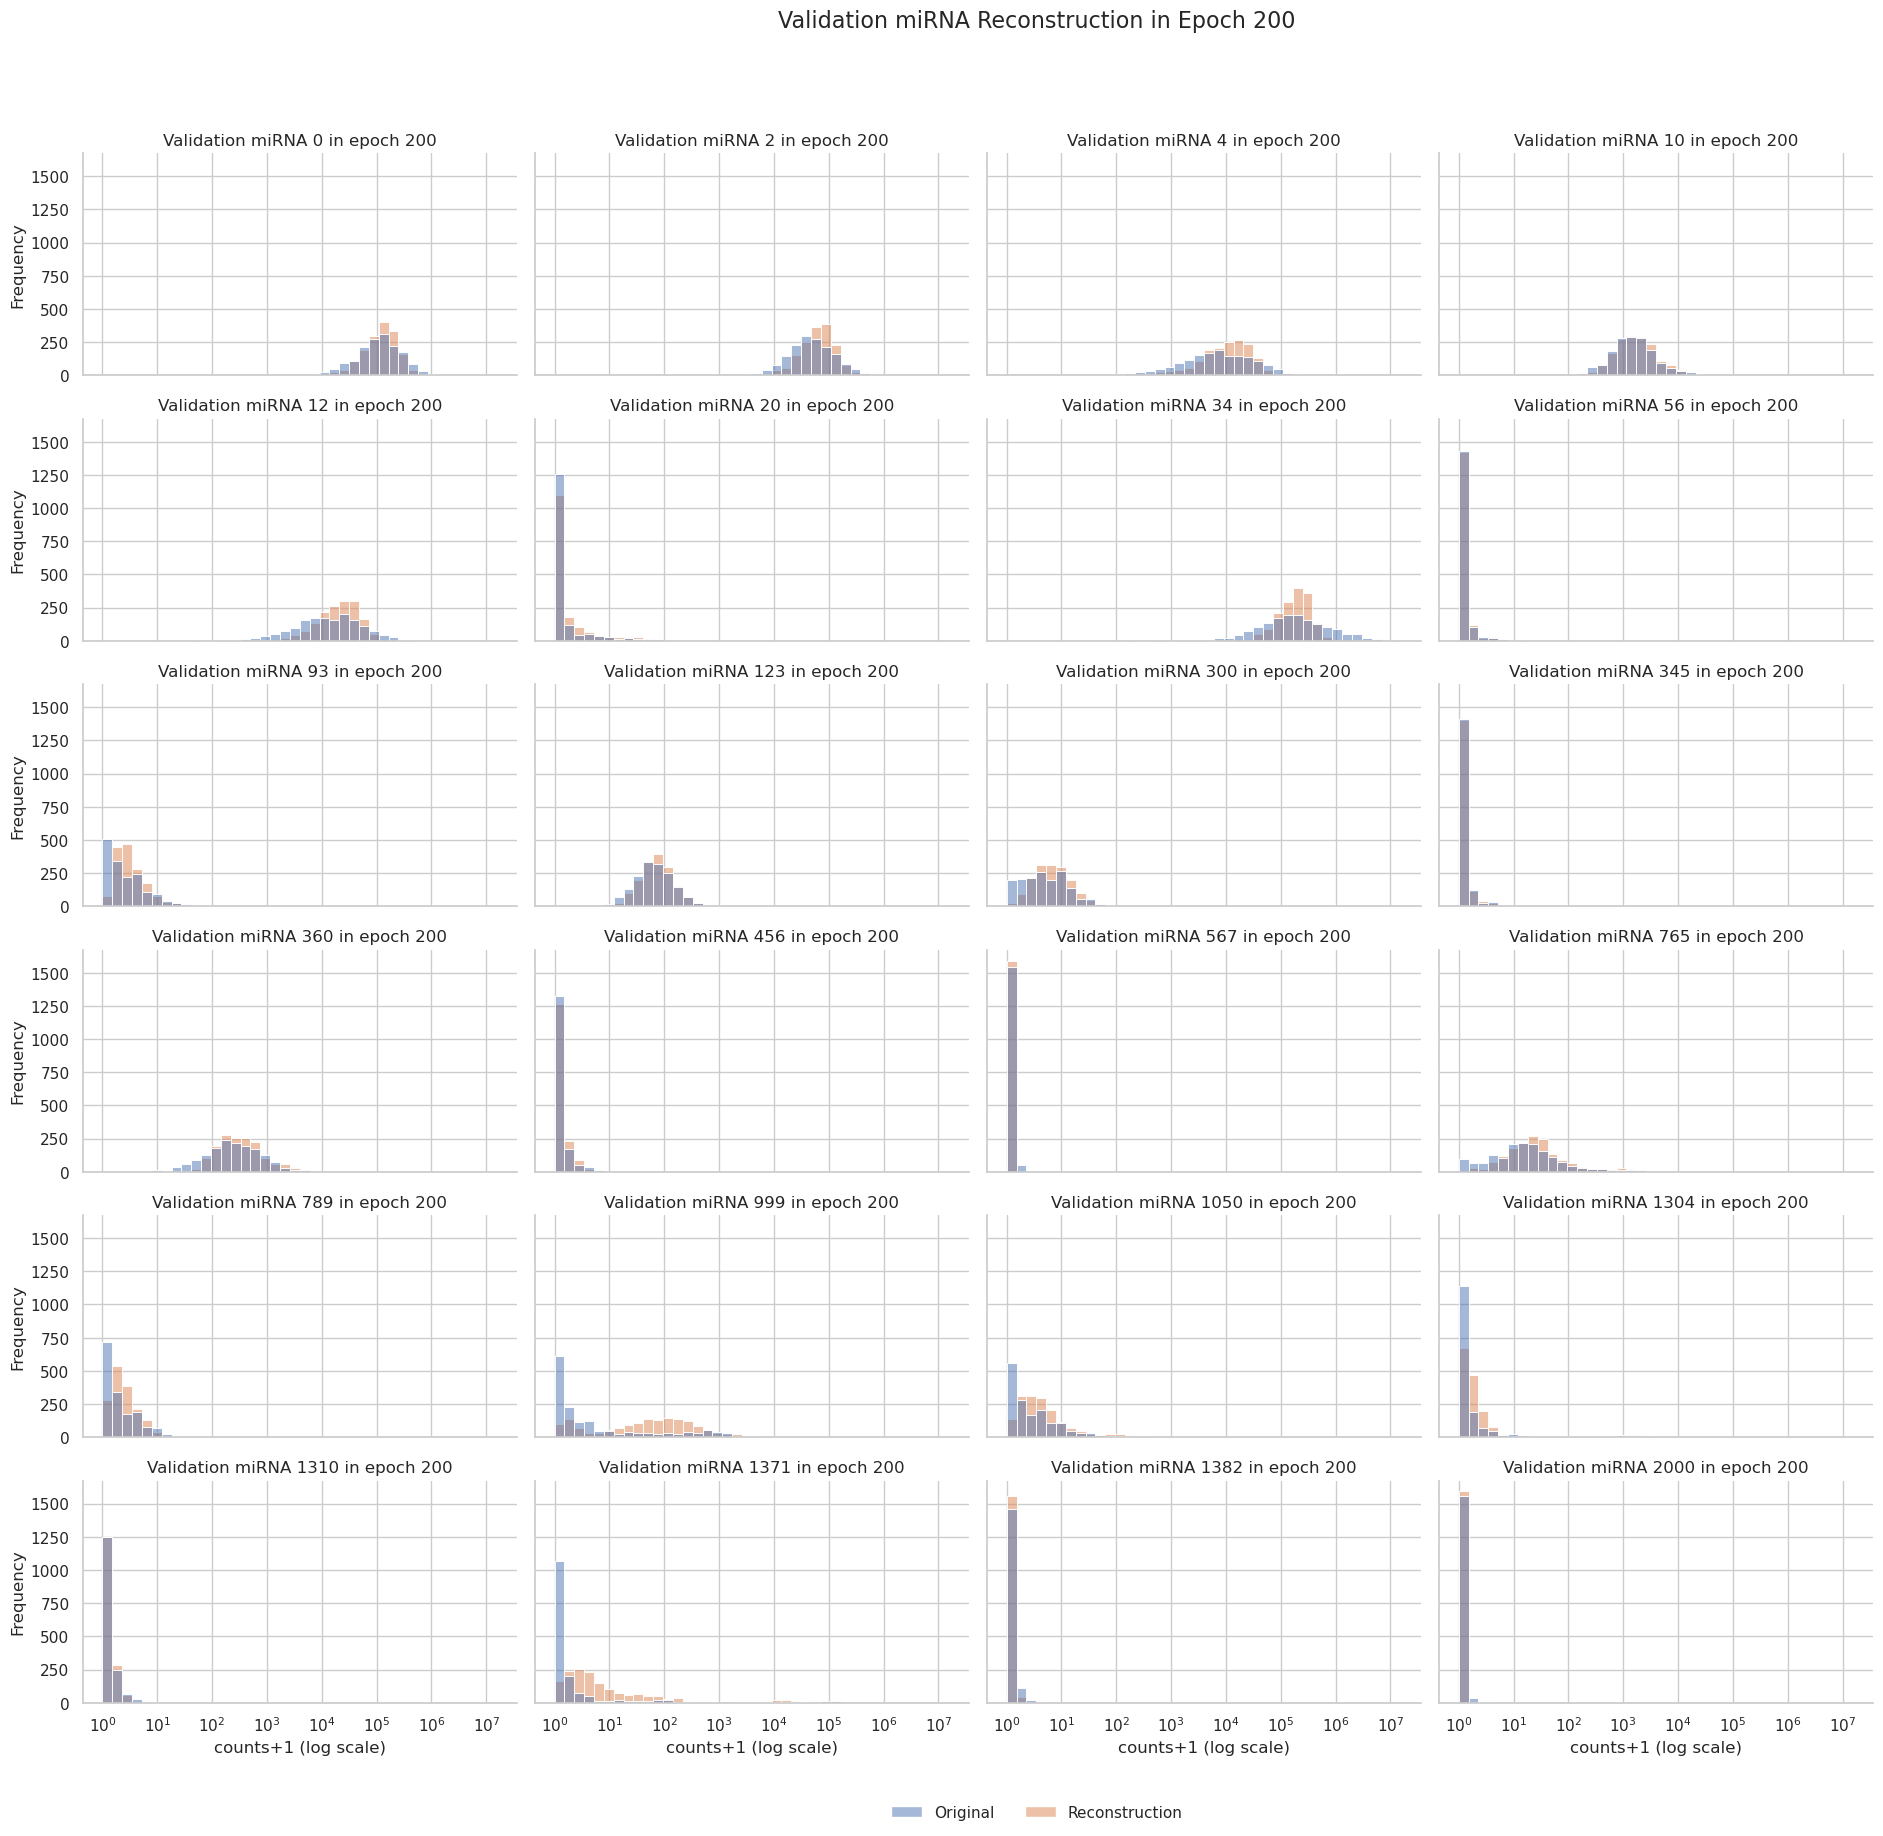

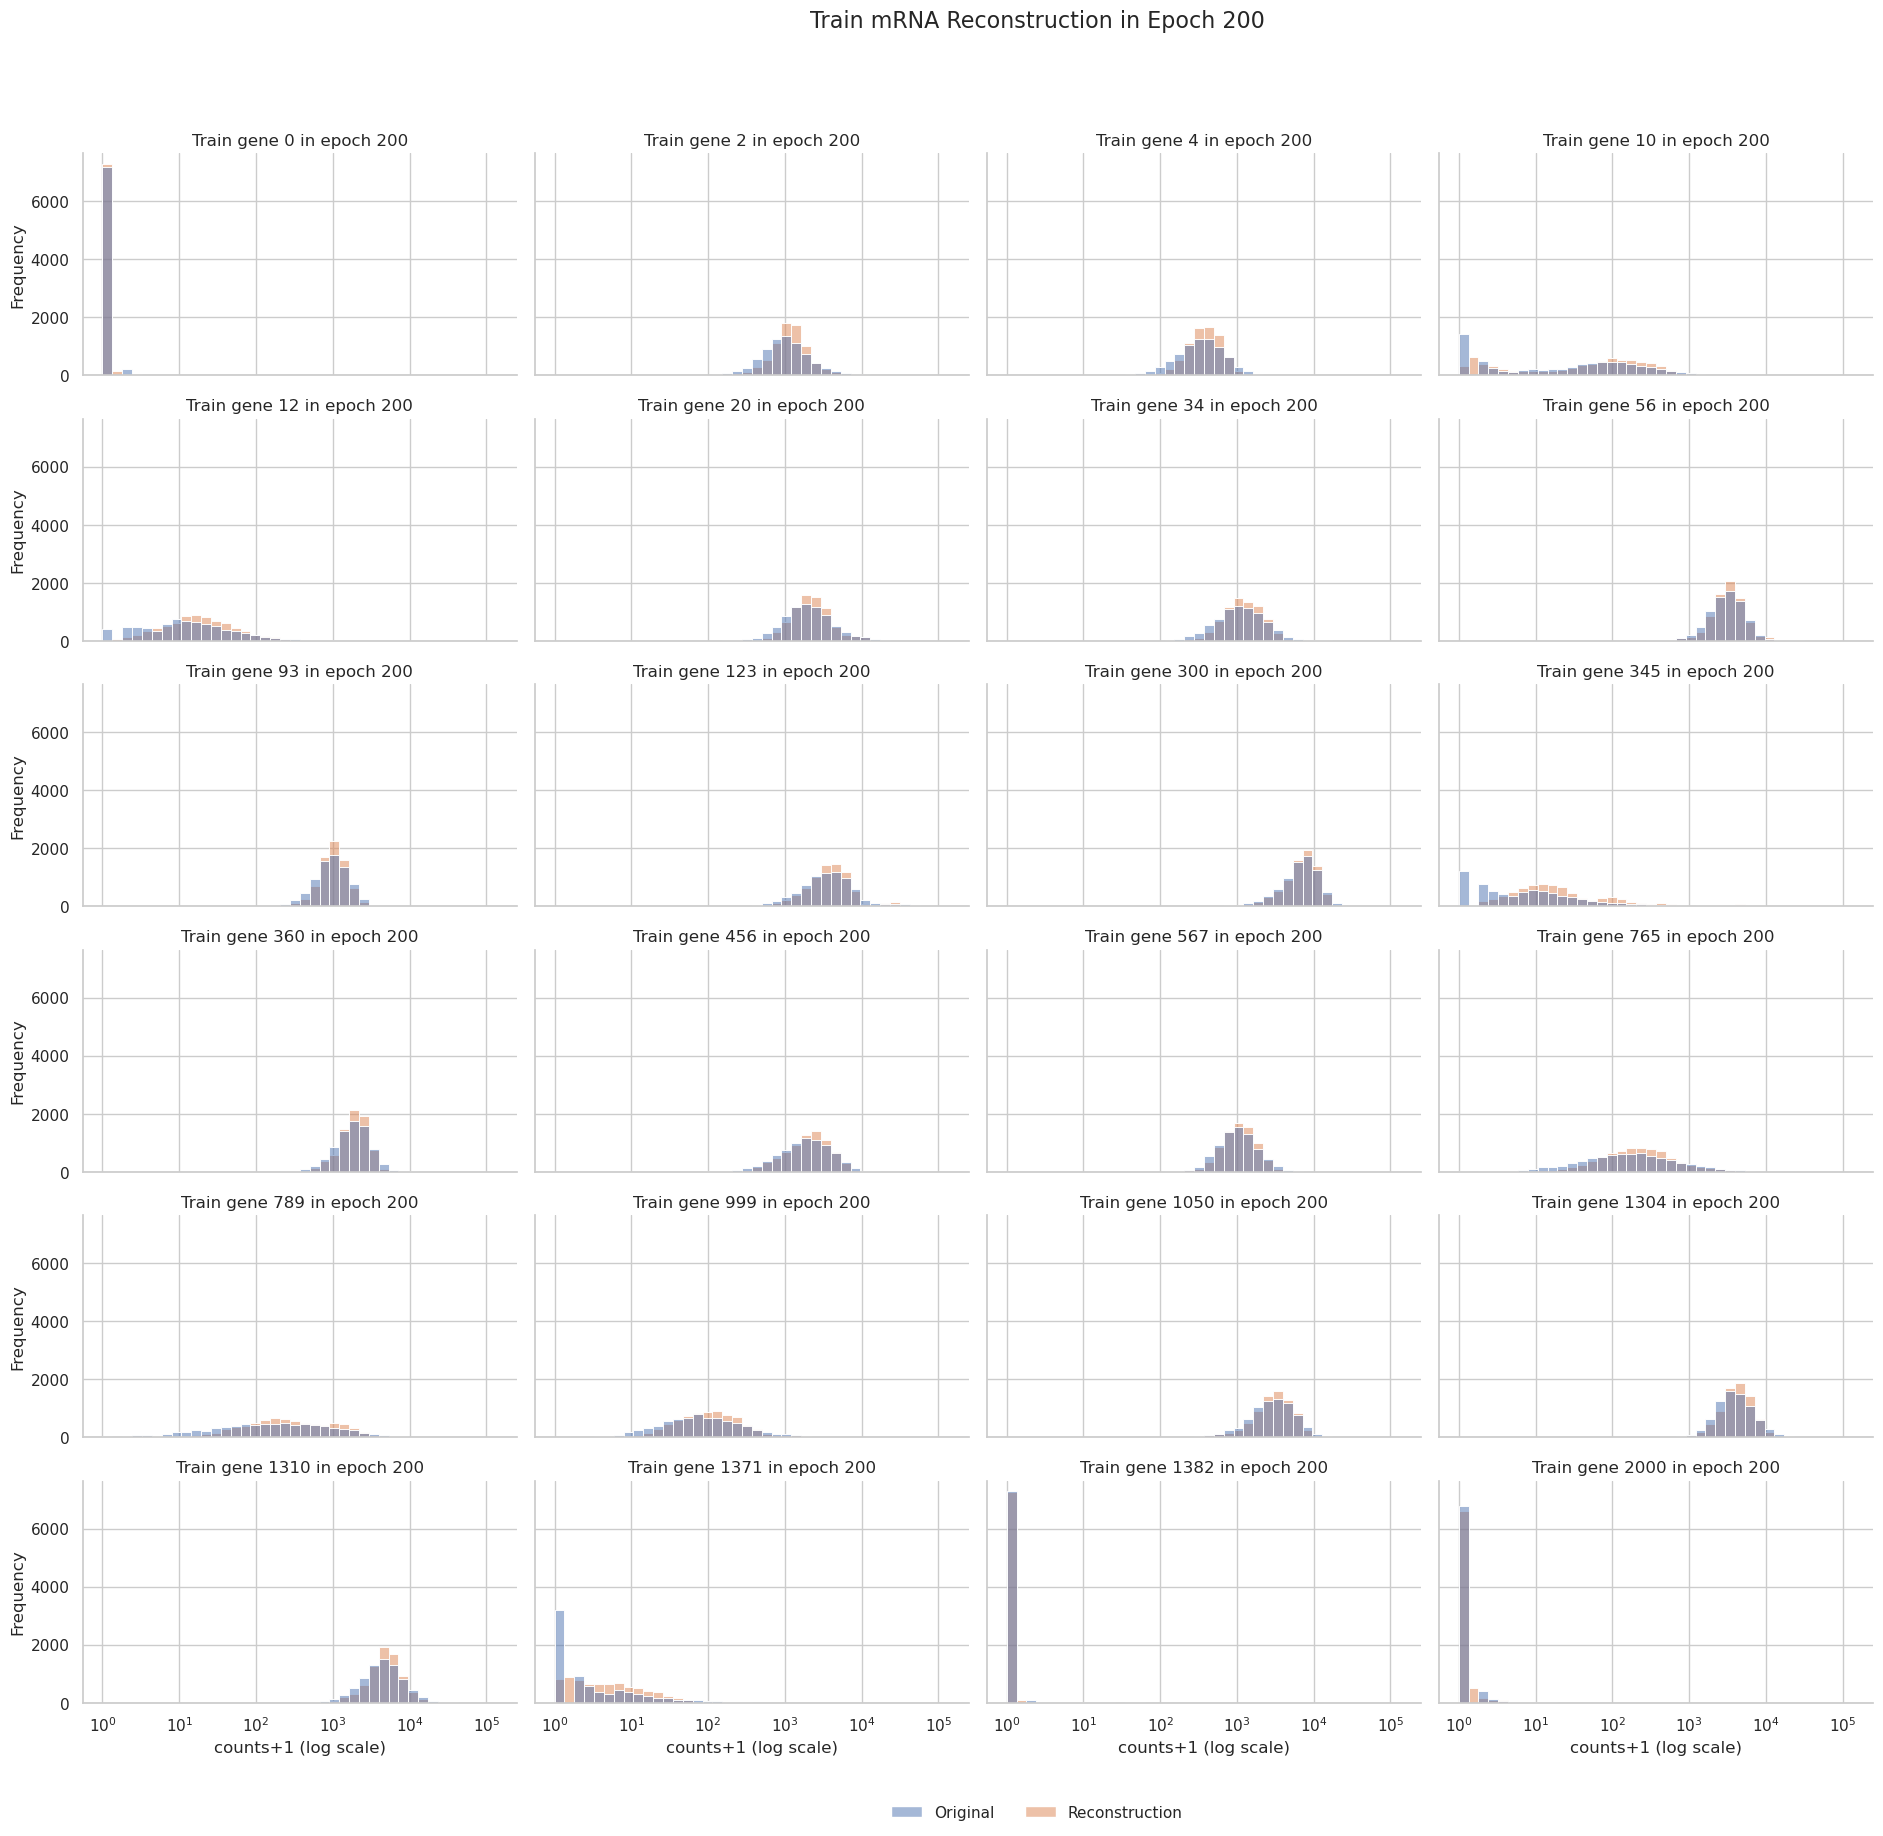

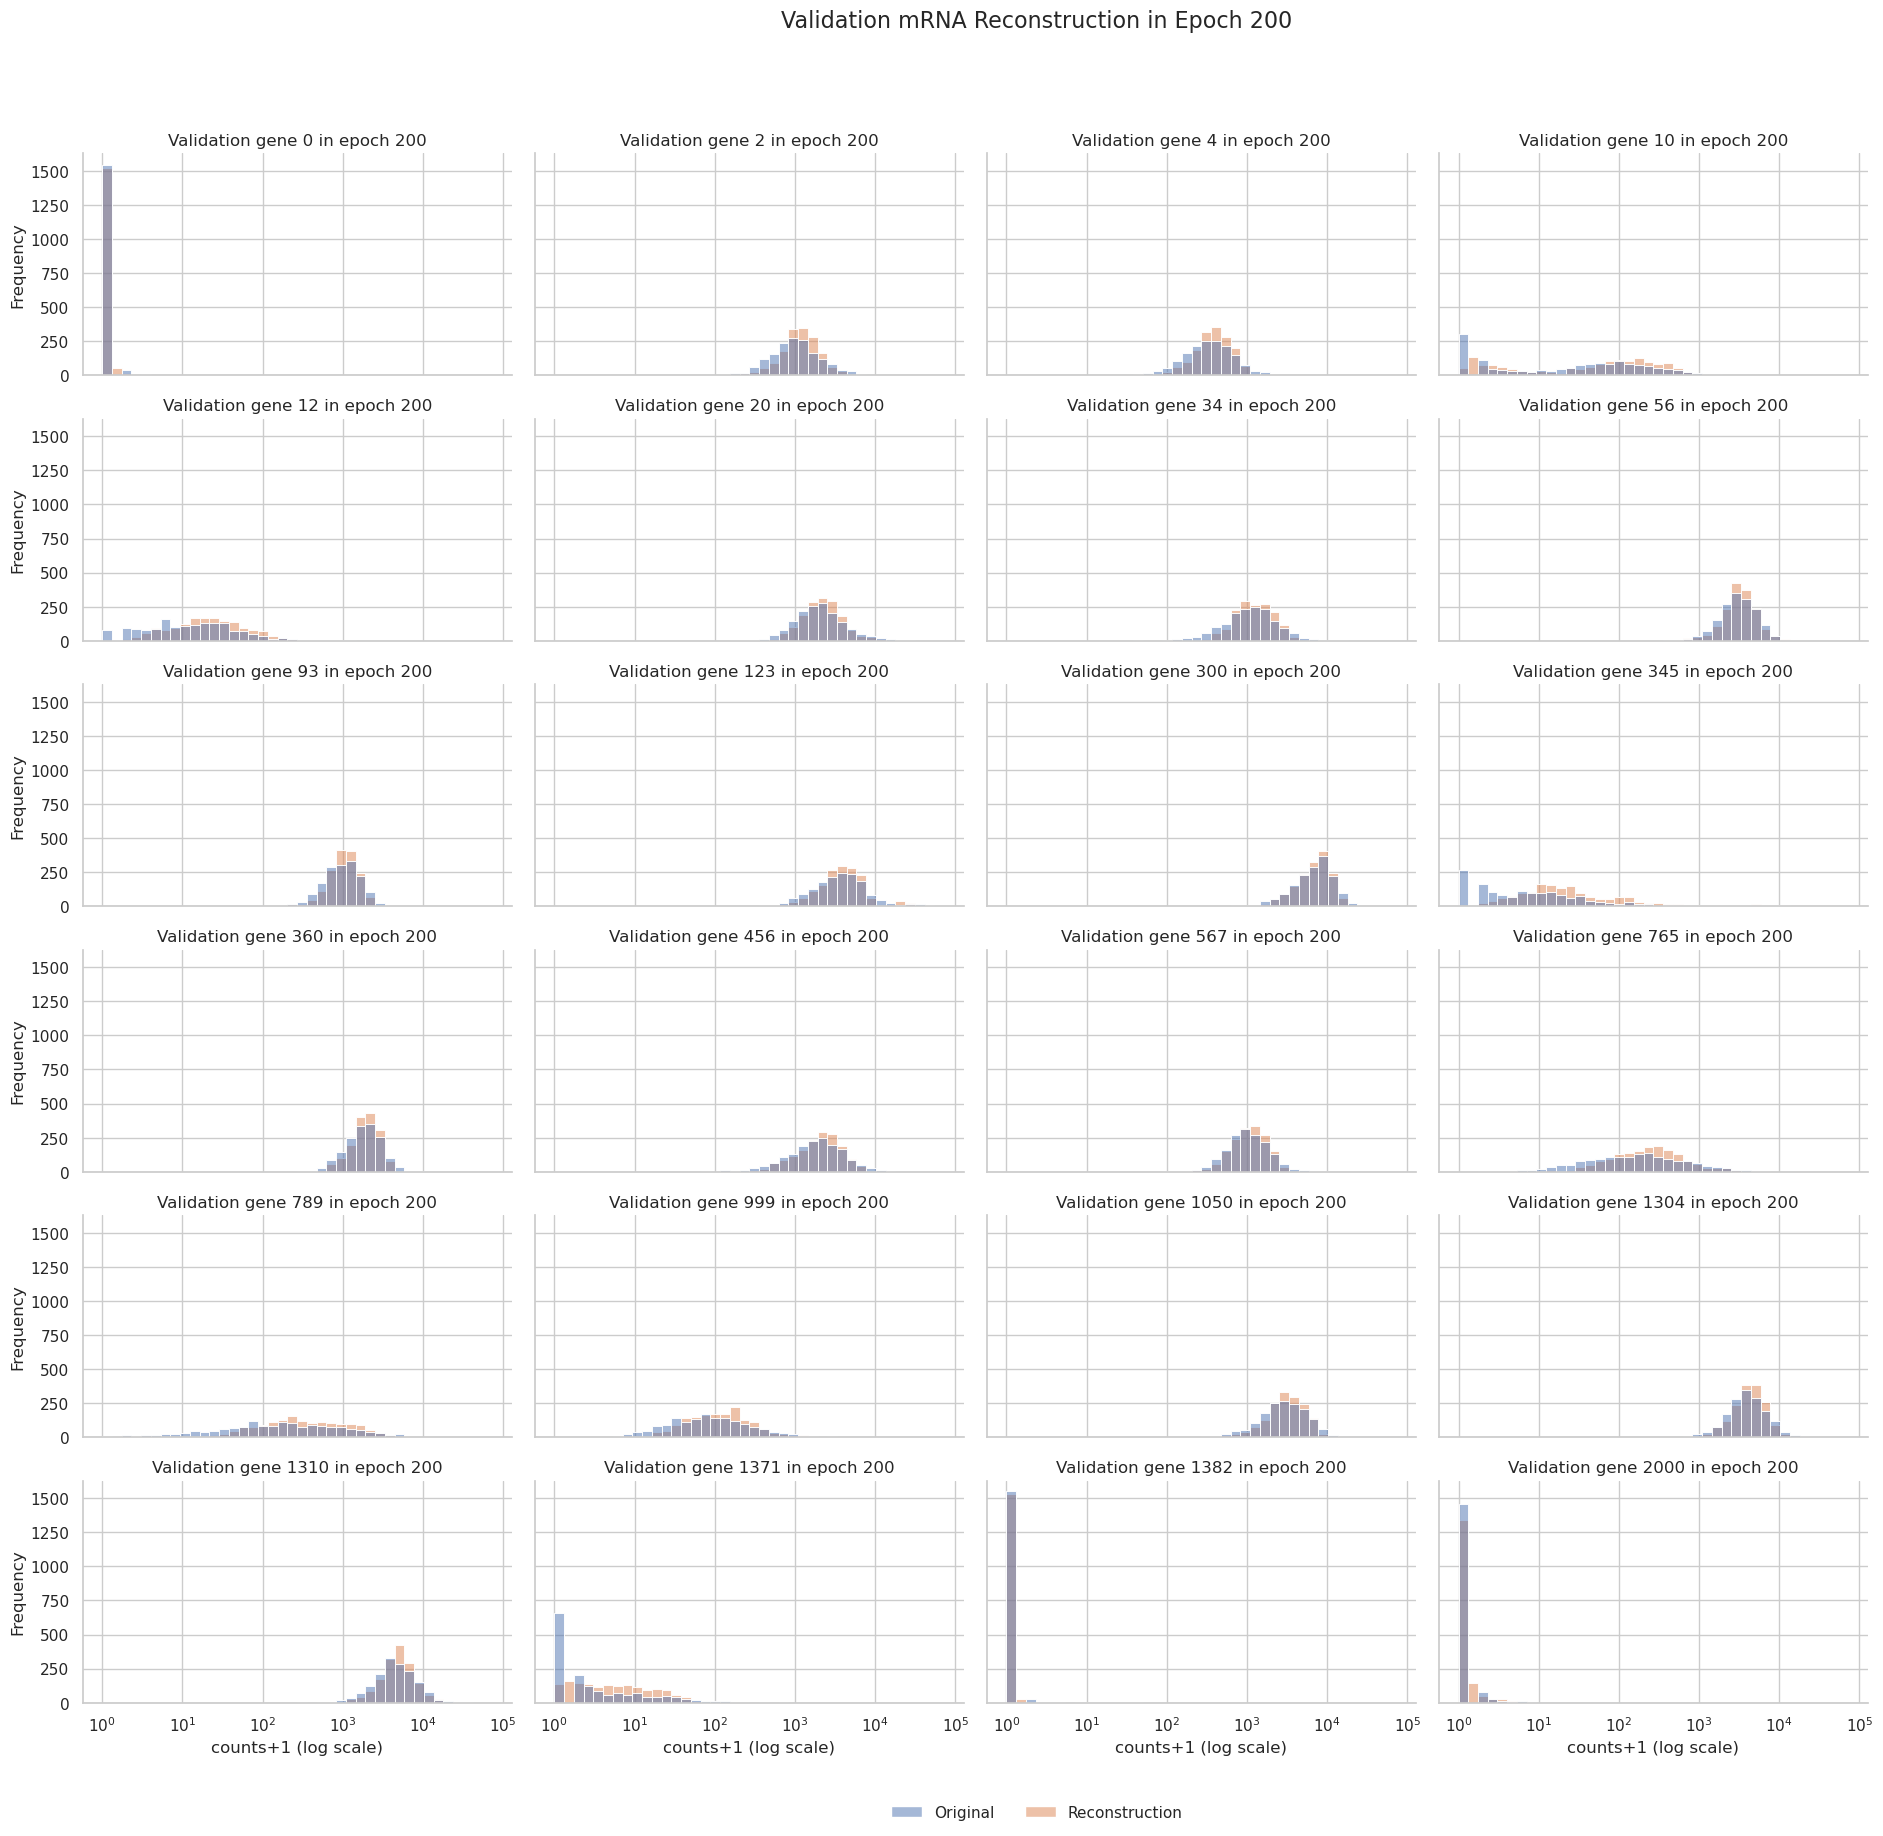

 26%|█████████████████████████████████████████████▎                                                                                                                                  | 206/801 [18:33<2:16:08, 13.73s/it]

205 train_recon_mirna: 1.9222925212748767 train_recon_mrna: 6.533043441810032 train_gmm: 2.231387495308632 train_mse: 671638080.0 train_mae: 4248.92626953125 train_r2: 0.16857033967971802 train_spearman: 0.4168854355812073 train_pearson: 0.8856682181358337 train_msle: 3.791339635848999
205 test_recon_mirna: 1.9189297208868346 test_recon_mrna: 6.560100712091669 test_gmm: 2.232962354461079 test_mse: 363568736.0 test_mae: 3111.754150390625 test_r2: 0.20690131187438965 test_spearman: 0.39023587107658386 test_pearson: 0.8817675709724426 test_msle: 3.720716953277588


 26%|██████████████████████████████████████████████▎                                                                                                                                 | 211/801 [18:58<1:04:37,  6.57s/it]

210 train_recon_mirna: 1.9196568470770135 train_recon_mrna: 6.5259956189105495 train_gmm: 2.2328995680020993 train_mse: 670019968.0 train_mae: 4240.53125 train_r2: 0.17057347297668457 train_spearman: 0.4218887686729431 train_pearson: 0.8847985863685608 train_msle: 3.57952618598938
210 test_recon_mirna: 1.9170166803402888 test_recon_mrna: 6.554781959163168 test_gmm: 2.234785342290951 test_mse: 362326016.0 test_mae: 3103.210693359375 test_r2: 0.20961225032806396 test_spearman: 0.394094854593277 test_pearson: 0.8846876621246338 test_msle: 3.464245557785034


 27%|████████████████████████████████████████████████                                                                                                                                  | 216/801 [19:25<53:34,  5.50s/it]

215 train_recon_mirna: 1.9171923972000784 train_recon_mrna: 6.519382642447041 train_gmm: 2.2343477061039536 train_mse: 664824064.0 train_mae: 4216.45458984375 train_r2: 0.17700546979904175 train_spearman: 0.4258175492286682 train_pearson: 0.8832092881202698 train_msle: 3.567009210586548
215 test_recon_mirna: 1.9135362957131536 test_recon_mrna: 6.551787528569934 test_gmm: 2.2349441633158964 test_mse: 359967008.0 test_mae: 3090.781005859375 test_r2: 0.21475821733474731 test_spearman: 0.3981512486934662 test_pearson: 0.8823313117027283 test_msle: 3.488682508468628


 28%|█████████████████████████████████████████████████                                                                                                                                 | 221/801 [19:50<50:36,  5.24s/it]

220 train_recon_mirna: 1.9148273344729432 train_recon_mrna: 6.512629085937615 train_gmm: 2.235466505918703 train_mse: 663118016.0 train_mae: 4210.1689453125 train_r2: 0.17911750078201294 train_spearman: 0.4271763861179352 train_pearson: 0.884625256061554 train_msle: 3.463480234146118
220 test_recon_mirna: 1.911652369797903 test_recon_mrna: 6.545069233709581 test_gmm: 2.2375784574338304 test_mse: 355620960.0 test_mae: 3065.396728515625 test_r2: 0.2242388129234314 test_spearman: 0.3981178402900696 test_pearson: 0.8817601799964905 test_msle: 3.3835806846618652


 28%|██████████████████████████████████████████████████▏                                                                                                                               | 226/801 [20:16<50:03,  5.22s/it]

225 train_recon_mirna: 1.912517562814406 train_recon_mrna: 6.506008497178838 train_gmm: 2.237091798704503 train_mse: 661224960.0 train_mae: 4198.86376953125 train_r2: 0.1814609169960022 train_spearman: 0.43335261940956116 train_pearson: 0.8823527097702026 train_msle: 3.2991602420806885
225 test_recon_mirna: 1.9093415610889193 test_recon_mrna: 6.5350617795897215 test_gmm: 2.237483713792161 test_mse: 355476128.0 test_mae: 3062.233154296875 test_r2: 0.22455477714538574 test_spearman: 0.4039977490901947 test_pearson: 0.8797255754470825 test_msle: 3.2129011154174805


 29%|███████████████████████████████████████████████████▎                                                                                                                              | 231/801 [20:42<48:33,  5.11s/it]

230 train_recon_mirna: 1.9104803085739757 train_recon_mrna: 6.50009512657671 train_gmm: 2.2385378116427472 train_mse: 657625600.0 train_mae: 4183.05908203125 train_r2: 0.18591666221618652 train_spearman: 0.43880653381347656 train_pearson: 0.8814305663108826 train_msle: 3.1895248889923096
230 test_recon_mirna: 1.9073560714971252 test_recon_mrna: 6.529916573277915 test_gmm: 2.2400814401887494 test_mse: 352676608.0 test_mae: 3048.033447265625 test_r2: 0.23066169023513794 test_spearman: 0.40847325325012207 test_pearson: 0.8806256651878357 test_msle: 3.0921473503112793


 29%|████████████████████████████████████████████████████▍                                                                                                                             | 236/801 [21:08<48:59,  5.20s/it]

235 train_recon_mirna: 1.9083437570576869 train_recon_mrna: 6.49391192281542 train_gmm: 2.239965467479802 train_mse: 656236800.0 train_mae: 4175.1708984375 train_r2: 0.18763583898544312 train_spearman: 0.4442494213581085 train_pearson: 0.879511833190918 train_msle: 3.016921281814575
235 test_recon_mirna: 1.9053450451237246 test_recon_mrna: 6.522458751512917 test_gmm: 2.2402989327349117 test_mse: 353721824.0 test_mae: 3052.264892578125 test_r2: 0.22838157415390015 test_spearman: 0.41082456707954407 test_pearson: 0.8829991817474365 test_msle: 2.953235626220703


 30%|█████████████████████████████████████████████████████▌                                                                                                                            | 241/801 [21:34<48:37,  5.21s/it]

240 train_recon_mirna: 1.9064549322141395 train_recon_mrna: 6.488000392585657 train_gmm: 2.241426693061166 train_mse: 653440320.0 train_mae: 4162.76171875 train_r2: 0.19109761714935303 train_spearman: 0.44839155673980713 train_pearson: 0.8789706230163574 train_msle: 2.9450929164886475
240 test_recon_mirna: 1.9034523144193476 test_recon_mrna: 6.5261058566018955 test_gmm: 2.242995481949758 test_mse: 349927712.0 test_mae: 3030.737548828125 test_r2: 0.2366582155227661 test_spearman: 0.4152691066265106 test_pearson: 0.8856465220451355 test_msle: 2.8783719539642334


 31%|██████████████████████████████████████████████████████▋                                                                                                                           | 246/801 [21:59<47:27,  5.13s/it]

245 train_recon_mirna: 1.9046254902861104 train_recon_mrna: 6.482064246104543 train_gmm: 2.2429745031331545 train_mse: 650007744.0 train_mae: 4145.9677734375 train_r2: 0.1953468918800354 train_spearman: 0.45114555954933167 train_pearson: 0.8770726919174194 train_msle: 2.883903741836548
245 test_recon_mirna: 1.9014267259083997 test_recon_mrna: 6.5113262976659545 test_gmm: 2.2441563012375076 test_mse: 346782560.0 test_mae: 3012.5576171875 test_r2: 0.243519127368927 test_spearman: 0.41634297370910645 test_pearson: 0.8848432898521423 test_msle: 2.7829229831695557


 31%|███████████████████████████████████████████████████████▊                                                                                                                          | 251/801 [22:25<46:54,  5.12s/it]

250 train_recon_mirna: 1.902831975207916 train_recon_mrna: 6.476436658555404 train_gmm: 2.244492124774187 train_mse: 648948992.0 train_mae: 4139.95166015625 train_r2: 0.19665753841400146 train_spearman: 0.4542991518974304 train_pearson: 0.8758409023284912 train_msle: 2.8316702842712402
250 test_recon_mirna: 1.8999948531041 test_recon_mrna: 6.509971637388756 test_gmm: 2.245065492514444 test_mse: 344302080.0 test_mae: 3001.030029296875 test_r2: 0.24893009662628174 test_spearman: 0.41901499032974243 test_pearson: 0.8838163614273071 test_msle: 2.7424275875091553


 32%|████████████████████████████████████████████████████████▉                                                                                                                         | 256/801 [22:50<46:16,  5.09s/it]

255 train_recon_mirna: 1.9011345219436877 train_recon_mrna: 6.470885759966651 train_gmm: 2.2458850821289977 train_mse: 644227456.0 train_mae: 4118.42724609375 train_r2: 0.20250236988067627 train_spearman: 0.456564337015152 train_pearson: 0.8734506964683533 train_msle: 2.7878894805908203
255 test_recon_mirna: 1.897992303630636 test_recon_mrna: 6.507610121972739 test_gmm: 2.247800980710298 test_mse: 344662016.0 test_mae: 3003.5185546875 test_r2: 0.24814492464065552 test_spearman: 0.42282983660697937 test_pearson: 0.8787952065467834 test_msle: 2.7113382816314697


 33%|██████████████████████████████████████████████████████████                                                                                                                        | 261/801 [23:15<45:57,  5.11s/it]

260 train_recon_mirna: 1.8996442022886475 train_recon_mrna: 6.465487615673419 train_gmm: 2.2473295187544955 train_mse: 643217408.0 train_mae: 4112.80908203125 train_r2: 0.20375263690948486 train_spearman: 0.45958825945854187 train_pearson: 0.872416079044342 train_msle: 2.73132061958313
260 test_recon_mirna: 1.8965440460106455 test_recon_mrna: 6.496298109866936 test_gmm: 2.2484121176095995 test_mse: 343892992.0 test_mae: 3000.6015625 test_r2: 0.2498224973678589 test_spearman: 0.4227030873298645 test_pearson: 0.8823525905609131 test_msle: 2.6967692375183105


 33%|███████████████████████████████████████████████████████████                                                                                                                       | 266/801 [23:41<45:40,  5.12s/it]

265 train_recon_mirna: 1.8980671718416868 train_recon_mrna: 6.460271664855002 train_gmm: 2.248855020325777 train_mse: 640889280.0 train_mae: 4102.19287109375 train_r2: 0.2066347599029541 train_spearman: 0.4617994427680969 train_pearson: 0.8714662790298462 train_msle: 2.706378936767578
265 test_recon_mirna: 1.8953523086407829 test_recon_mrna: 6.4925687085609995 test_gmm: 2.2498907161905644 test_mse: 337591392.0 test_mae: 2966.301513671875 test_r2: 0.2635689377784729 test_spearman: 0.42557305097579956 test_pearson: 0.8793813586235046 test_msle: 2.5738673210144043


 34%|████████████████████████████████████████████████████████████▏                                                                                                                     | 271/801 [24:07<45:51,  5.19s/it]

270 train_recon_mirna: 1.8966660370945416 train_recon_mrna: 6.455374227247811 train_gmm: 2.250160414732621 train_mse: 638507200.0 train_mae: 4088.060791015625 train_r2: 0.20958352088928223 train_spearman: 0.4634777009487152 train_pearson: 0.868736207485199 train_msle: 2.5680177211761475
270 test_recon_mirna: 1.8941374647268383 test_recon_mrna: 6.490231603576117 test_gmm: 2.2526911662266746 test_mse: 336190816.0 test_mae: 2957.674072265625 test_r2: 0.2666242718696594 test_spearman: 0.4240638315677643 test_pearson: 0.8794323801994324 test_msle: 2.5111076831817627


 34%|█████████████████████████████████████████████████████████████▎                                                                                                                    | 276/801 [24:33<45:31,  5.20s/it]

275 train_recon_mirna: 1.8952877788811129 train_recon_mrna: 6.450427787608123 train_gmm: 2.2515510492721713 train_mse: 636949184.0 train_mae: 4081.834228515625 train_r2: 0.21151220798492432 train_spearman: 0.4647965133190155 train_pearson: 0.867322564125061 train_msle: 2.4981682300567627
275 test_recon_mirna: 1.8924125554248457 test_recon_mrna: 6.48453138031322 test_gmm: 2.2534578074372464 test_mse: 335837696.0 test_mae: 2954.201171875 test_r2: 0.2673945426940918 test_spearman: 0.42789575457572937 test_pearson: 0.877638578414917 test_msle: 2.448291301727295


 35%|██████████████████████████████████████████████████████████████▍                                                                                                                   | 281/801 [25:00<45:29,  5.25s/it]

280 train_recon_mirna: 1.893915439951414 train_recon_mrna: 6.44536177460376 train_gmm: 2.253128433584864 train_mse: 635674560.0 train_mae: 4074.962646484375 train_r2: 0.21309006214141846 train_spearman: 0.46373146772384644 train_pearson: 0.866218090057373 train_msle: 2.5515170097351074
280 test_recon_mirna: 1.8908372166343046 test_recon_mrna: 6.478370253939041 test_gmm: 2.2537458887999686 test_mse: 338327392.0 test_mae: 2966.387451171875 test_r2: 0.26196348667144775 test_spearman: 0.42944857478141785 test_pearson: 0.8771345615386963 test_msle: 2.4562718868255615


 36%|███████████████████████████████████████████████████████████████▌                                                                                                                  | 286/801 [25:26<44:14,  5.15s/it]

285 train_recon_mirna: 1.8925069241776984 train_recon_mrna: 6.440751523206387 train_gmm: 2.2543559761103515 train_mse: 632806144.0 train_mae: 4062.937255859375 train_r2: 0.21664094924926758 train_spearman: 0.4687138795852661 train_pearson: 0.8648400902748108 train_msle: 2.414290189743042
285 test_recon_mirna: 1.8897219449522655 test_recon_mrna: 6.475938196648472 test_gmm: 2.2550950211781697 test_mse: 333909408.0 test_mae: 2943.622802734375 test_r2: 0.27160096168518066 test_spearman: 0.429565966129303 test_pearson: 0.8794139623641968 test_msle: 2.3819522857666016


 36%|████████████████████████████████████████████████████████████████▋                                                                                                                 | 291/801 [25:51<43:30,  5.12s/it]

290 train_recon_mirna: 1.8913389730533214 train_recon_mrna: 6.436438985084328 train_gmm: 2.2557056706225747 train_mse: 630037440.0 train_mae: 4050.407470703125 train_r2: 0.22006839513778687 train_spearman: 0.4676574766635895 train_pearson: 0.8645462393760681 train_msle: 2.425701141357422
290 test_recon_mirna: 1.8885079207612954 test_recon_mrna: 6.471839411572873 test_gmm: 2.2572981730168644 test_mse: 329766944.0 test_mae: 2922.908935546875 test_r2: 0.2806374430656433 test_spearman: 0.43292343616485596 test_pearson: 0.8814656734466553 test_msle: 2.3499345779418945


 37%|█████████████████████████████████████████████████████████████████▊                                                                                                                | 296/801 [26:16<42:32,  5.05s/it]

295 train_recon_mirna: 1.890016949068359 train_recon_mrna: 6.43202933766395 train_gmm: 2.257124108705402 train_mse: 626586368.0 train_mae: 4034.619384765625 train_r2: 0.2243404984474182 train_spearman: 0.472086101770401 train_pearson: 0.862930178642273 train_msle: 2.3951241970062256
295 test_recon_mirna: 1.8871539505709747 test_recon_mrna: 6.4685798517408815 test_gmm: 2.2582515413950266 test_mse: 335218560.0 test_mae: 2950.217529296875 test_r2: 0.2687451243400574 test_spearman: 0.4346288740634918 test_pearson: 0.8814241290092468 test_msle: 2.299849510192871


 38%|██████████████████████████████████████████████████████████████████▉                                                                                                               | 301/801 [26:42<42:30,  5.10s/it]

300 train_recon_mirna: 1.8887394343781223 train_recon_mrna: 6.427618341315025 train_gmm: 2.2584237744813622 train_mse: 626909376.0 train_mae: 4035.215576171875 train_r2: 0.22394061088562012 train_spearman: 0.4722149074077606 train_pearson: 0.86098313331604 train_msle: 2.3908894062042236
300 test_recon_mirna: 1.8870440208981911 test_recon_mrna: 6.470871869409667 test_gmm: 2.2580195086810977 test_mse: 330411232.0 test_mae: 2925.251220703125 test_r2: 0.2792320251464844 test_spearman: 0.43267306685447693 test_pearson: 0.8851655721664429 test_msle: 2.385134220123291


 38%|████████████████████████████████████████████████████████████████████                                                                                                              | 306/801 [27:08<42:07,  5.11s/it]

305 train_recon_mirna: 1.8873744351536414 train_recon_mrna: 6.423665126576642 train_gmm: 2.2593834026453568 train_mse: 622379968.0 train_mae: 4016.33203125 train_r2: 0.2295476198196411 train_spearman: 0.4725079834461212 train_pearson: 0.8619393706321716 train_msle: 2.3935799598693848
305 test_recon_mirna: 1.8846595624908962 test_recon_mrna: 6.4627767819369515 test_gmm: 2.2592189695893192 test_mse: 329276224.0 test_mae: 2915.743408203125 test_r2: 0.2817079424858093 test_spearman: 0.43313491344451904 test_pearson: 0.8833544254302979 test_msle: 2.3392317295074463


 39%|█████████████████████████████████████████████████████████████████████                                                                                                             | 311/801 [27:34<41:50,  5.12s/it]

310 train_recon_mirna: 1.8863104826419907 train_recon_mrna: 6.419613894216196 train_gmm: 2.2606772319804422 train_mse: 622896832.0 train_mae: 4016.970703125 train_r2: 0.22890782356262207 train_spearman: 0.4728688597679138 train_pearson: 0.8602453470230103 train_msle: 2.3158764839172363
310 test_recon_mirna: 1.8837998129257159 test_recon_mrna: 6.457574781426975 test_gmm: 2.2607276930800086 test_mse: 325473472.0 test_mae: 2894.650390625 test_r2: 0.29000329971313477 test_spearman: 0.43701592087745667 test_pearson: 0.8810738325119019 test_msle: 2.2887215614318848


 39%|██████████████████████████████████████████████████████████████████████▏                                                                                                           | 316/801 [27:59<41:30,  5.13s/it]

315 train_recon_mirna: 1.885191820659777 train_recon_mrna: 6.415672779163525 train_gmm: 2.2618791712665596 train_mse: 619079872.0 train_mae: 4002.7470703125 train_r2: 0.2336329221725464 train_spearman: 0.47036102414131165 train_pearson: 0.8605378270149231 train_msle: 2.356428861618042
315 test_recon_mirna: 1.8827524480592663 test_recon_mrna: 6.454562205166526 test_gmm: 2.261563588797041 test_mse: 328636096.0 test_mae: 2913.491455078125 test_r2: 0.2831043004989624 test_spearman: 0.4364478886127472 test_pearson: 0.8813895583152771 test_msle: 2.2959353923797607


 40%|███████████████████████████████████████████████████████████████████████▎                                                                                                          | 321/801 [28:25<41:18,  5.16s/it]

320 train_recon_mirna: 1.8840751379703429 train_recon_mrna: 6.412190706528983 train_gmm: 2.2632579254718026 train_mse: 613908416.0 train_mae: 3979.270263671875 train_r2: 0.24003469944000244 train_spearman: 0.47280365228652954 train_pearson: 0.8620767593383789 train_msle: 2.312492609024048
320 test_recon_mirna: 1.8820276152518929 test_recon_mrna: 6.450971625333832 test_gmm: 2.2623835032914 test_mse: 325996864.0 test_mae: 2901.612548828125 test_r2: 0.28886157274246216 test_spearman: 0.4360925257205963 test_pearson: 0.8824032545089722 test_msle: 2.311617851257324


 41%|████████████████████████████████████████████████████████████████████████▍                                                                                                         | 326/801 [28:51<41:35,  5.25s/it]

325 train_recon_mirna: 1.8829281894563512 train_recon_mrna: 6.408175393627688 train_gmm: 2.264350574829804 train_mse: 617256960.0 train_mae: 3995.516357421875 train_r2: 0.2358894944190979 train_spearman: 0.4732227027416229 train_pearson: 0.8610835075378418 train_msle: 2.271752119064331
325 test_recon_mirna: 1.8809205890185976 test_recon_mrna: 6.4507416642016295 test_gmm: 2.2632179350796378 test_mse: 323108128.0 test_mae: 2883.49169921875 test_r2: 0.2951631546020508 test_spearman: 0.4400442838668823 test_pearson: 0.8820037245750427 test_msle: 2.2053115367889404


 41%|█████████████████████████████████████████████████████████████████████████▌                                                                                                        | 331/801 [29:17<40:32,  5.18s/it]

330 train_recon_mirna: 1.882055320307587 train_recon_mrna: 6.404838585007034 train_gmm: 2.2655981422443716 train_mse: 614850944.0 train_mae: 3979.014892578125 train_r2: 0.2388678789138794 train_spearman: 0.4739092290401459 train_pearson: 0.8573508858680725 train_msle: 2.2847180366516113
330 test_recon_mirna: 1.880173498321516 test_recon_mrna: 6.442929456132114 test_gmm: 2.264312343847595 test_mse: 320821376.0 test_mae: 2870.114990234375 test_r2: 0.3001515865325928 test_spearman: 0.43838176131248474 test_pearson: 0.881985604763031 test_msle: 2.2441389560699463


 42%|██████████████████████████████████████████████████████████████████████████▋                                                                                                       | 336/801 [29:42<39:03,  5.04s/it]

335 train_recon_mirna: 1.8810034036728533 train_recon_mrna: 6.401324477014132 train_gmm: 2.266737358984532 train_mse: 613477632.0 train_mae: 3976.3291015625 train_r2: 0.24056798219680786 train_spearman: 0.47356149554252625 train_pearson: 0.8592551350593567 train_msle: 2.281831741333008
335 test_recon_mirna: 1.878670777342718 test_recon_mrna: 6.440756642999043 test_gmm: 2.265399806578408 test_mse: 319618464.0 test_mae: 2861.615478515625 test_r2: 0.30277562141418457 test_spearman: 0.43873777985572815 test_pearson: 0.8795344829559326 test_msle: 2.2197859287261963


 43%|███████████████████████████████████████████████████████████████████████████▊                                                                                                      | 341/801 [30:14<46:18,  6.04s/it]

340 train_recon_mirna: 1.8799930676819951 train_recon_mrna: 6.397878032361718 train_gmm: 2.2680932019332096 train_mse: 608109696.0 train_mae: 3951.735107421875 train_r2: 0.2472129464149475 train_spearman: 0.47457003593444824 train_pearson: 0.8609894514083862 train_msle: 2.3145482540130615
340 test_recon_mirna: 1.877956943288903 test_recon_mrna: 6.442184091606542 test_gmm: 2.2665194452441835 test_mse: 318443168.0 test_mae: 2856.5498046875 test_r2: 0.30533939599990845 test_spearman: 0.44137415289878845 test_pearson: 0.8785658478736877 test_msle: 2.1790125370025635


 43%|████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 346/801 [30:40<40:15,  5.31s/it]

345 train_recon_mirna: 1.8789296637112973 train_recon_mrna: 6.394625609728413 train_gmm: 2.2692072025698766 train_mse: 611763456.0 train_mae: 3967.376220703125 train_r2: 0.24268996715545654 train_spearman: 0.4762353301048279 train_pearson: 0.8574939966201782 train_msle: 2.212467908859253
345 test_recon_mirna: 1.877616478584284 test_recon_mrna: 6.439822781851966 test_gmm: 2.2671821246364576 test_mse: 318892064.0 test_mae: 2856.181884765625 test_r2: 0.30436021089553833 test_spearman: 0.43953463435173035 test_pearson: 0.8764339685440063 test_msle: 2.175888776779175


 44%|██████████████████████████████████████████████████████████████████████████████                                                                                                    | 351/801 [31:05<38:17,  5.10s/it]

350 train_recon_mirna: 1.8779708647441726 train_recon_mrna: 6.391150051266402 train_gmm: 2.2703525465111905 train_mse: 608653376.0 train_mae: 3952.445068359375 train_r2: 0.24653995037078857 train_spearman: 0.4748477637767792 train_pearson: 0.8582722544670105 train_msle: 2.196648359298706
350 test_recon_mirna: 1.8761127160751185 test_recon_mrna: 6.432891674859638 test_gmm: 2.267734399398813 test_mse: 311687808.0 test_mae: 2815.065185546875 test_r2: 0.3200758099555969 test_spearman: 0.4395367205142975 test_pearson: 0.8779798746109009 test_msle: 2.1757757663726807


 44%|███████████████████████████████████████████████████████████████████████████████                                                                                                   | 356/801 [31:31<38:08,  5.14s/it]

355 train_recon_mirna: 1.877152093509956 train_recon_mrna: 6.388440741836679 train_gmm: 2.2715775179317417 train_mse: 606452352.0 train_mae: 3941.014892578125 train_r2: 0.24926459789276123 train_spearman: 0.47445186972618103 train_pearson: 0.8580188155174255 train_msle: 2.2278189659118652
355 test_recon_mirna: 1.8757500802749887 test_recon_mrna: 6.4317764203208565 test_gmm: 2.2710651195175866 test_mse: 310947712.0 test_mae: 2810.307373046875 test_r2: 0.32169026136398315 test_spearman: 0.44166022539138794 test_pearson: 0.8763841390609741 test_msle: 2.091181755065918


 45%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                 | 361/801 [31:57<37:56,  5.17s/it]

360 train_recon_mirna: 1.876432044151766 train_recon_mrna: 6.385601809863532 train_gmm: 2.2728298306193966 train_mse: 607122560.0 train_mae: 3947.434326171875 train_r2: 0.24843502044677734 train_spearman: 0.47804298996925354 train_pearson: 0.8595770001411438 train_msle: 2.1927061080932617
360 test_recon_mirna: 1.8747493817552887 test_recon_mrna: 6.428111596707658 test_gmm: 2.2705378916619496 test_mse: 315439360.0 test_mae: 2840.454833984375 test_r2: 0.311892032623291 test_spearman: 0.44272175431251526 test_pearson: 0.8743637800216675 test_msle: 2.1498963832855225


 46%|█████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 366/801 [32:23<37:47,  5.21s/it]

365 train_recon_mirna: 1.8754414380736395 train_recon_mrna: 6.3822829203012414 train_gmm: 2.27418470491164 train_mse: 605382528.0 train_mae: 3933.81982421875 train_r2: 0.25058895349502563 train_spearman: 0.4768584072589874 train_pearson: 0.8567337393760681 train_msle: 2.1605823040008545
365 test_recon_mirna: 1.8740158357748862 test_recon_mrna: 6.431035089923567 test_gmm: 2.2710700374033808 test_mse: 309150464.0 test_mae: 2802.841064453125 test_r2: 0.3256107568740845 test_spearman: 0.44230395555496216 test_pearson: 0.8745959997177124 test_msle: 2.133680820465088


 46%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                               | 371/801 [32:49<37:29,  5.23s/it]

370 train_recon_mirna: 1.8745667642148096 train_recon_mrna: 6.379758654720474 train_gmm: 2.2751365299191675 train_mse: 605155968.0 train_mae: 3936.07861328125 train_r2: 0.2508695125579834 train_spearman: 0.4770914912223816 train_pearson: 0.8578764200210571 train_msle: 2.061412811279297
370 test_recon_mirna: 1.8733661474547776 test_recon_mrna: 6.426846399157661 test_gmm: 2.2731480462040325 test_mse: 312613632.0 test_mae: 2821.808349609375 test_r2: 0.3180561661720276 test_spearman: 0.44158637523651123 test_pearson: 0.8740053176879883 test_msle: 2.0098249912261963


 47%|███████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 376/801 [33:15<37:03,  5.23s/it]

375 train_recon_mirna: 1.873720424407313 train_recon_mrna: 6.377153551715646 train_gmm: 2.2763657729022397 train_mse: 600924096.0 train_mae: 3916.81591796875 train_r2: 0.2561081647872925 train_spearman: 0.4754968285560608 train_pearson: 0.8581304550170898 train_msle: 2.1481447219848633
375 test_recon_mirna: 1.8725276576460363 test_recon_mrna: 6.422114287581963 test_gmm: 2.274749782545577 test_mse: 310611456.0 test_mae: 2809.324951171875 test_r2: 0.3224237561225891 test_spearman: 0.44224634766578674 test_pearson: 0.875121533870697 test_msle: 2.086554765701294


 48%|████████████████████████████████████████████████████████████████████████████████████▋                                                                                             | 381/801 [33:41<36:07,  5.16s/it]

380 train_recon_mirna: 1.8729782526300875 train_recon_mrna: 6.37437771096085 train_gmm: 2.2775592295022498 train_mse: 603905536.0 train_mae: 3926.680419921875 train_r2: 0.2524173855781555 train_spearman: 0.4784049391746521 train_pearson: 0.8556233048439026 train_msle: 2.165043592453003
380 test_recon_mirna: 1.8712195099699915 test_recon_mrna: 6.420493580499574 test_gmm: 2.2752046297968067 test_mse: 317051424.0 test_mae: 2848.45263671875 test_r2: 0.30837541818618774 test_spearman: 0.44180208444595337 test_pearson: 0.8708880543708801 test_msle: 2.175529718399048


 48%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                            | 386/801 [34:07<35:56,  5.20s/it]

385 train_recon_mirna: 1.8721728199284222 train_recon_mrna: 6.371783579015587 train_gmm: 2.278712773536816 train_mse: 600076736.0 train_mae: 3910.11279296875 train_r2: 0.2571570873260498 train_spearman: 0.4755246043205261 train_pearson: 0.8551715612411499 train_msle: 2.145864963531494
385 test_recon_mirna: 1.8707543702228473 test_recon_mrna: 6.416467789415719 test_gmm: 2.2765970395699955 test_mse: 304685952.0 test_mae: 2774.63916015625 test_r2: 0.33534979820251465 test_spearman: 0.44425535202026367 test_pearson: 0.8657993674278259 test_msle: 2.1343131065368652


 49%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 391/801 [34:33<35:18,  5.17s/it]

390 train_recon_mirna: 1.8713862101358039 train_recon_mrna: 6.369543757727064 train_gmm: 2.280029002847752 train_mse: 596443584.0 train_mae: 3893.7939453125 train_r2: 0.26165467500686646 train_spearman: 0.4738961458206177 train_pearson: 0.8570013046264648 train_msle: 2.2044405937194824
390 test_recon_mirna: 1.870416562385046 test_recon_mrna: 6.418404091890671 test_gmm: 2.2776589979163413 test_mse: 302645536.0 test_mae: 2767.97265625 test_r2: 0.33980077505111694 test_spearman: 0.44063881039619446 test_pearson: 0.8706017136573792 test_msle: 2.163851499557495


 49%|████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 396/801 [34:59<35:04,  5.20s/it]

395 train_recon_mirna: 1.8706806666383697 train_recon_mrna: 6.367116489598781 train_gmm: 2.2811498902559633 train_mse: 597935104.0 train_mae: 3900.857666015625 train_r2: 0.2598082423210144 train_spearman: 0.47782397270202637 train_pearson: 0.8573688268661499 train_msle: 1.9882029294967651
395 test_recon_mirna: 1.8695034874294227 test_recon_mrna: 6.411276404200163 test_gmm: 2.278059138453506 test_mse: 309579520.0 test_mae: 2811.549560546875 test_r2: 0.3246748447418213 test_spearman: 0.44310787320137024 test_pearson: 0.8719480037689209 test_msle: 1.9878029823303223


 50%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                         | 400/801 [35:20<34:55,  5.23s/it]

400 train_recon_mirna: 1.8698764766763776 train_recon_mrna: 6.364772228025891 train_gmm: 2.282238039363584 train_mse: 595005440.0 train_mae: 3888.603759765625 train_r2: 0.26343488693237305 train_spearman: 0.4800747334957123 train_pearson: 0.8586100935935974 train_msle: 2.0365309715270996
400 test_recon_mirna: 1.8689723840923287 test_recon_mrna: 6.4152867390356585 test_gmm: 2.280759827841974 test_mse: 302202336.0 test_mae: 2765.142333984375 test_r2: 0.34076762199401855 test_spearman: 0.44630861282348633 test_pearson: 0.8713502883911133 test_msle: 2.0091800689697266


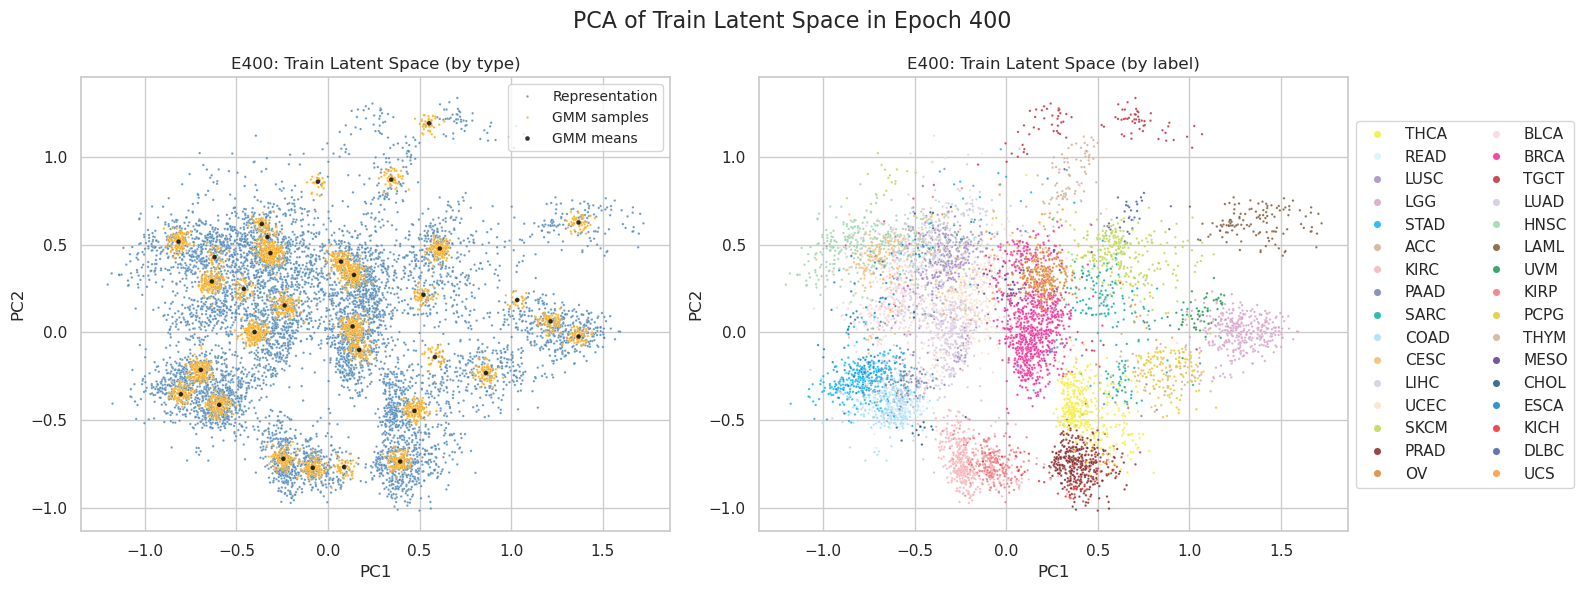

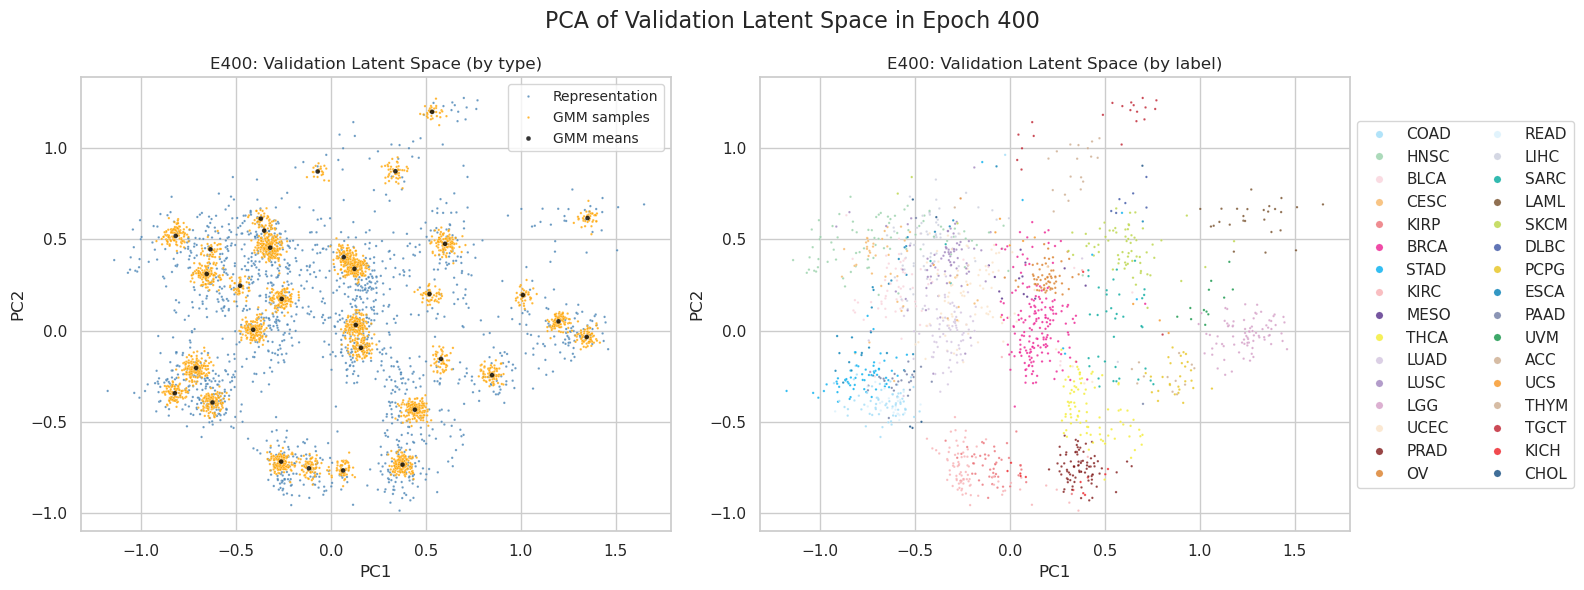

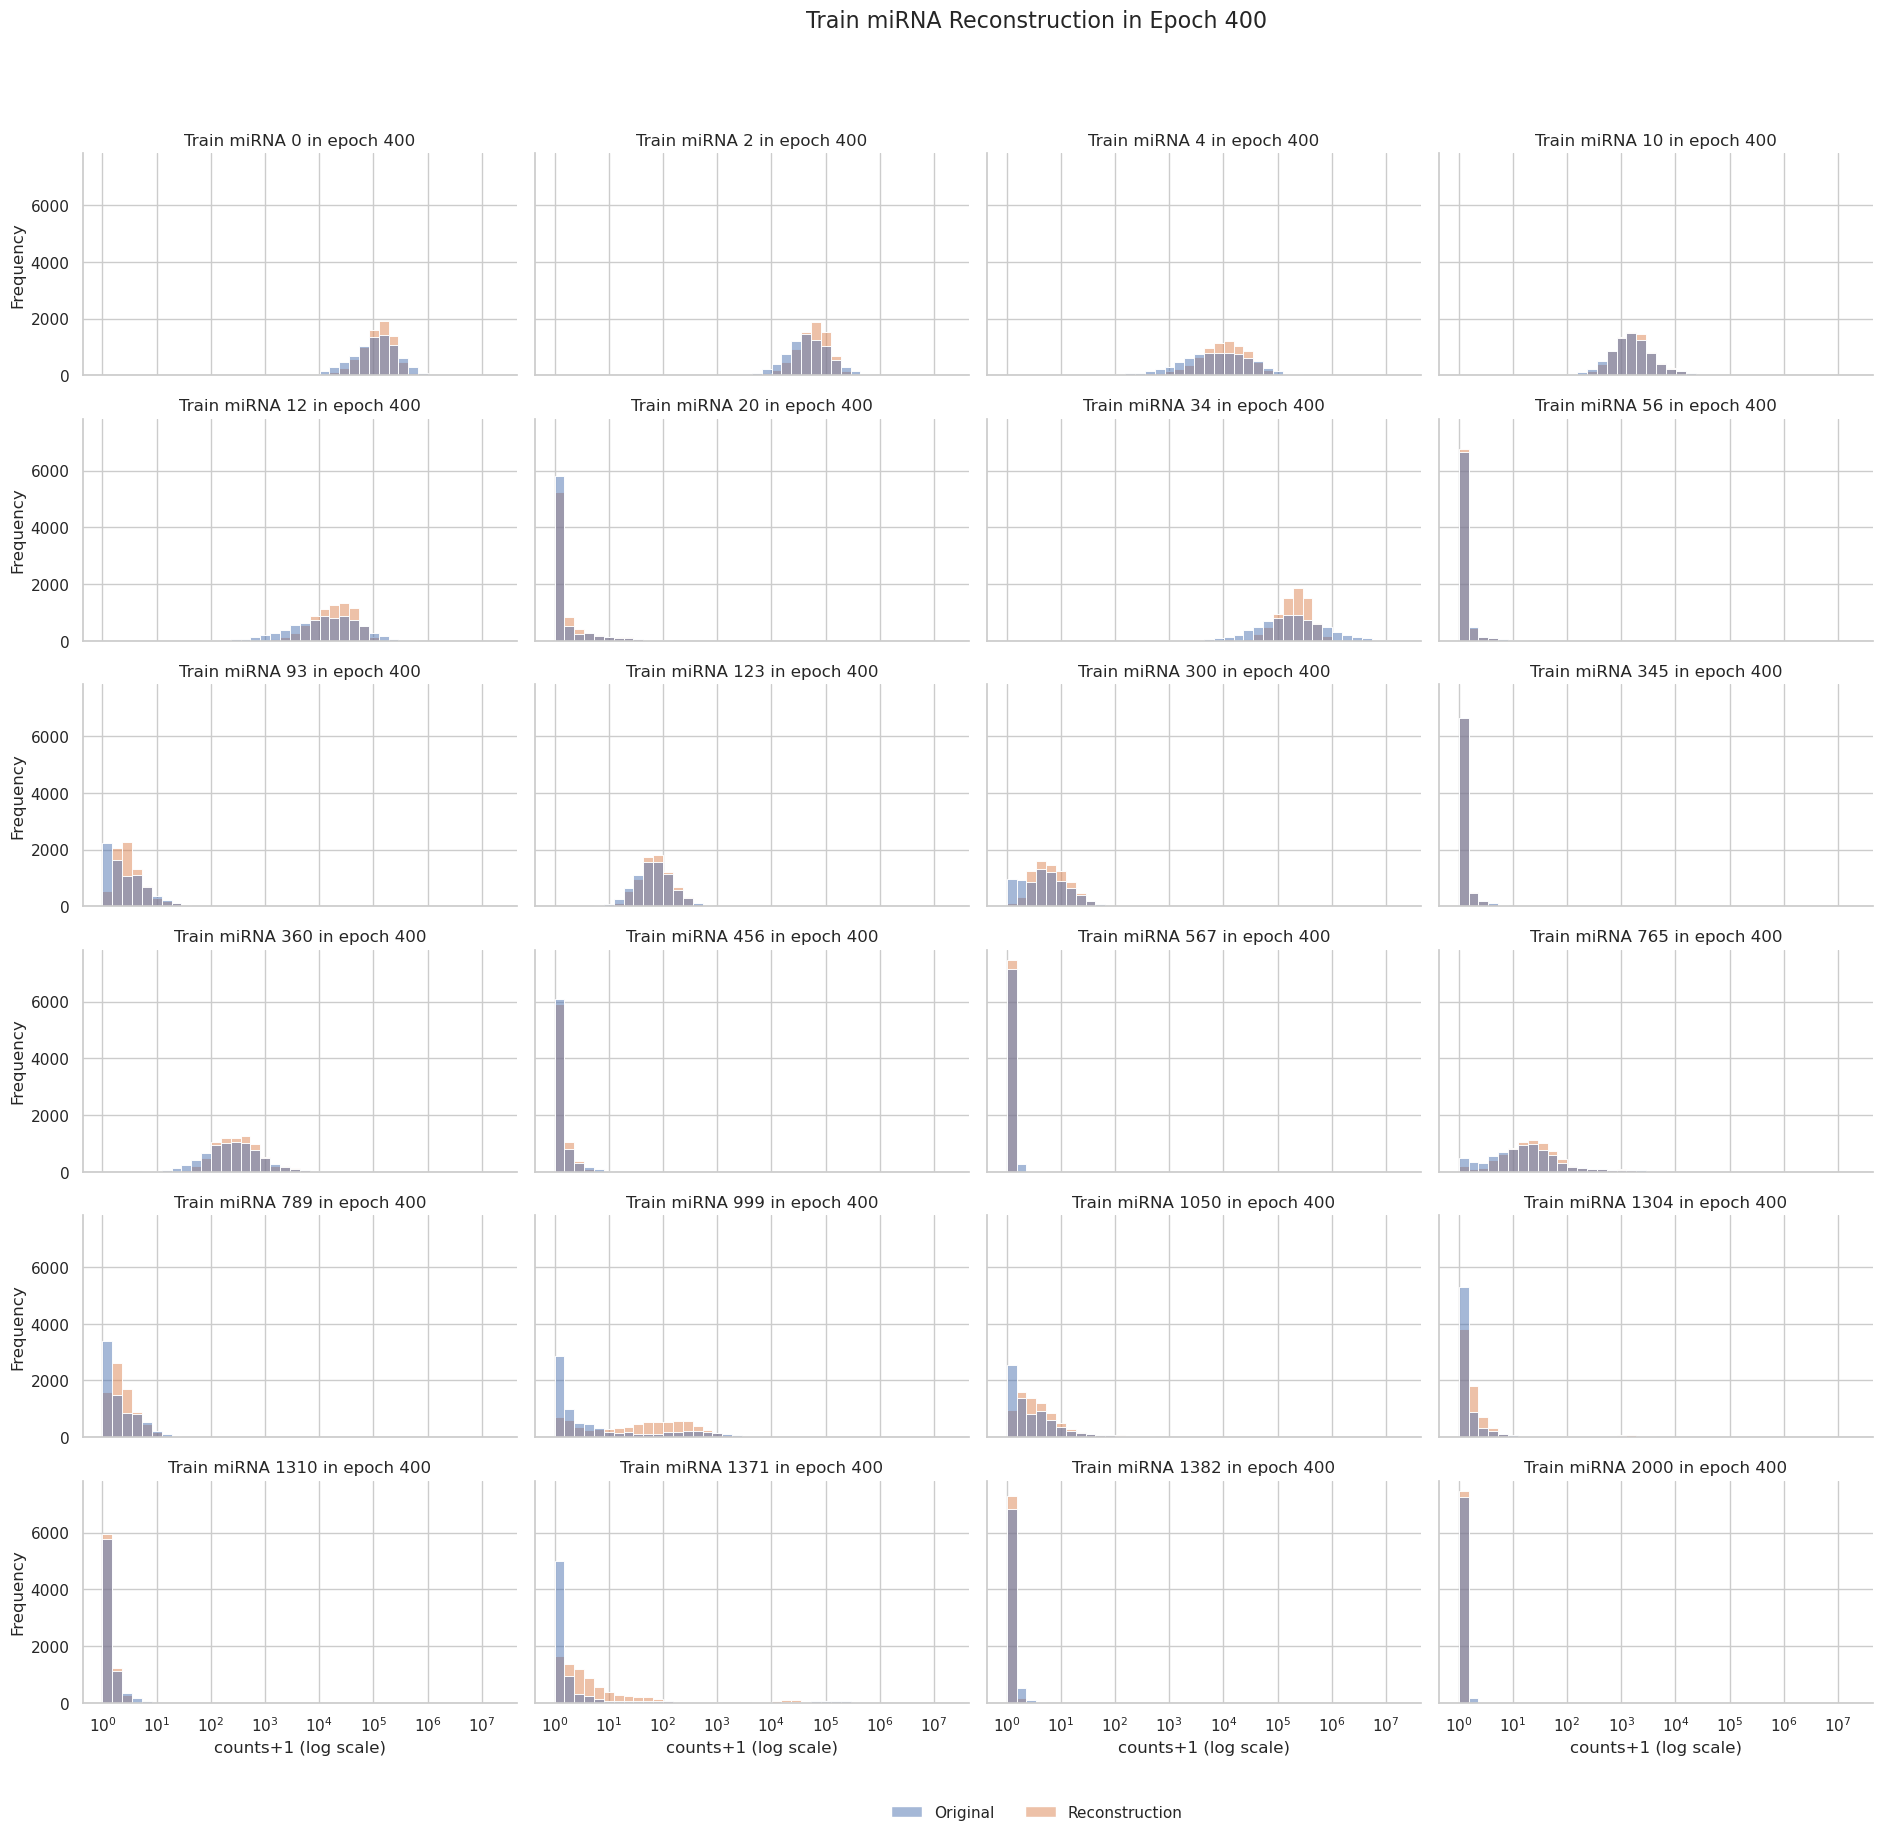

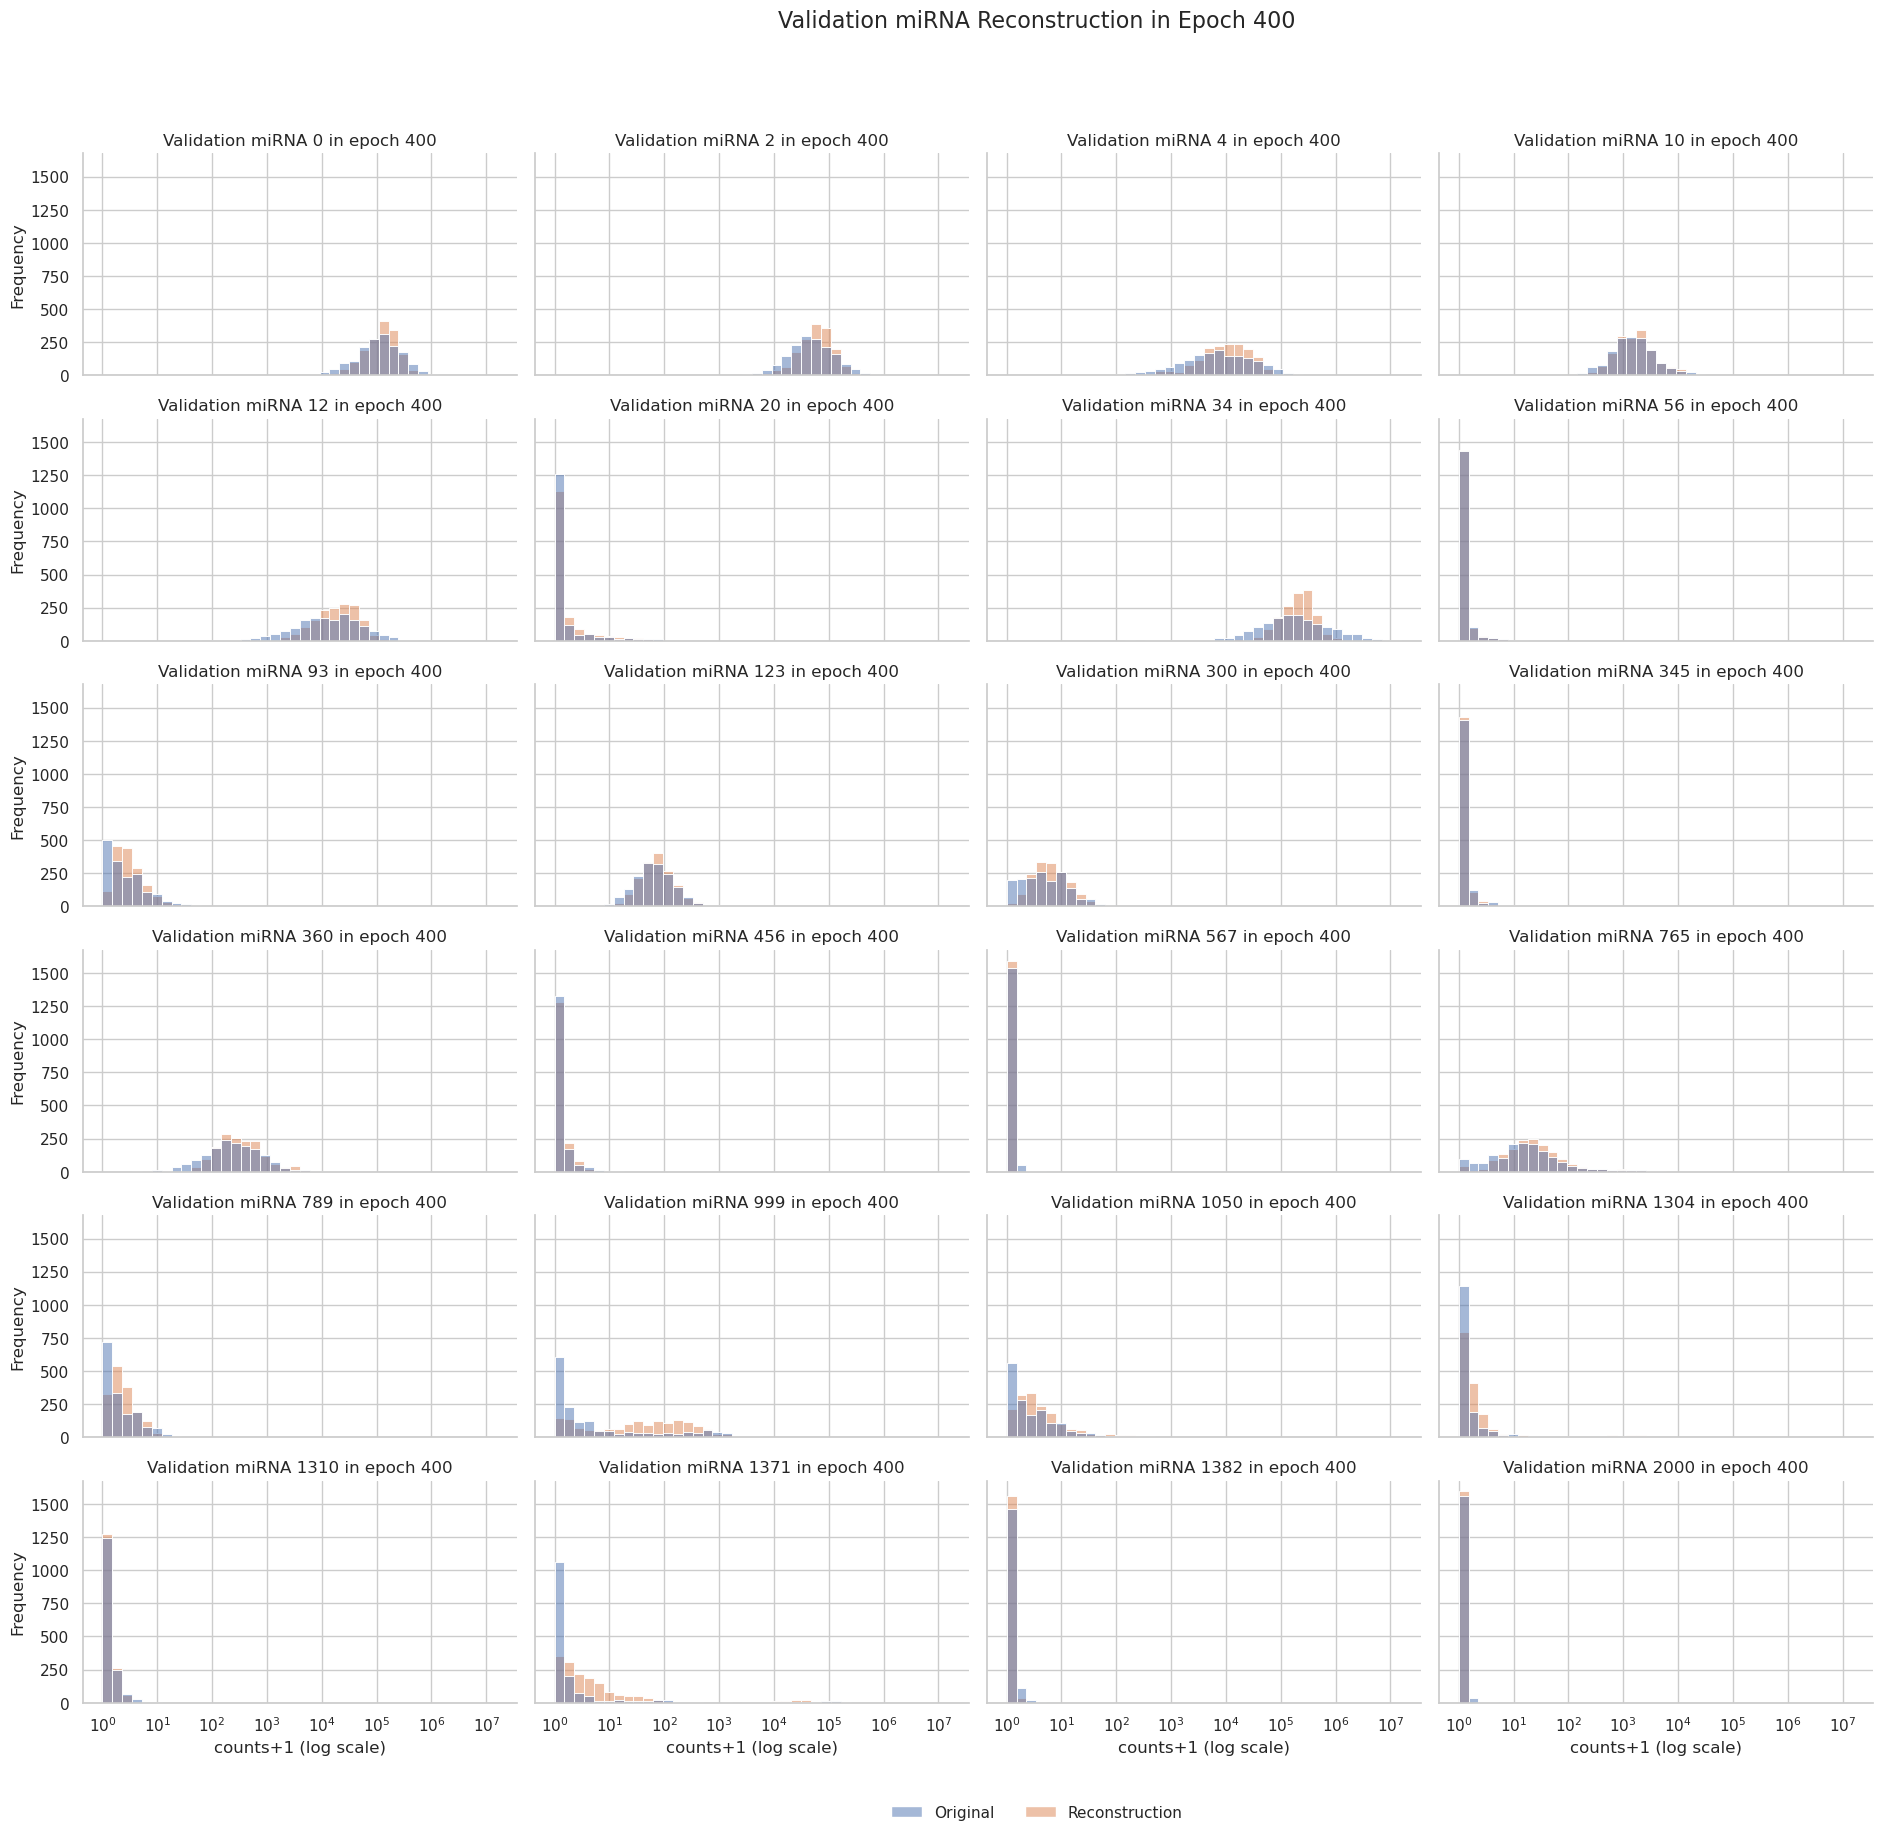

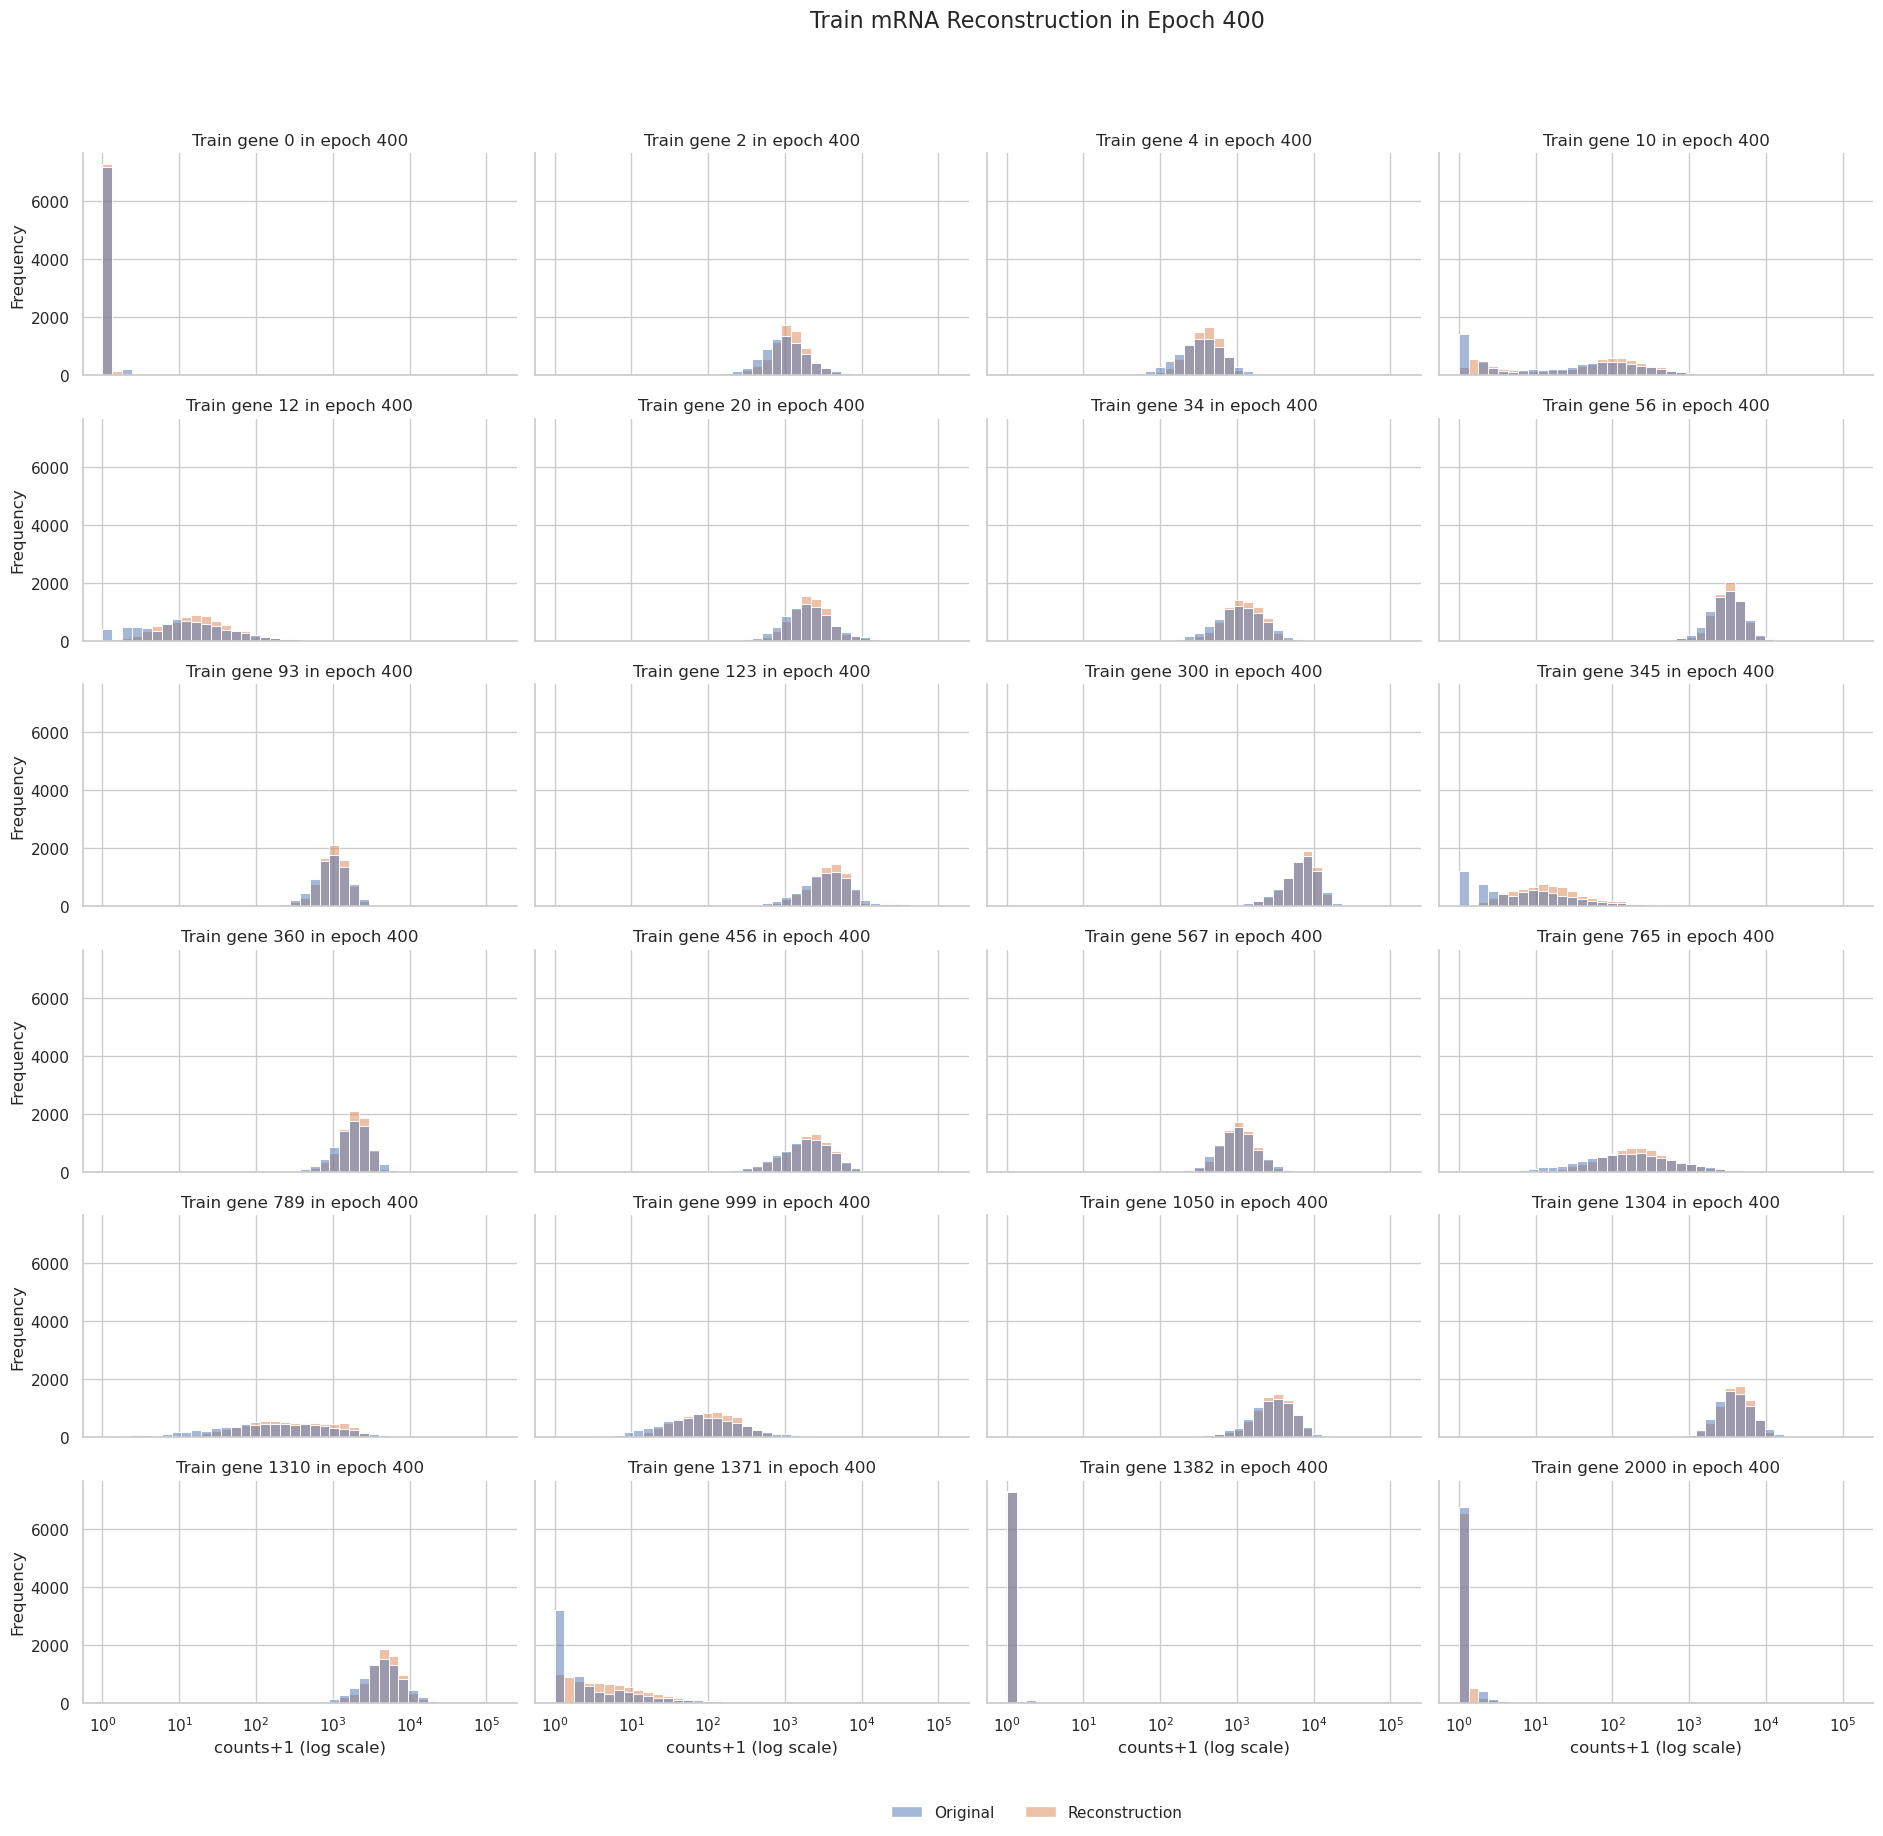

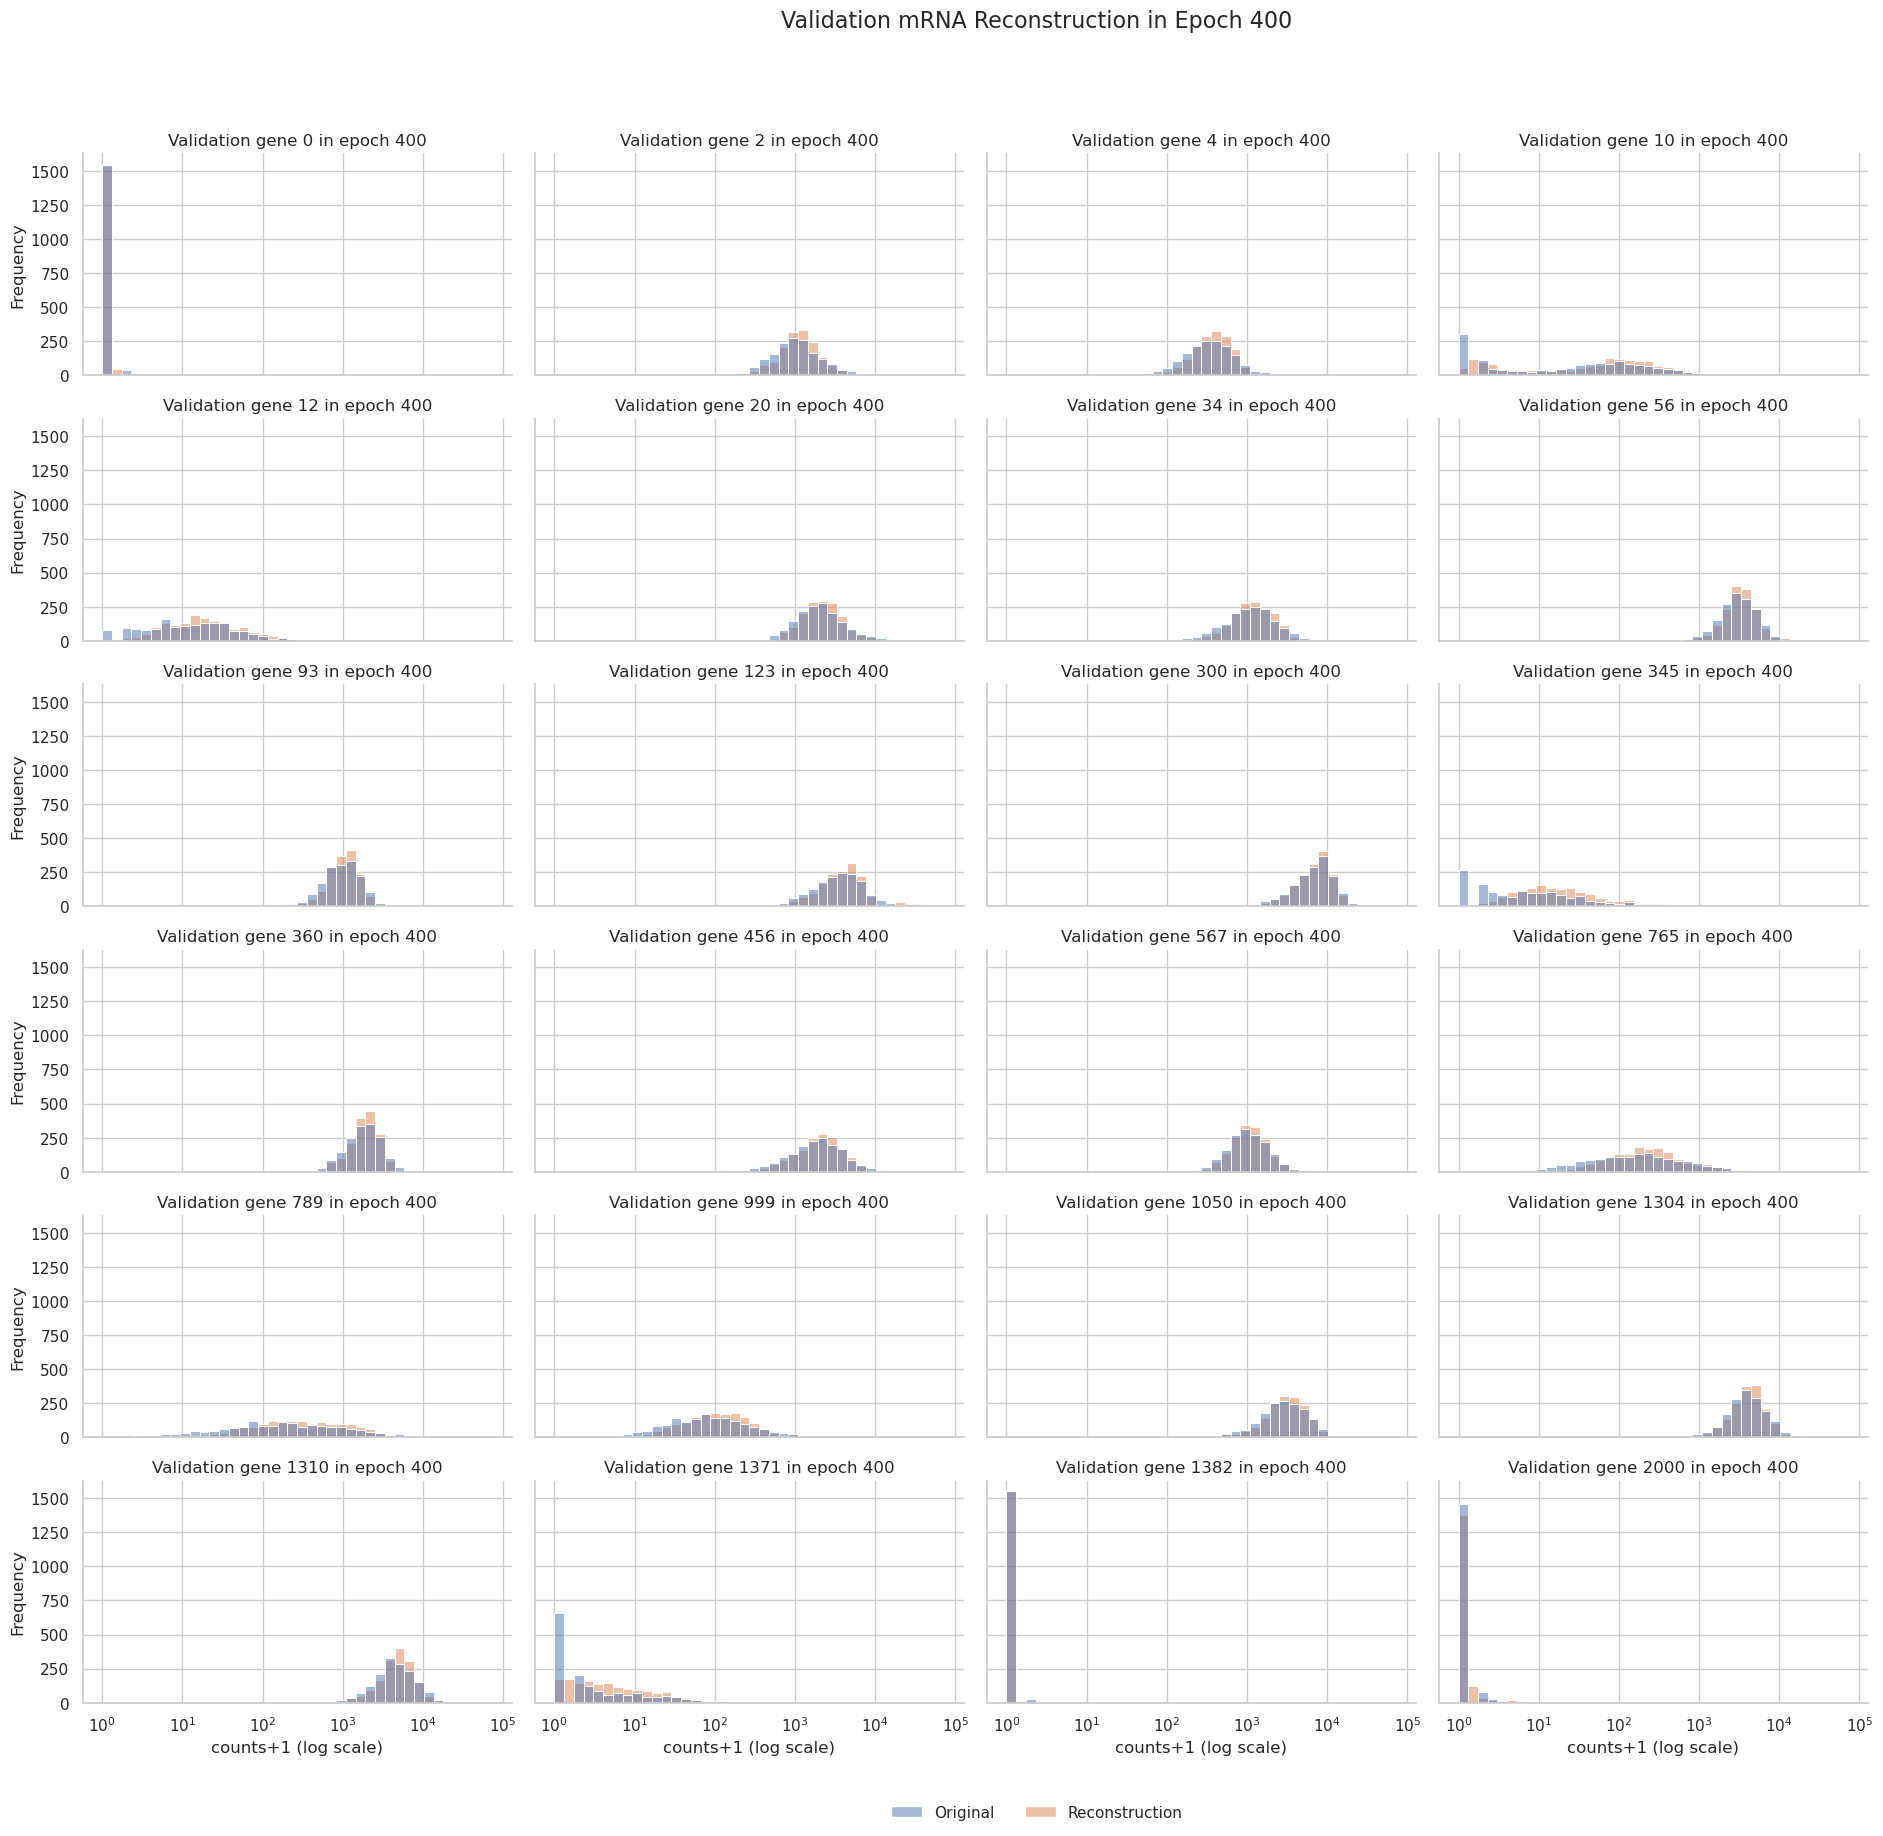

 51%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                      | 406/801 [38:42<1:31:32, 13.91s/it]

405 train_recon_mirna: 1.869125981745747 train_recon_mrna: 6.36237654787263 train_gmm: 2.2833485084063043 train_mse: 594646656.0 train_mae: 3888.783935546875 train_r2: 0.26387906074523926 train_spearman: 0.4787902235984802 train_pearson: 0.8582395911216736 train_msle: 2.0830435752868652
405 test_recon_mirna: 1.8678317926141763 test_recon_mrna: 6.408938128527074 test_gmm: 2.2810089930975757 test_mse: 301433984.0 test_mae: 2757.217529296875 test_r2: 0.34244370460510254 test_spearman: 0.44244617223739624 test_pearson: 0.8661045432090759 test_msle: 2.0665476322174072


 51%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 411/801 [39:09<44:48,  6.89s/it]

410 train_recon_mirna: 1.8683950679709802 train_recon_mrna: 6.360266989699127 train_gmm: 2.284658947013938 train_mse: 592989760.0 train_mae: 3877.27392578125 train_r2: 0.26593017578125 train_spearman: 0.4777776300907135 train_pearson: 0.8569534420967102 train_msle: 2.074418544769287
410 test_recon_mirna: 1.8672428795197789 test_recon_mrna: 6.40671073601136 test_gmm: 2.2823866644626407 test_mse: 304390432.0 test_mae: 2781.7119140625 test_r2: 0.3359944820404053 test_spearman: 0.44295772910118103 test_pearson: 0.8669245839118958 test_msle: 1.9934206008911133


 52%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 416/801 [39:31<30:03,  4.69s/it]

415 train_recon_mirna: 1.8678802545388695 train_recon_mrna: 6.358050686539218 train_gmm: 2.2859741063923877 train_mse: 593008704.0 train_mae: 3879.18359375 train_r2: 0.2659066915512085 train_spearman: 0.4779300093650818 train_pearson: 0.8570374250411987 train_msle: 2.081854820251465
415 test_recon_mirna: 1.866720200041723 test_recon_mrna: 6.407081290469228 test_gmm: 2.2842266475908612 test_mse: 302687040.0 test_mae: 2768.875244140625 test_r2: 0.3397102355957031 test_spearman: 0.4462258815765381 test_pearson: 0.8643620014190674 test_msle: 2.0360023975372314


 53%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 421/801 [39:51<26:30,  4.19s/it]

420 train_recon_mirna: 1.8672070863210324 train_recon_mrna: 6.356193408507426 train_gmm: 2.2871875944154163 train_mse: 591456512.0 train_mae: 3872.991943359375 train_r2: 0.26782816648483276 train_spearman: 0.47778093814849854 train_pearson: 0.85652756690979 train_msle: 2.0274696350097656
420 test_recon_mirna: 1.8664278241443095 test_recon_mrna: 6.4045756380227 test_gmm: 2.2856890819580538 test_mse: 303430848.0 test_mae: 2773.3974609375 test_r2: 0.3380877375602722 test_spearman: 0.44544392824172974 test_pearson: 0.8661515712738037 test_msle: 2.1005492210388184


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 426/801 [40:11<24:48,  3.97s/it]

425 train_recon_mirna: 1.8665672169150178 train_recon_mrna: 6.35392414465034 train_gmm: 2.288280724017923 train_mse: 591295744.0 train_mae: 3874.1083984375 train_r2: 0.2680271863937378 train_spearman: 0.4783986508846283 train_pearson: 0.858284592628479 train_msle: 2.0702919960021973
425 test_recon_mirna: 1.8662878058164611 test_recon_mrna: 6.403207356630007 test_gmm: 2.286505885603724 test_mse: 298858336.0 test_mae: 2751.07080078125 test_r2: 0.34806233644485474 test_spearman: 0.44575634598731995 test_pearson: 0.8672232031822205 test_msle: 2.0932974815368652


 54%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 431/801 [40:31<24:34,  3.98s/it]

430 train_recon_mirna: 1.8659074822688424 train_recon_mrna: 6.352431883971972 train_gmm: 2.2893314434568612 train_mse: 587646080.0 train_mae: 3855.041748046875 train_r2: 0.2725451588630676 train_spearman: 0.4756299555301666 train_pearson: 0.8571900129318237 train_msle: 2.145106554031372
430 test_recon_mirna: 1.864963958034504 test_recon_mrna: 6.405393537756799 test_gmm: 2.2873865150199095 test_mse: 296918784.0 test_mae: 2735.77685546875 test_r2: 0.35229331254959106 test_spearman: 0.4427225589752197 test_pearson: 0.8667248487472534 test_msle: 2.0746421813964844


 54%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 436/801 [40:51<24:20,  4.00s/it]

435 train_recon_mirna: 1.8651445186201285 train_recon_mrna: 6.350162179510083 train_gmm: 2.290410020344072 train_mse: 585497664.0 train_mae: 3847.735595703125 train_r2: 0.27520477771759033 train_spearman: 0.47636401653289795 train_pearson: 0.8570429682731628 train_msle: 2.081594705581665
435 test_recon_mirna: 1.8649572073747138 test_recon_mrna: 6.405955341535471 test_gmm: 2.286322772510345 test_mse: 297102752.0 test_mae: 2737.5048828125 test_r2: 0.35189199447631836 test_spearman: 0.4428615868091583 test_pearson: 0.8651898503303528 test_msle: 2.0374410152435303


 55%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                | 441/801 [41:11<23:34,  3.93s/it]

440 train_recon_mirna: 1.86462175805892 train_recon_mrna: 6.348382424198537 train_gmm: 2.291267351528001 train_mse: 587592064.0 train_mae: 3857.228759765625 train_r2: 0.2726120352745056 train_spearman: 0.48003485798835754 train_pearson: 0.8578222393989563 train_msle: 1.9896591901779175
440 test_recon_mirna: 1.8636406551272302 test_recon_mrna: 6.398362890626619 test_gmm: 2.2888234526272644 test_mse: 300136576.0 test_mae: 2757.141357421875 test_r2: 0.3452739119529724 test_spearman: 0.44489234685897827 test_pearson: 0.8627267479896545 test_msle: 1.9537626504898071


 56%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 446/801 [41:31<23:29,  3.97s/it]

445 train_recon_mirna: 1.8639529544089288 train_recon_mrna: 6.346939789177923 train_gmm: 2.2923923373493533 train_mse: 586962112.0 train_mae: 3853.205810546875 train_r2: 0.2733919024467468 train_spearman: 0.4790005385875702 train_pearson: 0.8557353019714355 train_msle: 2.0044047832489014
445 test_recon_mirna: 1.8639337350220218 test_recon_mrna: 6.402248183305473 test_gmm: 2.291056980988445 test_mse: 294286528.0 test_mae: 2719.783935546875 test_r2: 0.3580353856086731 test_spearman: 0.4433554410934448 test_pearson: 0.8652719855308533 test_msle: 2.003915548324585


 56%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 451/801 [41:50<23:11,  3.98s/it]

450 train_recon_mirna: 1.8634161197950962 train_recon_mrna: 6.3453323069546155 train_gmm: 2.293383874003705 train_mse: 584714432.0 train_mae: 3843.413818359375 train_r2: 0.27617424726486206 train_spearman: 0.4794307351112366 train_pearson: 0.8573532700538635 train_msle: 1.9293361902236938
450 test_recon_mirna: 1.8630509174879584 test_recon_mrna: 6.399626506165524 test_gmm: 2.2920089006870707 test_mse: 300322144.0 test_mae: 2758.2119140625 test_r2: 0.34486913681030273 test_spearman: 0.44418832659721375 test_pearson: 0.8607734441757202 test_msle: 1.904970407485962


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 456/801 [42:10<22:35,  3.93s/it]

455 train_recon_mirna: 1.8628245870740727 train_recon_mrna: 6.343194228093365 train_gmm: 2.294488545809184 train_mse: 581589696.0 train_mae: 3828.605712890625 train_r2: 0.2800424098968506 train_spearman: 0.4790956974029541 train_pearson: 0.8574308753013611 train_msle: 1.9061427116394043
455 test_recon_mirna: 1.8622973799107772 test_recon_mrna: 6.3962178734284185 test_gmm: 2.2929968467583737 test_mse: 295515680.0 test_mae: 2731.218994140625 test_r2: 0.35535407066345215 test_spearman: 0.44374194741249084 test_pearson: 0.8648849129676819 test_msle: 1.9308401346206665


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                           | 461/801 [42:30<22:36,  3.99s/it]

460 train_recon_mirna: 1.862244542722047 train_recon_mrna: 6.34169892046333 train_gmm: 2.2959967079402515 train_mse: 581388416.0 train_mae: 3828.650390625 train_r2: 0.28029167652130127 train_spearman: 0.4801204204559326 train_pearson: 0.8561499118804932 train_msle: 1.9712793827056885
460 test_recon_mirna: 1.862415212677415 test_recon_mrna: 6.393390977809732 test_gmm: 2.2948433108213617 test_mse: 294440032.0 test_mae: 2724.480712890625 test_r2: 0.35770052671432495 test_spearman: 0.44520917534828186 test_pearson: 0.8621085286140442 test_msle: 1.8810906410217285


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 466/801 [42:50<22:11,  3.97s/it]

465 train_recon_mirna: 1.8616524738564761 train_recon_mrna: 6.340416282603323 train_gmm: 2.296924746143408 train_mse: 581226880.0 train_mae: 3826.281982421875 train_r2: 0.28049159049987793 train_spearman: 0.4777793884277344 train_pearson: 0.8554548621177673 train_msle: 2.0213735103607178
465 test_recon_mirna: 1.8613817541701332 test_recon_mrna: 6.394995042135442 test_gmm: 2.2969385360346073 test_mse: 294065760.0 test_mae: 2722.688232421875 test_r2: 0.35851699113845825 test_spearman: 0.4454956650733948 test_pearson: 0.8619906306266785 test_msle: 1.9664268493652344


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 471/801 [43:10<21:35,  3.92s/it]

470 train_recon_mirna: 1.861091847440972 train_recon_mrna: 6.339276651504913 train_gmm: 2.2978866219823657 train_mse: 584953216.0 train_mae: 3845.145751953125 train_r2: 0.2758786678314209 train_spearman: 0.47736215591430664 train_pearson: 0.8550429344177246 train_msle: 2.0221073627471924
470 test_recon_mirna: 1.8608743167175037 test_recon_mrna: 6.39797357351721 test_gmm: 2.2968877255060316 test_mse: 296814112.0 test_mae: 2737.78466796875 test_r2: 0.3525216579437256 test_spearman: 0.44445231556892395 test_pearson: 0.8635931611061096 test_msle: 1.9518893957138062


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                        | 476/801 [43:29<21:28,  3.97s/it]

475 train_recon_mirna: 1.8608661181901751 train_recon_mrna: 6.337287090354549 train_gmm: 2.298899413539785 train_mse: 577008256.0 train_mae: 3811.4912109375 train_r2: 0.28571391105651855 train_spearman: 0.47839856147766113 train_pearson: 0.8580188751220703 train_msle: 2.0071821212768555
475 test_recon_mirna: 1.860695882313549 test_recon_mrna: 6.3914032757944295 test_gmm: 2.299450233740631 test_mse: 295114272.0 test_mae: 2727.00439453125 test_r2: 0.3562297224998474 test_spearman: 0.44351664185523987 test_pearson: 0.8588658571243286 test_msle: 1.9745559692382812


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 481/801 [43:49<21:09,  3.97s/it]

480 train_recon_mirna: 1.8602796834910025 train_recon_mrna: 6.335943421950957 train_gmm: 2.300045133182582 train_mse: 579428160.0 train_mae: 3822.291015625 train_r2: 0.2827181816101074 train_spearman: 0.47612515091896057 train_pearson: 0.8563424944877625 train_msle: 1.9998124837875366
480 test_recon_mirna: 1.860740836885852 test_recon_mrna: 6.393095521418358 test_gmm: 2.298380452524789 test_mse: 293691232.0 test_mae: 2715.027587890625 test_r2: 0.35933393239974976 test_spearman: 0.4418849050998688 test_pearson: 0.8593022227287292 test_msle: 1.987356424331665


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 486/801 [44:09<20:44,  3.95s/it]

485 train_recon_mirna: 1.859668339247576 train_recon_mrna: 6.33490637381821 train_gmm: 2.3009468477796107 train_mse: 580525824.0 train_mae: 3826.93896484375 train_r2: 0.2813594341278076 train_spearman: 0.478080153465271 train_pearson: 0.8564493060112 train_msle: 1.8978865146636963
485 test_recon_mirna: 1.860353238110198 test_recon_mrna: 6.389433640345788 test_gmm: 2.3011117014268425 test_mse: 292983392.0 test_mae: 2712.1708984375 test_r2: 0.360878050327301 test_spearman: 0.4467892348766327 test_pearson: 0.8603547811508179 test_msle: 1.838425636291504


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 491/801 [44:29<20:40,  4.00s/it]

490 train_recon_mirna: 1.8592009358691288 train_recon_mrna: 6.333375912703526 train_gmm: 2.3022369070319817 train_mse: 579330944.0 train_mae: 3824.177001953125 train_r2: 0.2828386425971985 train_spearman: 0.47631996870040894 train_pearson: 0.8583229184150696 train_msle: 1.9602892398834229
490 test_recon_mirna: 1.8598110154720493 test_recon_mrna: 6.389569693299623 test_gmm: 2.301231026872853 test_mse: 292723264.0 test_mae: 2713.513916015625 test_r2: 0.3614455461502075 test_spearman: 0.44214317202568054 test_pearson: 0.8626601099967957 test_msle: 1.8847105503082275


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 496/801 [44:49<20:10,  3.97s/it]

495 train_recon_mirna: 1.858748294543823 train_recon_mrna: 6.332302856990669 train_gmm: 2.3032145247631055 train_mse: 577420224.0 train_mae: 3815.354736328125 train_r2: 0.28520387411117554 train_spearman: 0.47572141885757446 train_pearson: 0.858853816986084 train_msle: 1.9535921812057495
495 test_recon_mirna: 1.859351575210528 test_recon_mrna: 6.391593180405805 test_gmm: 2.3038639333082838 test_mse: 296594016.0 test_mae: 2736.11474609375 test_r2: 0.35300177335739136 test_spearman: 0.44458678364753723 test_pearson: 0.8607790470123291 test_msle: 1.9230566024780273


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 501/801 [45:08<19:32,  3.91s/it]

500 train_recon_mirna: 1.8582207706637175 train_recon_mrna: 6.330353824703536 train_gmm: 2.304335853212189 train_mse: 576334272.0 train_mae: 3811.189697265625 train_r2: 0.2865481972694397 train_spearman: 0.4788394272327423 train_pearson: 0.8591415286064148 train_msle: 1.8836532831192017
500 test_recon_mirna: 1.8585357627967822 test_recon_mrna: 6.383463605091304 test_gmm: 2.3037290764927194 test_mse: 289458816.0 test_mae: 2694.371826171875 test_r2: 0.36856669187545776 test_spearman: 0.4409322738647461 test_pearson: 0.8638222217559814 test_msle: 1.8975918292999268


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 506/801 [45:28<19:35,  3.98s/it]

505 train_recon_mirna: 1.8578811070810122 train_recon_mrna: 6.329894175606487 train_gmm: 2.305104486176276 train_mse: 576749568.0 train_mae: 3815.318359375 train_r2: 0.28603416681289673 train_spearman: 0.4808926284313202 train_pearson: 0.8591858744621277 train_msle: 1.8504550457000732
505 test_recon_mirna: 1.8588559321249318 test_recon_mrna: 6.385436372921906 test_gmm: 2.3059474089680276 test_mse: 288165280.0 test_mae: 2680.898193359375 test_r2: 0.37138843536376953 test_spearman: 0.44363176822662354 test_pearson: 0.8603635430335999 test_msle: 1.8393665552139282


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                | 511/801 [45:48<19:09,  3.96s/it]

510 train_recon_mirna: 1.8573022414205633 train_recon_mrna: 6.328178653696509 train_gmm: 2.306325614007301 train_mse: 576831104.0 train_mae: 3815.598876953125 train_r2: 0.28593313694000244 train_spearman: 0.4757098853588104 train_pearson: 0.8596512079238892 train_msle: 1.8736859560012817
510 test_recon_mirna: 1.8578776313300358 test_recon_mrna: 6.38423769893829 test_gmm: 2.3059284388907324 test_mse: 291439616.0 test_mae: 2707.08251953125 test_r2: 0.3642457127571106 test_spearman: 0.4392613172531128 test_pearson: 0.861187756061554 test_msle: 1.904521107673645


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 516/801 [46:08<18:38,  3.93s/it]

515 train_recon_mirna: 1.8569577174137832 train_recon_mrna: 6.327163310434153 train_gmm: 2.3071800179866266 train_mse: 576039232.0 train_mae: 3809.798828125 train_r2: 0.2869133949279785 train_spearman: 0.47753438353538513 train_pearson: 0.8591607213020325 train_msle: 1.9387521743774414
515 test_recon_mirna: 1.857863884093563 test_recon_mrna: 6.385284341656051 test_gmm: 2.306839749814569 test_mse: 286123968.0 test_mae: 2671.65966796875 test_r2: 0.3758414387702942 test_spearman: 0.44105374813079834 test_pearson: 0.8631711602210999 test_msle: 1.918033480644226


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 521/801 [46:28<18:36,  3.99s/it]

520 train_recon_mirna: 1.8564239364478923 train_recon_mrna: 6.325864498988652 train_gmm: 2.308105248229564 train_mse: 572083200.0 train_mae: 3789.305419921875 train_r2: 0.29181069135665894 train_spearman: 0.47747570276260376 train_pearson: 0.8572197556495667 train_msle: 1.8979463577270508
520 test_recon_mirna: 1.85748687420998 test_recon_mrna: 6.385862060466299 test_gmm: 2.3085533318409395 test_mse: 285640704.0 test_mae: 2665.517578125 test_r2: 0.3768956661224365 test_spearman: 0.4433039128780365 test_pearson: 0.8590707778930664 test_msle: 1.8842759132385254


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 526/801 [46:47<18:07,  3.96s/it]

525 train_recon_mirna: 1.8559363723816147 train_recon_mrna: 6.324584745395464 train_gmm: 2.308785125801845 train_mse: 569518080.0 train_mae: 3777.18212890625 train_r2: 0.2949860692024231 train_spearman: 0.47846823930740356 train_pearson: 0.8585532903671265 train_msle: 1.931329369544983
525 test_recon_mirna: 1.8565796723283743 test_recon_mrna: 6.379173744716122 test_gmm: 2.308274895634076 test_mse: 290053888.0 test_mae: 2699.8427734375 test_r2: 0.3672686219215393 test_spearman: 0.44459646940231323 test_pearson: 0.8643983006477356 test_msle: 1.8978544473648071


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 531/801 [47:07<17:42,  3.94s/it]

530 train_recon_mirna: 1.8554999775790342 train_recon_mrna: 6.3235968890942065 train_gmm: 2.309665905658809 train_mse: 575190464.0 train_mae: 3802.969970703125 train_r2: 0.2879641056060791 train_spearman: 0.47750839591026306 train_pearson: 0.8572338223457336 train_msle: 1.8501882553100586
530 test_recon_mirna: 1.8574894249950007 test_recon_mrna: 6.380491465034344 test_gmm: 2.3102717631314413 test_mse: 290618080.0 test_mae: 2700.302001953125 test_r2: 0.3660377860069275 test_spearman: 0.4441588521003723 test_pearson: 0.8622339367866516 test_msle: 1.763090968132019


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 536/801 [47:27<17:43,  4.01s/it]

535 train_recon_mirna: 1.8550421721177133 train_recon_mrna: 6.322612533906488 train_gmm: 2.3106409473845426 train_mse: 576033088.0 train_mae: 3808.85791015625 train_r2: 0.28692102432250977 train_spearman: 0.47594669461250305 train_pearson: 0.8570842146873474 train_msle: 1.877286434173584
535 test_recon_mirna: 1.8566472753642733 test_recon_mrna: 6.383368146542067 test_gmm: 2.3100584717559336 test_mse: 290541376.0 test_mae: 2698.456298828125 test_r2: 0.36620521545410156 test_spearman: 0.4423938989639282 test_pearson: 0.8573475480079651 test_msle: 1.8730041980743408


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 541/801 [47:47<17:08,  3.96s/it]

540 train_recon_mirna: 1.8545953498718575 train_recon_mrna: 6.321530350895698 train_gmm: 2.3114243731861785 train_mse: 573819008.0 train_mae: 3801.3037109375 train_r2: 0.2896619439125061 train_spearman: 0.4770905375480652 train_pearson: 0.8603368997573853 train_msle: 1.8396532535552979
540 test_recon_mirna: 1.8557353431989148 test_recon_mrna: 6.383288824505959 test_gmm: 2.312413246969667 test_mse: 287844640.0 test_mae: 2686.126953125 test_r2: 0.37208789587020874 test_spearman: 0.44141343235969543 test_pearson: 0.8612915873527527 test_msle: 1.8592360019683838


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 546/801 [48:07<16:44,  3.94s/it]

545 train_recon_mirna: 1.8541946226276254 train_recon_mrna: 6.32070151225668 train_gmm: 2.3125541761539457 train_mse: 570468736.0 train_mae: 3783.076171875 train_r2: 0.2938092350959778 train_spearman: 0.47555336356163025 train_pearson: 0.8585038781166077 train_msle: 1.8528281450271606
545 test_recon_mirna: 1.8550981002023192 test_recon_mrna: 6.376995394544232 test_gmm: 2.312597976484424 test_mse: 281790720.0 test_mae: 2652.7978515625 test_r2: 0.3852940797805786 test_spearman: 0.44097012281417847 test_pearson: 0.8644993305206299 test_msle: 1.848677158355713


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 551/801 [48:27<16:43,  4.01s/it]

550 train_recon_mirna: 1.853895879580191 train_recon_mrna: 6.31977908576849 train_gmm: 2.3132307263178693 train_mse: 566169344.0 train_mae: 3762.982177734375 train_r2: 0.29913151264190674 train_spearman: 0.4744899868965149 train_pearson: 0.8603436350822449 train_msle: 1.9097346067428589
550 test_recon_mirna: 1.8550206219155272 test_recon_mrna: 6.376312851679088 test_gmm: 2.3144584469911385 test_mse: 279066624.0 test_mae: 2638.5703125 test_r2: 0.39123648405075073 test_spearman: 0.4424811601638794 test_pearson: 0.8625959157943726 test_msle: 1.844319462776184


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 556/801 [48:46<16:09,  3.96s/it]

555 train_recon_mirna: 1.8533162680693316 train_recon_mrna: 6.318166787395771 train_gmm: 2.314149156363952 train_mse: 566471232.0 train_mae: 3764.24658203125 train_r2: 0.29875779151916504 train_spearman: 0.47569435834884644 train_pearson: 0.8595067858695984 train_msle: 1.897446870803833
555 test_recon_mirna: 1.8546295561938808 test_recon_mrna: 6.378921081724763 test_gmm: 2.3155977800739773 test_mse: 283297408.0 test_mae: 2662.549072265625 test_r2: 0.382007360458374 test_spearman: 0.44095301628112793 test_pearson: 0.8649470806121826 test_msle: 1.8968958854675293


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 561/801 [49:06<15:42,  3.93s/it]

560 train_recon_mirna: 1.8529799773420148 train_recon_mrna: 6.317257595997974 train_gmm: 2.3150607208737917 train_mse: 567013440.0 train_mae: 3769.079345703125 train_r2: 0.29808664321899414 train_spearman: 0.4764172434806824 train_pearson: 0.8605608940124512 train_msle: 1.8784574270248413
560 test_recon_mirna: 1.8543986595195567 test_recon_mrna: 6.378233666265458 test_gmm: 2.3182437246252343 test_mse: 279823424.0 test_mae: 2644.65478515625 test_r2: 0.38958561420440674 test_spearman: 0.44224151968955994 test_pearson: 0.8647376894950867 test_msle: 1.8265992403030396


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 566/801 [49:26<15:39,  4.00s/it]

565 train_recon_mirna: 1.8524968170988683 train_recon_mrna: 6.316276911387182 train_gmm: 2.31599183492866 train_mse: 566690048.0 train_mae: 3768.379150390625 train_r2: 0.2984868884086609 train_spearman: 0.4763554334640503 train_pearson: 0.8617982864379883 train_msle: 1.8543367385864258
565 test_recon_mirna: 1.8548055266070118 test_recon_mrna: 6.379467033752301 test_gmm: 2.3172120360565662 test_mse: 285479072.0 test_mae: 2678.09375 test_r2: 0.3772481679916382 test_spearman: 0.4404577612876892 test_pearson: 0.8667569756507874 test_msle: 1.934295892715454


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 571/801 [49:46<15:10,  3.96s/it]

570 train_recon_mirna: 1.8521643992153043 train_recon_mrna: 6.315298097652164 train_gmm: 2.316780855415433 train_mse: 563423744.0 train_mae: 3749.341552734375 train_r2: 0.30253034830093384 train_spearman: 0.4756178855895996 train_pearson: 0.859926164150238 train_msle: 1.8724830150604248
570 test_recon_mirna: 1.85409705932773 test_recon_mrna: 6.37661817981967 test_gmm: 2.317809052142704 test_mse: 283209856.0 test_mae: 2666.31982421875 test_r2: 0.3821983337402344 test_spearman: 0.4401225745677948 test_pearson: 0.86568284034729 test_msle: 1.7846325635910034


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 576/801 [50:05<14:44,  3.93s/it]

575 train_recon_mirna: 1.851852282512169 train_recon_mrna: 6.3143523360558165 train_gmm: 2.317555246413129 train_mse: 567177728.0 train_mae: 3771.33935546875 train_r2: 0.29788321256637573 train_spearman: 0.47701725363731384 train_pearson: 0.8604969382286072 train_msle: 1.8833457231521606
575 test_recon_mirna: 1.8537337581054207 test_recon_mrna: 6.375813046915077 test_gmm: 2.3184910980929887 test_mse: 283849344.0 test_mae: 2672.5185546875 test_r2: 0.38080334663391113 test_spearman: 0.4420778751373291 test_pearson: 0.8671232461929321 test_msle: 1.8539457321166992


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 581/801 [50:26<14:43,  4.02s/it]

580 train_recon_mirna: 1.8513456610381696 train_recon_mrna: 6.313535234450865 train_gmm: 2.3186121044876136 train_mse: 565789632.0 train_mae: 3762.96728515625 train_r2: 0.29960155487060547 train_spearman: 0.4773092567920685 train_pearson: 0.8594939112663269 train_msle: 1.8311185836791992
580 test_recon_mirna: 1.8529153949066541 test_recon_mrna: 6.377619513739782 test_gmm: 2.319497732130309 test_mse: 281921664.0 test_mae: 2656.34033203125 test_r2: 0.38500839471817017 test_spearman: 0.44340628385543823 test_pearson: 0.8684684634208679 test_msle: 1.8216627836227417


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 586/801 [50:45<14:10,  3.96s/it]

585 train_recon_mirna: 1.8510046266195987 train_recon_mrna: 6.31266224043217 train_gmm: 2.319237863077914 train_mse: 563052672.0 train_mae: 3747.408935546875 train_r2: 0.302989661693573 train_spearman: 0.4751587212085724 train_pearson: 0.8589335083961487 train_msle: 1.8955527544021606
585 test_recon_mirna: 1.8532885665579566 test_recon_mrna: 6.376767853889 test_gmm: 2.321563076421963 test_mse: 272644704.0 test_mae: 2600.232666015625 test_r2: 0.40524542331695557 test_spearman: 0.4402036964893341 test_pearson: 0.86759352684021 test_msle: 1.8292253017425537


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 591/801 [51:05<13:46,  3.93s/it]

590 train_recon_mirna: 1.850594602071079 train_recon_mrna: 6.312049159186062 train_gmm: 2.320192830910026 train_mse: 563635264.0 train_mae: 3755.22802734375 train_r2: 0.30226844549179077 train_spearman: 0.47479313611984253 train_pearson: 0.8615344166755676 train_msle: 1.8927552700042725
590 test_recon_mirna: 1.852106800876984 test_recon_mrna: 6.374281486157672 test_gmm: 2.3206313391166655 test_mse: 279540864.0 test_mae: 2649.541015625 test_r2: 0.39020198583602905 test_spearman: 0.44190436601638794 test_pearson: 0.8713133335113525 test_msle: 1.9018863439559937


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 596/801 [51:25<13:37,  3.99s/it]

595 train_recon_mirna: 1.8502554601704475 train_recon_mrna: 6.311280164846932 train_gmm: 2.321084595951676 train_mse: 560381248.0 train_mae: 3741.796630859375 train_r2: 0.3062966465950012 train_spearman: 0.4770755469799042 train_pearson: 0.8632003664970398 train_msle: 1.8572282791137695
595 test_recon_mirna: 1.8522787498256401 test_recon_mrna: 6.374430543242675 test_gmm: 2.322213823269636 test_mse: 273138400.0 test_mae: 2609.309326171875 test_r2: 0.4041684865951538 test_spearman: 0.442527711391449 test_pearson: 0.8688326478004456 test_msle: 1.8564412593841553


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 600/801 [51:41<13:07,  3.92s/it]

600 train_recon_mirna: 1.849896589390118 train_recon_mrna: 6.310135619310348 train_gmm: 2.3217049166713712 train_mse: 561629824.0 train_mae: 3748.2138671875 train_r2: 0.30475109815597534 train_spearman: 0.47629594802856445 train_pearson: 0.8621517419815063 train_msle: 1.8154990673065186
600 test_recon_mirna: 1.8520522217925803 test_recon_mrna: 6.371248675975368 test_gmm: 2.322471215500078 test_mse: 275907072.0 test_mae: 2623.153564453125 test_r2: 0.398128867149353 test_spearman: 0.44191405177116394 test_pearson: 0.8655779957771301 test_msle: 1.8186604976654053


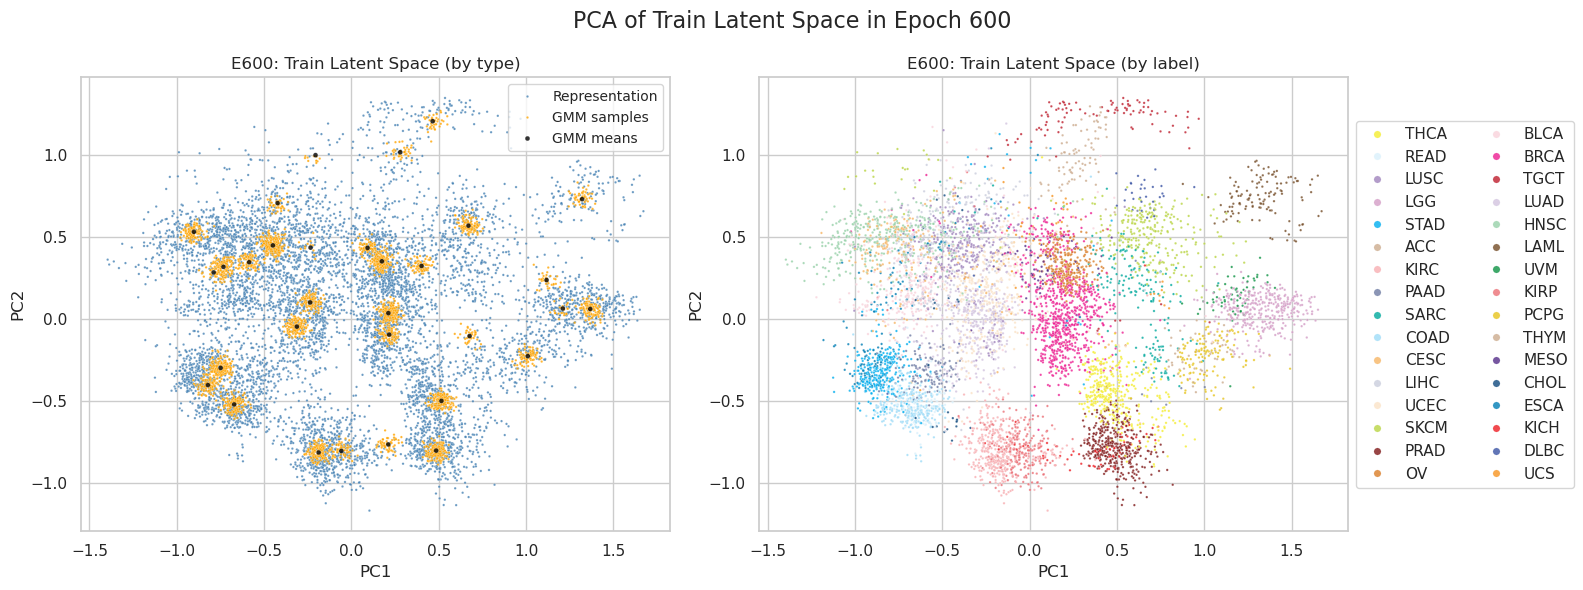

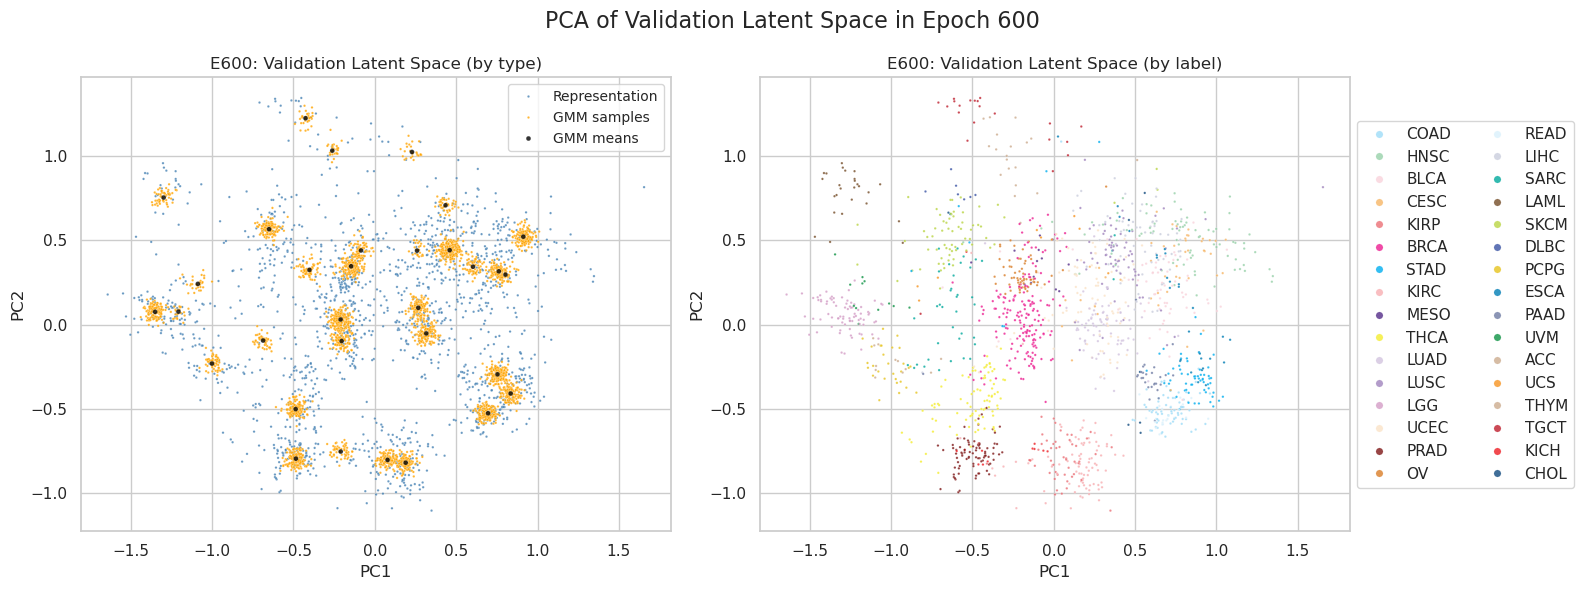

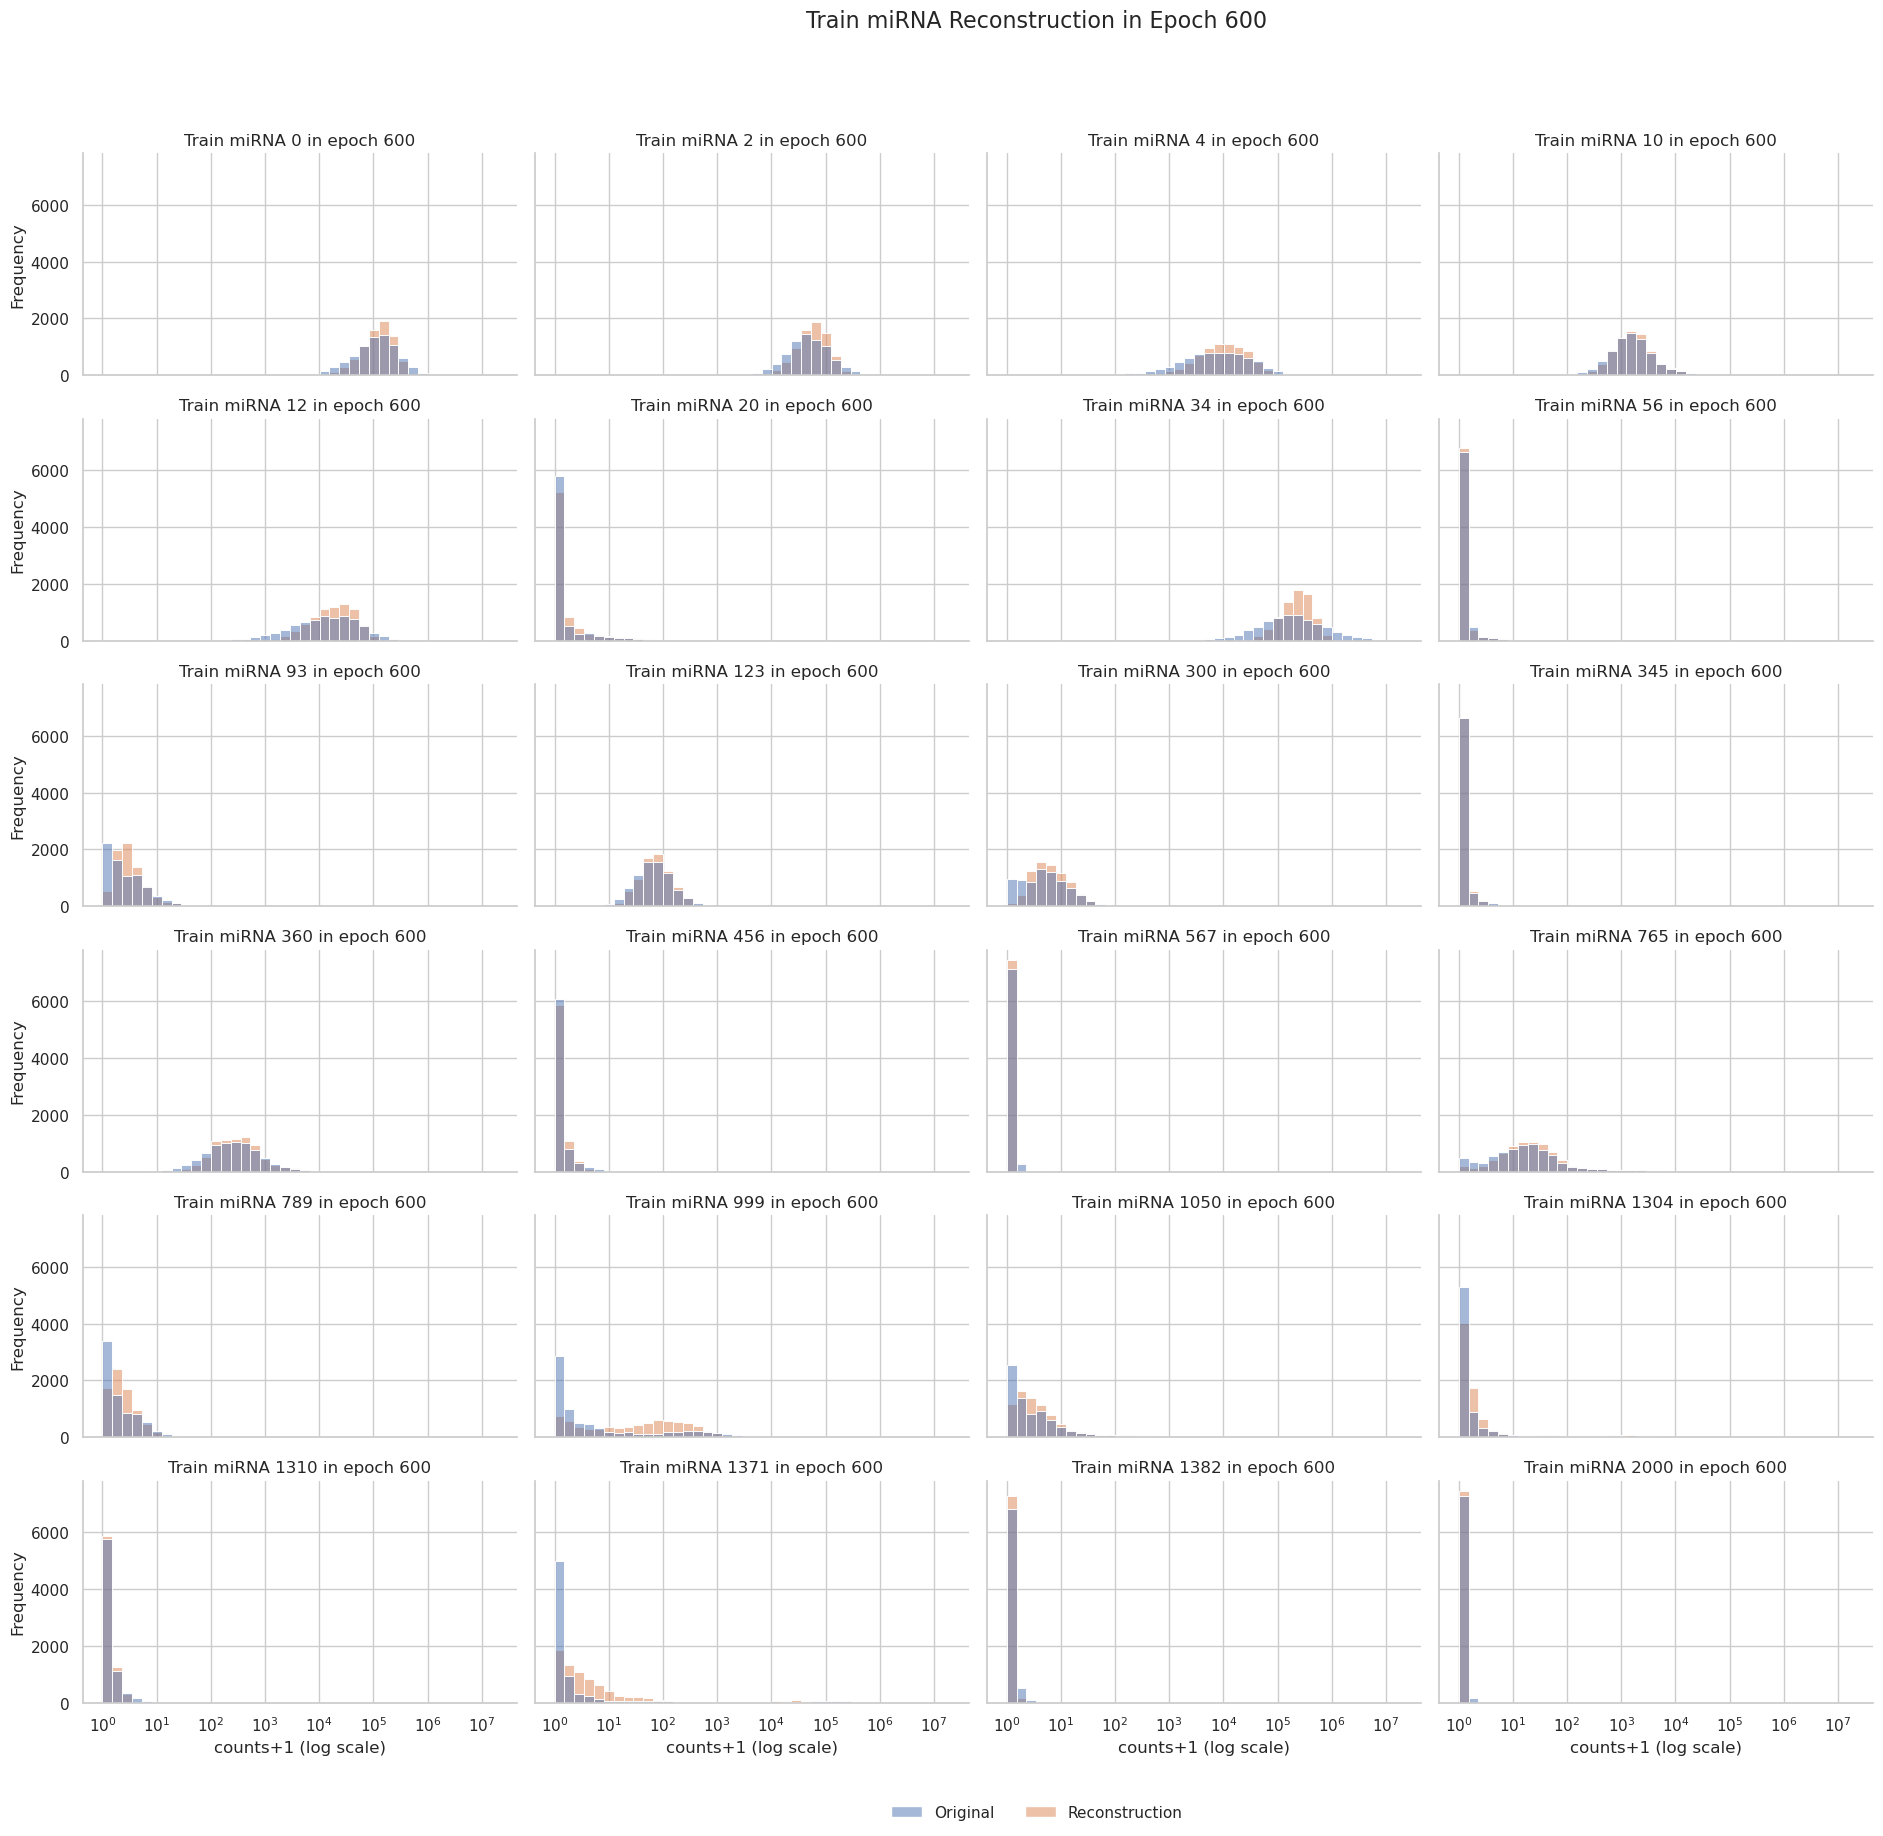

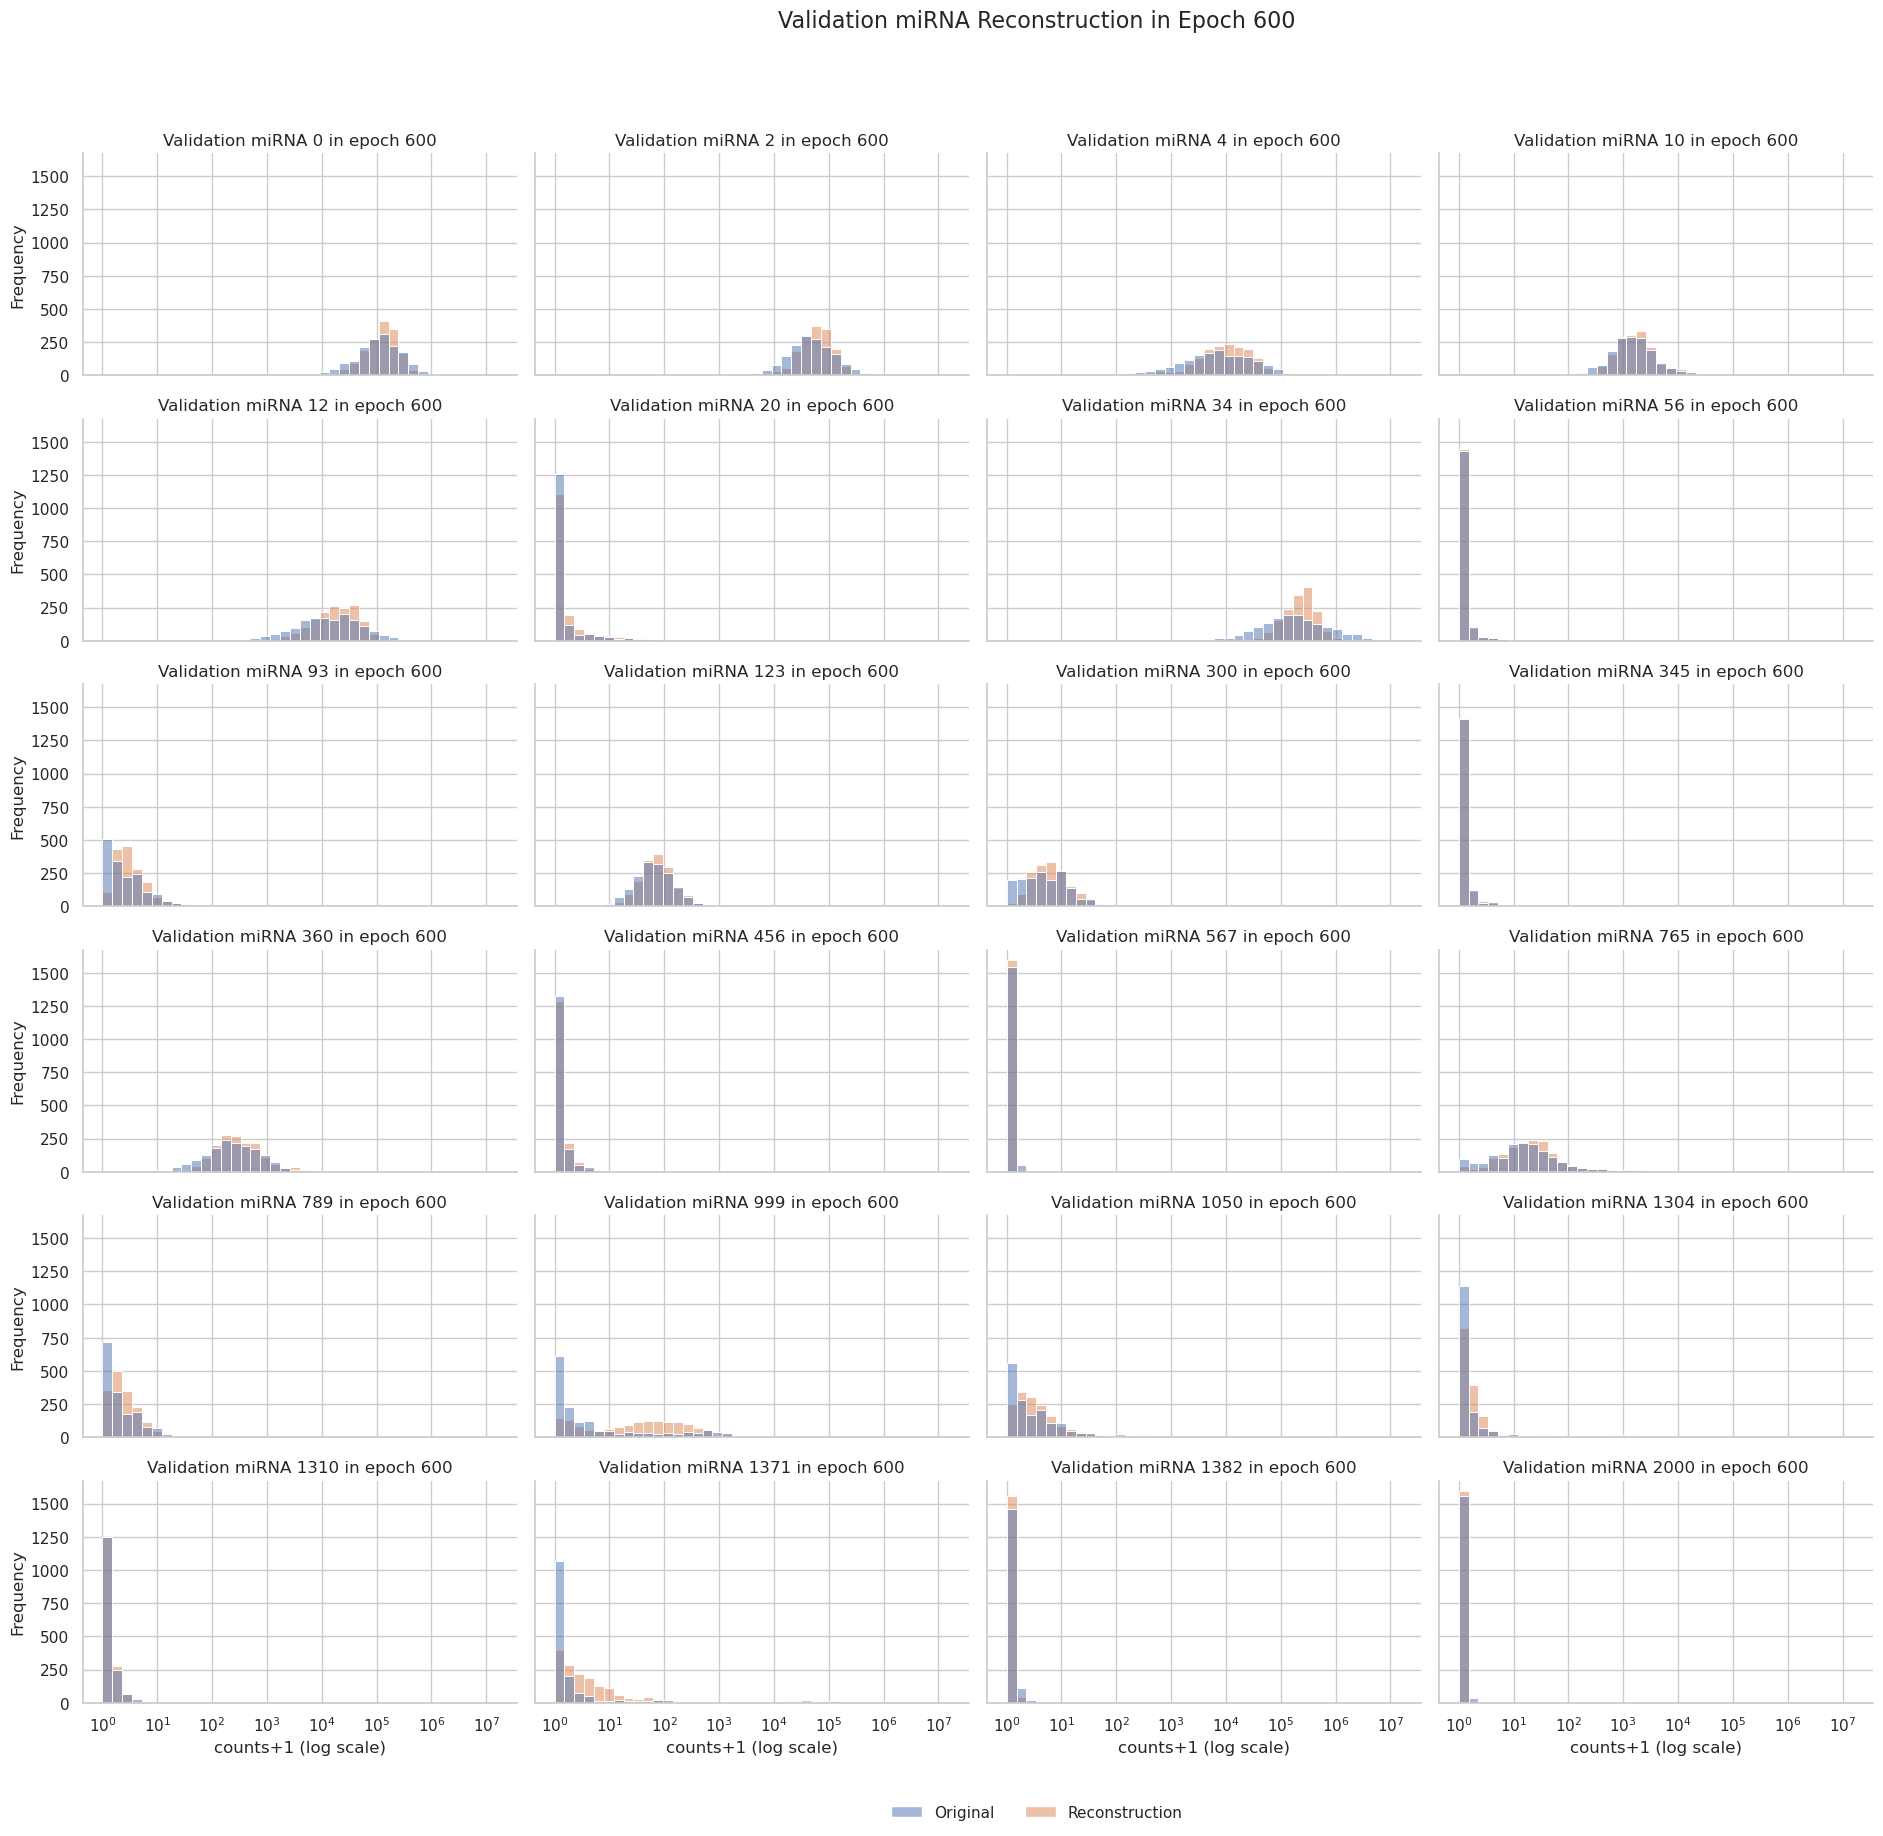

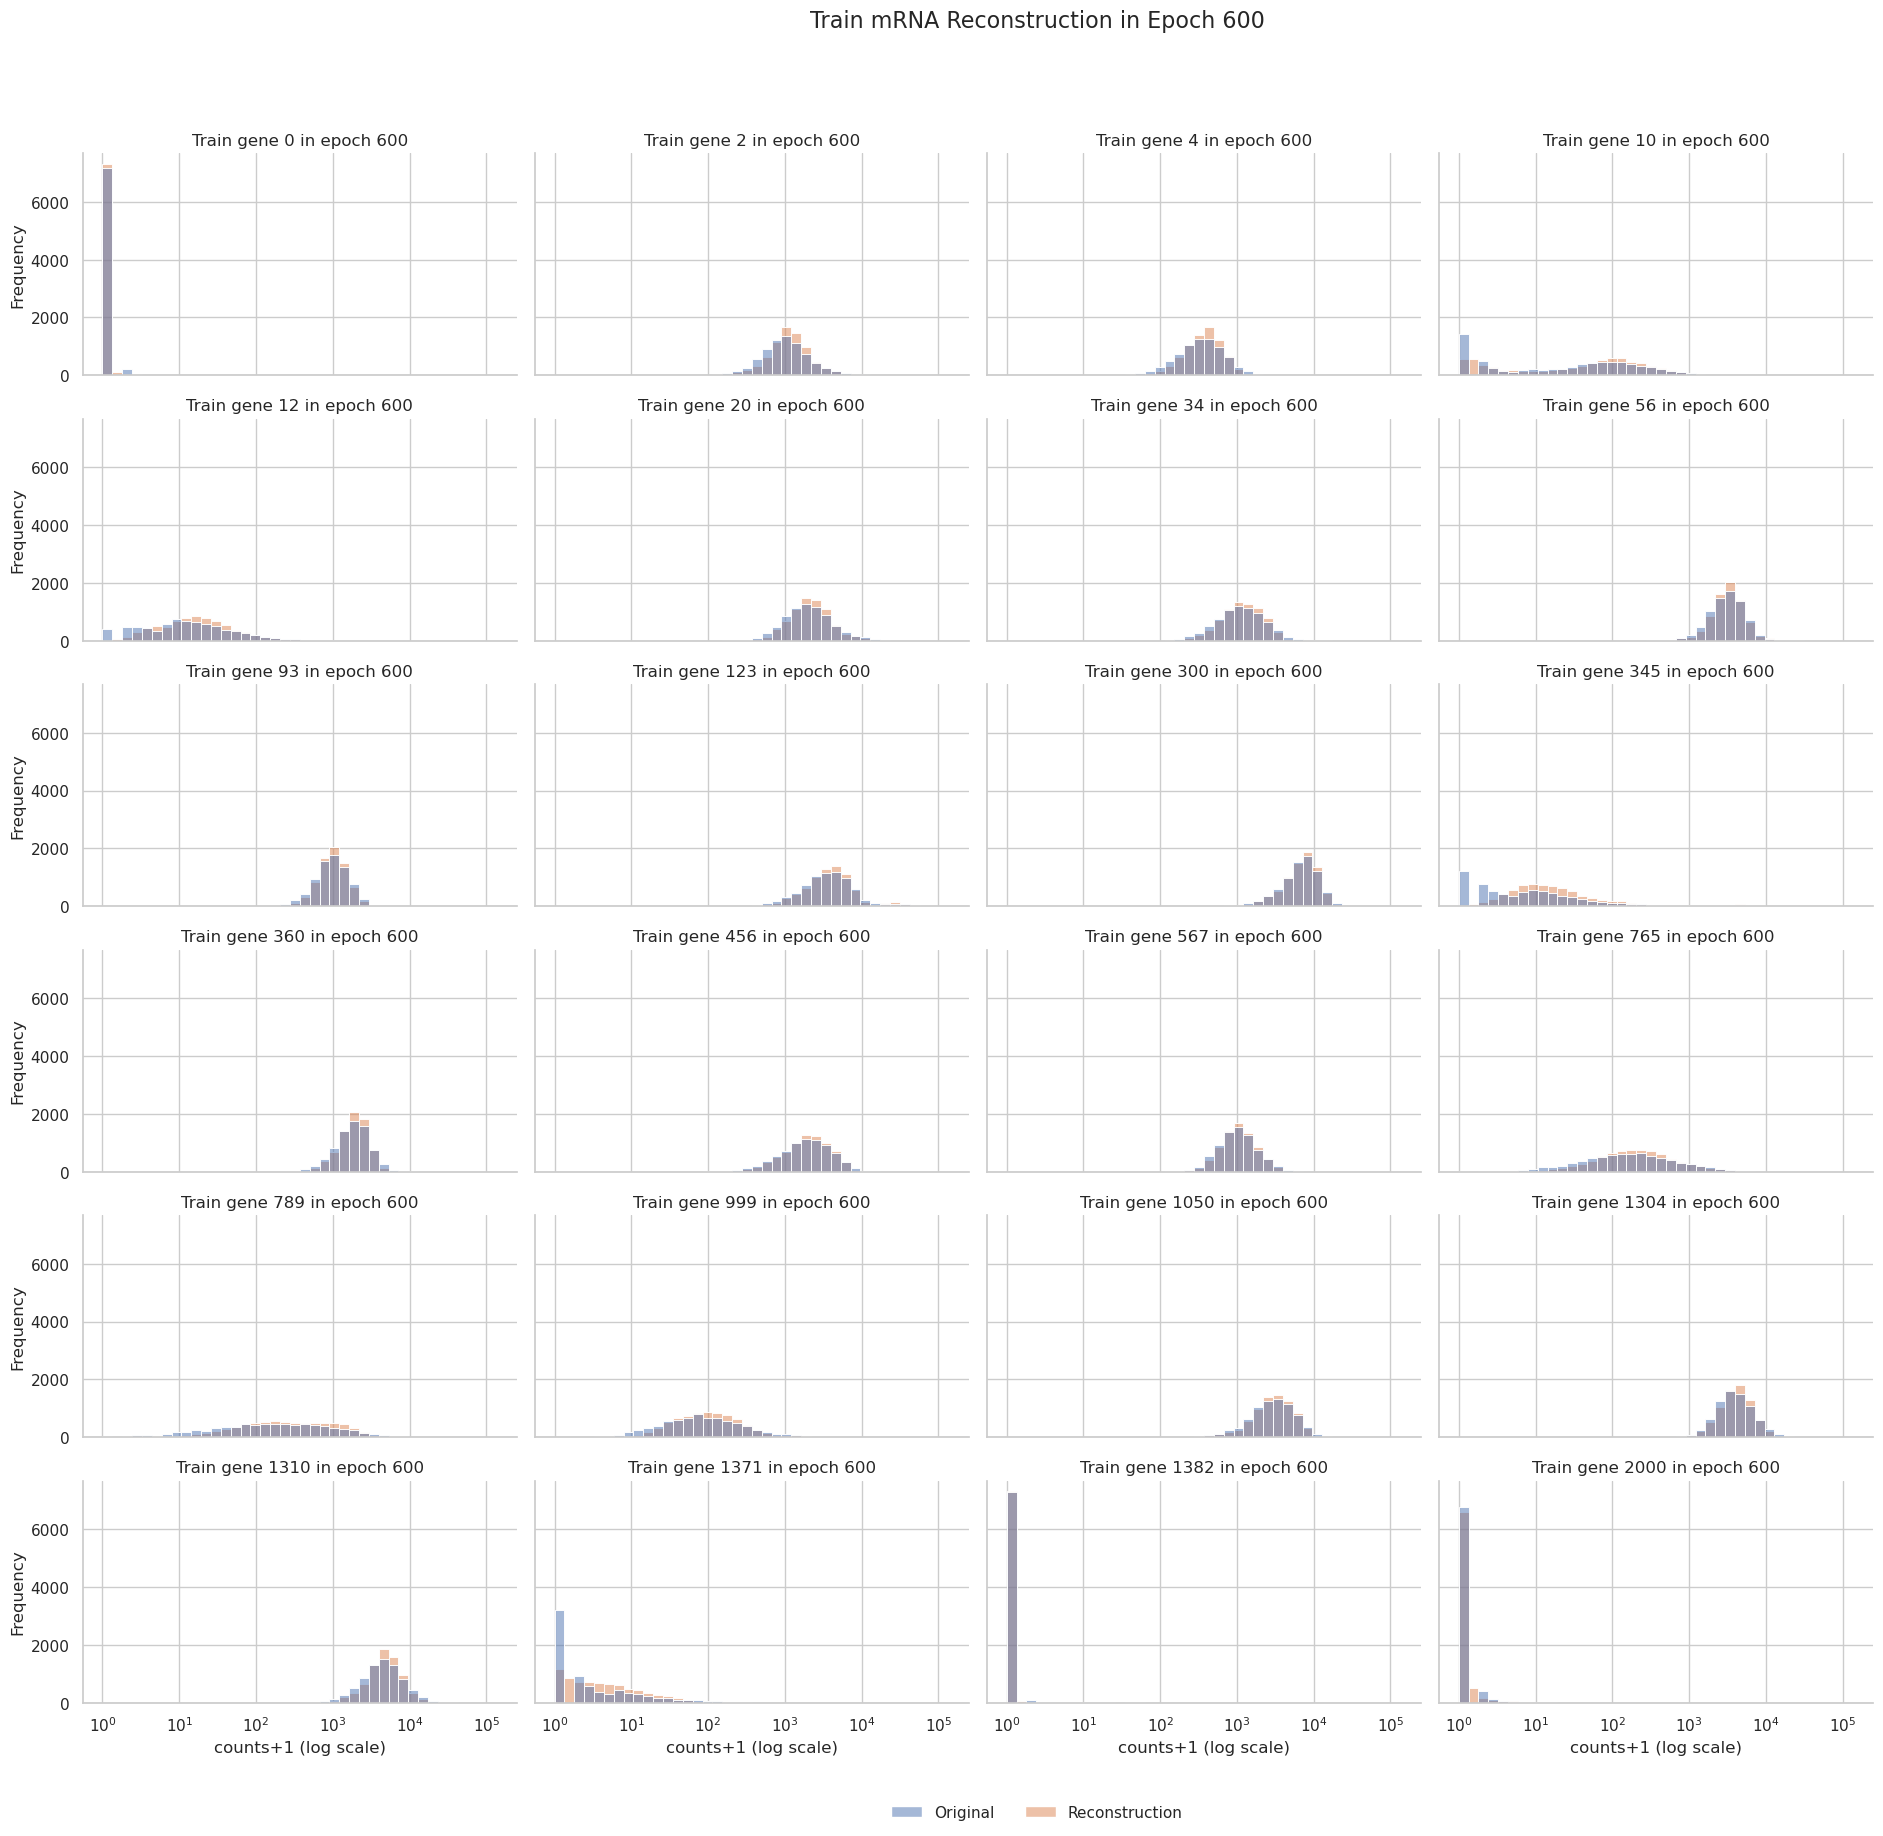

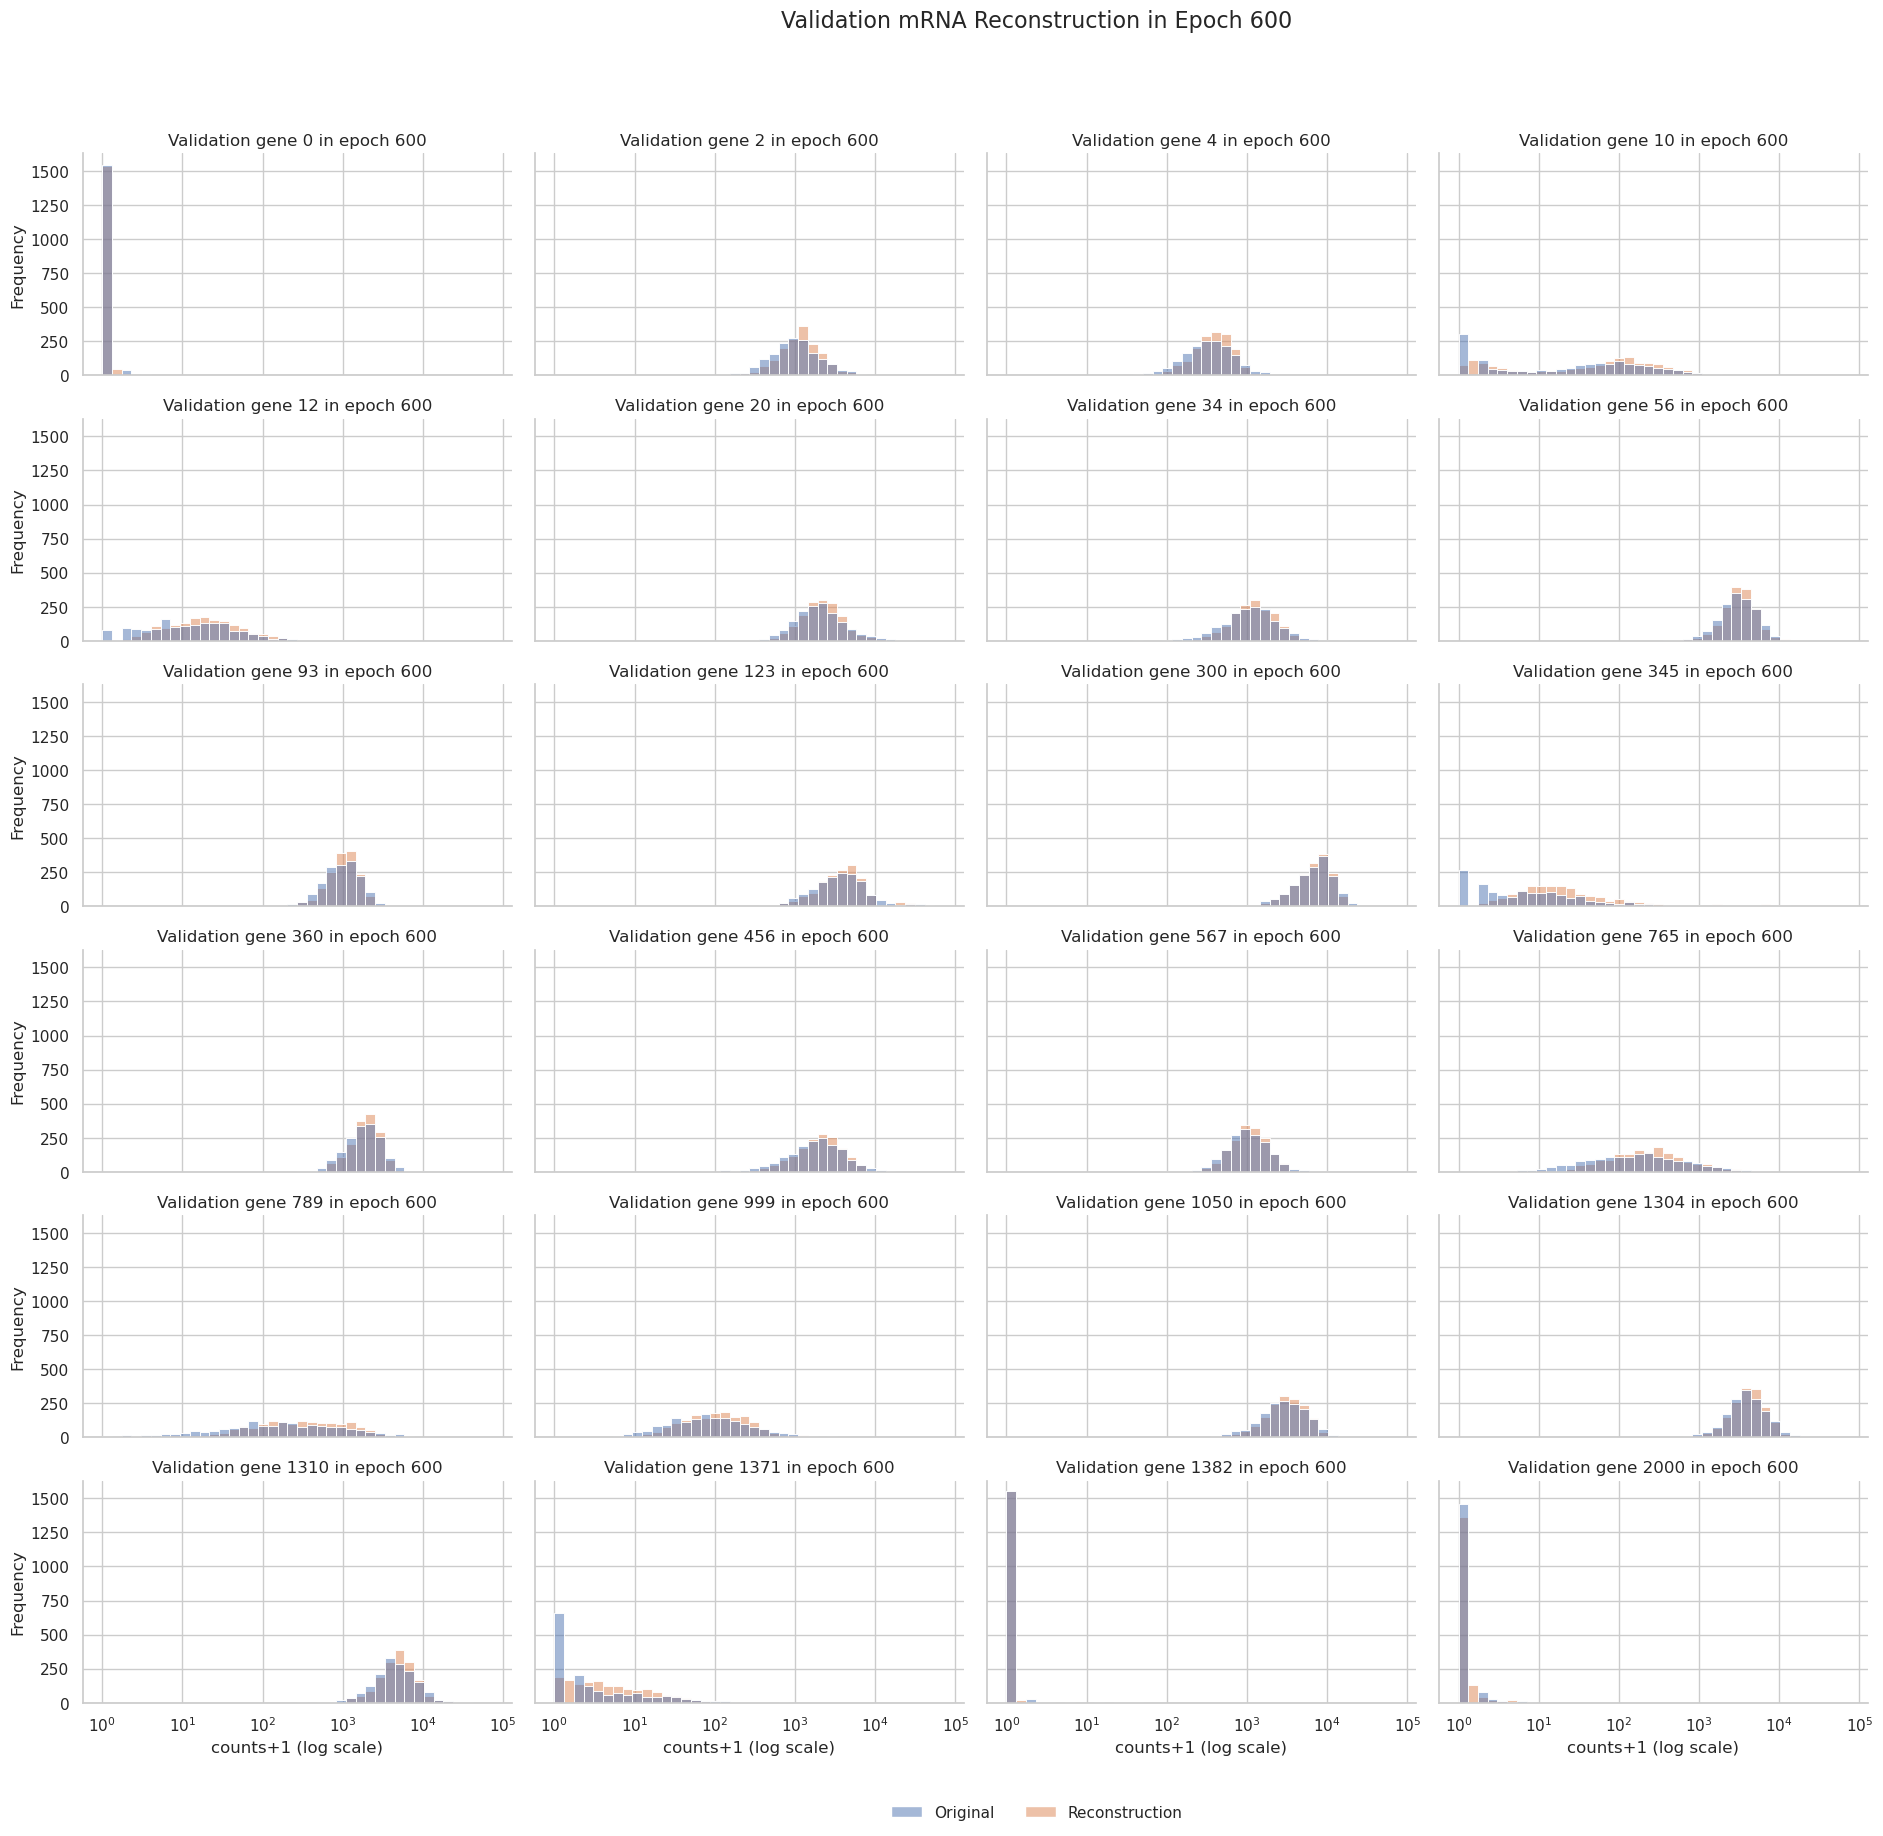

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 606/801 [54:17<34:54, 10.74s/it]

605 train_recon_mirna: 1.8494544932739416 train_recon_mrna: 6.309012775254886 train_gmm: 2.32257592828976 train_mse: 561859008.0 train_mae: 3746.955322265625 train_r2: 0.3044673204421997 train_spearman: 0.4771088659763336 train_pearson: 0.8616511225700378 train_msle: 1.8893522024154663
605 test_recon_mirna: 1.8517478345426401 test_recon_mrna: 6.37214929906942 test_gmm: 2.322316283035993 test_mse: 278781344.0 test_mae: 2646.39599609375 test_r2: 0.3918588161468506 test_spearman: 0.43982890248298645 test_pearson: 0.8732540607452393 test_msle: 1.8503639698028564


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 611/801 [54:38<16:32,  5.22s/it]

610 train_recon_mirna: 1.8489646699627222 train_recon_mrna: 6.3082934641910615 train_gmm: 2.32321276027292 train_mse: 561747456.0 train_mae: 3748.81494140625 train_r2: 0.3046054244041443 train_spearman: 0.4769452214241028 train_pearson: 0.8626038432121277 train_msle: 1.823364019393921
610 test_recon_mirna: 1.850818379593226 test_recon_mrna: 6.366017566461315 test_gmm: 2.3251280175232276 test_mse: 274421568.0 test_mae: 2620.461669921875 test_r2: 0.4013693928718567 test_spearman: 0.4428136646747589 test_pearson: 0.8728929758071899 test_msle: 1.8029907941818237


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 616/801 [54:59<13:27,  4.37s/it]

615 train_recon_mirna: 1.8485702483568647 train_recon_mrna: 6.30779079172975 train_gmm: 2.323958681265577 train_mse: 558372928.0 train_mae: 3734.8984375 train_r2: 0.30878275632858276 train_spearman: 0.4789395332336426 train_pearson: 0.8645468354225159 train_msle: 1.851493239402771
615 test_recon_mirna: 1.850647877214525 test_recon_mrna: 6.368330877999386 test_gmm: 2.325569087069605 test_mse: 275547008.0 test_mae: 2627.15625 test_r2: 0.39891427755355835 test_spearman: 0.4428577721118927 test_pearson: 0.8699248433113098 test_msle: 1.78052818775177


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 621/801 [55:19<12:36,  4.20s/it]

620 train_recon_mirna: 1.8481605657425362 train_recon_mrna: 6.3065856291402405 train_gmm: 2.324407365212682 train_mse: 556187904.0 train_mae: 3721.42724609375 train_r2: 0.31148767471313477 train_spearman: 0.47671428322792053 train_pearson: 0.8642213344573975 train_msle: 1.8056468963623047
620 test_recon_mirna: 1.850618304502744 test_recon_mrna: 6.371652689967813 test_gmm: 2.3258363913179263 test_mse: 279214144.0 test_mae: 2649.97412109375 test_r2: 0.3909147381782532 test_spearman: 0.44542694091796875 test_pearson: 0.8756048679351807 test_msle: 1.774513840675354


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 626/801 [55:40<11:55,  4.09s/it]

625 train_recon_mirna: 1.8478807613039352 train_recon_mrna: 6.305820613801398 train_gmm: 2.3253863648718722 train_mse: 558203520.0 train_mae: 3726.731201171875 train_r2: 0.30899250507354736 train_spearman: 0.4765917658805847 train_pearson: 0.8621136546134949 train_msle: 1.8471221923828125
625 test_recon_mirna: 1.8504599870649643 test_recon_mrna: 6.385682249085685 test_gmm: 2.3273585494051567 test_mse: 278668800.0 test_mae: 2644.937744140625 test_r2: 0.3921043276786804 test_spearman: 0.4425918757915497 test_pearson: 0.8706744313240051 test_msle: 1.8348215818405151


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 631/801 [56:01<11:43,  4.14s/it]

630 train_recon_mirna: 1.8475798757443793 train_recon_mrna: 6.30527644653556 train_gmm: 2.326285362983825 train_mse: 559787904.0 train_mae: 3741.21337890625 train_r2: 0.30703121423721313 train_spearman: 0.47971808910369873 train_pearson: 0.8639713525772095 train_msle: 1.8580559492111206
630 test_recon_mirna: 1.8496890665388233 test_recon_mrna: 6.370214958288221 test_gmm: 2.327151639844238 test_mse: 281738656.0 test_mae: 2668.694091796875 test_r2: 0.38540762662887573 test_spearman: 0.445109486579895 test_pearson: 0.8731656670570374 test_msle: 1.788739562034607


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 636/801 [56:21<11:25,  4.16s/it]

635 train_recon_mirna: 1.8471620672861035 train_recon_mrna: 6.304503171551317 train_gmm: 2.3268901966349693 train_mse: 555698560.0 train_mae: 3717.51953125 train_r2: 0.31209349632263184 train_spearman: 0.47567030787467957 train_pearson: 0.8628135323524475 train_msle: 1.791564702987671
635 test_recon_mirna: 1.8500483414747577 test_recon_mrna: 6.366929912257552 test_gmm: 2.3287217720980053 test_mse: 271258720.0 test_mae: 2600.77294921875 test_r2: 0.40826886892318726 test_spearman: 0.44038188457489014 test_pearson: 0.8741280436515808 test_msle: 1.8267242908477783


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 641/801 [56:42<10:53,  4.09s/it]

640 train_recon_mirna: 1.8468621279855173 train_recon_mrna: 6.3036848803134 train_gmm: 2.3276560624759552 train_mse: 556504000.0 train_mae: 3721.63916015625 train_r2: 0.3110963702201843 train_spearman: 0.4787960648536682 train_pearson: 0.8629178404808044 train_msle: 1.7802776098251343
640 test_recon_mirna: 1.849324579129151 test_recon_mrna: 6.372238239732962 test_gmm: 2.329744943955926 test_mse: 272632992.0 test_mae: 2616.214599609375 test_r2: 0.4052709937095642 test_spearman: 0.4417320489883423 test_pearson: 0.8754402995109558 test_msle: 1.8123375177383423


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 646/801 [57:03<10:40,  4.13s/it]

645 train_recon_mirna: 1.846537877267253 train_recon_mrna: 6.303211297936811 train_gmm: 2.328339300126288 train_mse: 552330816.0 train_mae: 3702.0166015625 train_r2: 0.316262423992157 train_spearman: 0.47673025727272034 train_pearson: 0.8625336289405823 train_msle: 1.86089289188385
645 test_recon_mirna: 1.8489458719368206 test_recon_mrna: 6.366517292124771 test_gmm: 2.3303016486278105 test_mse: 274070752.0 test_mae: 2624.04443359375 test_r2: 0.40213465690612793 test_spearman: 0.4417148232460022 test_pearson: 0.875032901763916 test_msle: 1.8562949895858765


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 651/801 [57:23<10:26,  4.17s/it]

650 train_recon_mirna: 1.8462048860499247 train_recon_mrna: 6.302705710705273 train_gmm: 2.328964859431453 train_mse: 551458688.0 train_mae: 3703.836669921875 train_r2: 0.31734204292297363 train_spearman: 0.48144346475601196 train_pearson: 0.8654385805130005 train_msle: 1.7638845443725586
650 test_recon_mirna: 1.849269103171375 test_recon_mrna: 6.369668341816024 test_gmm: 2.331971884637531 test_mse: 271513952.0 test_mae: 2607.24609375 test_r2: 0.40771210193634033 test_spearman: 0.4416327476501465 test_pearson: 0.8757543563842773 test_msle: 1.723357081413269


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 656/801 [57:44<09:58,  4.13s/it]

655 train_recon_mirna: 1.8457801015143318 train_recon_mrna: 6.301480497208013 train_gmm: 2.330120036950731 train_mse: 553627392.0 train_mae: 3712.18017578125 train_r2: 0.3146573305130005 train_spearman: 0.477206826210022 train_pearson: 0.8638404607772827 train_msle: 1.7975847721099854
655 test_recon_mirna: 1.8482102091423838 test_recon_mrna: 6.363746336418266 test_gmm: 2.3309646863776545 test_mse: 267162512.0 test_mae: 2583.679443359375 test_r2: 0.41720443964004517 test_spearman: 0.44104233384132385 test_pearson: 0.8749347925186157 test_msle: 1.815104603767395


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 661/801 [58:05<09:41,  4.15s/it]

660 train_recon_mirna: 1.8454523364150468 train_recon_mrna: 6.300933296547577 train_gmm: 2.3309071315590293 train_mse: 550674432.0 train_mae: 3697.36572265625 train_r2: 0.3183128833770752 train_spearman: 0.4733145833015442 train_pearson: 0.8632258176803589 train_msle: 1.880074381828308
660 test_recon_mirna: 1.8482604581607223 test_recon_mrna: 6.371049469138776 test_gmm: 2.3323748844106222 test_mse: 275523968.0 test_mae: 2632.3154296875 test_r2: 0.3989645838737488 test_spearman: 0.442031592130661 test_pearson: 0.8747585415840149 test_msle: 1.7991396188735962


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 666/801 [58:26<09:24,  4.18s/it]

665 train_recon_mirna: 1.8450865587706653 train_recon_mrna: 6.300343475845736 train_gmm: 2.331494042615917 train_mse: 551792000.0 train_mae: 3702.7138671875 train_r2: 0.3169293999671936 train_spearman: 0.47669968008995056 train_pearson: 0.8643276691436768 train_msle: 1.8059085607528687
665 test_recon_mirna: 1.8493879871121803 test_recon_mrna: 6.387632932041455 test_gmm: 2.3321782528497814 test_mse: 269454112.0 test_mae: 2597.85986328125 test_r2: 0.41220545768737793 test_spearman: 0.4374141991138458 test_pearson: 0.8762703537940979 test_msle: 1.8396583795547485


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 671/801 [58:46<08:56,  4.12s/it]

670 train_recon_mirna: 1.844833968574748 train_recon_mrna: 6.299735922495256 train_gmm: 2.3322354241545606 train_mse: 549667136.0 train_mae: 3694.740966796875 train_r2: 0.31955981254577637 train_spearman: 0.47567296028137207 train_pearson: 0.8655251264572144 train_msle: 1.8335239887237549
670 test_recon_mirna: 1.8477940357882179 test_recon_mrna: 6.365316545706626 test_gmm: 2.3340400729158532 test_mse: 269003424.0 test_mae: 2595.201171875 test_r2: 0.413188636302948 test_spearman: 0.4421713650226593 test_pearson: 0.8766344785690308 test_msle: 1.7906628847122192


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 676/801 [59:07<08:34,  4.11s/it]

675 train_recon_mirna: 1.8443291507777801 train_recon_mrna: 6.299042729128376 train_gmm: 2.332867688914467 train_mse: 553976512.0 train_mae: 3715.54248046875 train_r2: 0.3142251968383789 train_spearman: 0.48137807846069336 train_pearson: 0.8649864196777344 train_msle: 1.7118197679519653
675 test_recon_mirna: 1.8482253209765143 test_recon_mrna: 6.392969087091957 test_gmm: 2.33539331496916 test_mse: 270505504.0 test_mae: 2602.828369140625 test_r2: 0.40991199016571045 test_spearman: 0.44522497057914734 test_pearson: 0.8755146861076355 test_msle: 1.6865957975387573


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 681/801 [59:28<08:20,  4.17s/it]

680 train_recon_mirna: 1.8441465548206746 train_recon_mrna: 6.2981889251434335 train_gmm: 2.3335628379353173 train_mse: 550359680.0 train_mae: 3695.7578125 train_r2: 0.31870245933532715 train_spearman: 0.4787997901439667 train_pearson: 0.8648974895477295 train_msle: 1.8191739320755005
680 test_recon_mirna: 1.8472547014680796 test_recon_mrna: 6.368800672012999 test_gmm: 2.3361489614645143 test_mse: 267658448.0 test_mae: 2593.5439453125 test_r2: 0.4161226153373718 test_spearman: 0.4463788568973541 test_pearson: 0.8774554133415222 test_msle: 1.7815126180648804


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 686/801 [59:48<07:57,  4.15s/it]

685 train_recon_mirna: 1.8437585276940993 train_recon_mrna: 6.2977383016662865 train_gmm: 2.334571944351227 train_mse: 548149696.0 train_mae: 3687.28515625 train_r2: 0.3214382529258728 train_spearman: 0.47626572847366333 train_pearson: 0.8647646307945251 train_msle: 1.7832692861557007
685 test_recon_mirna: 1.8466716132287009 test_recon_mrna: 6.3674069202417405 test_gmm: 2.3361339943175166 test_mse: 269180032.0 test_mae: 2597.064208984375 test_r2: 0.4128033518791199 test_spearman: 0.4407423734664917 test_pearson: 0.8759455680847168 test_msle: 1.7148878574371338


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 691/801 [1:00:09<07:31,  4.10s/it]

690 train_recon_mirna: 1.843473388668905 train_recon_mrna: 6.296891811721054 train_gmm: 2.3353063443762125 train_mse: 548449856.0 train_mae: 3686.152587890625 train_r2: 0.3210667371749878 train_spearman: 0.4799627959728241 train_pearson: 0.8651685118675232 train_msle: 1.7264862060546875
690 test_recon_mirna: 1.8469988080649322 test_recon_mrna: 6.372355925538028 test_gmm: 2.3361085509300827 test_mse: 268649344.0 test_mae: 2589.199951171875 test_r2: 0.4139610528945923 test_spearman: 0.4393599033355713 test_pearson: 0.8733566999435425 test_msle: 1.7941114902496338


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 696/801 [1:00:30<07:16,  4.16s/it]

695 train_recon_mirna: 1.8431742262097437 train_recon_mrna: 6.296603401985594 train_gmm: 2.3358481091826406 train_mse: 553489408.0 train_mae: 3711.2099609375 train_r2: 0.31482815742492676 train_spearman: 0.4775526225566864 train_pearson: 0.8644540905952454 train_msle: 1.7773853540420532
695 test_recon_mirna: 1.8463167262216302 test_recon_mrna: 6.366432844372728 test_gmm: 2.3367594655195973 test_mse: 272960576.0 test_mae: 2622.4423828125 test_r2: 0.4045564532279968 test_spearman: 0.44228795170783997 test_pearson: 0.8772003054618835 test_msle: 1.764159917831421


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 701/801 [1:00:50<06:53,  4.14s/it]

700 train_recon_mirna: 1.8427784606268998 train_recon_mrna: 6.295955099469483 train_gmm: 2.3365684922753163 train_mse: 550809920.0 train_mae: 3698.130615234375 train_r2: 0.31814509630203247 train_spearman: 0.47834470868110657 train_pearson: 0.8649582862854004 train_msle: 1.6954703330993652
700 test_recon_mirna: 1.8473928055016875 test_recon_mrna: 6.3699091239040895 test_gmm: 2.340437548492641 test_mse: 268716864.0 test_mae: 2589.784423828125 test_r2: 0.4138137698173523 test_spearman: 0.44375061988830566 test_pearson: 0.8750752806663513 test_msle: 1.6542596817016602


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 706/801 [1:01:11<06:26,  4.07s/it]

705 train_recon_mirna: 1.8425417698543478 train_recon_mrna: 6.295577131724154 train_gmm: 2.3373521304299647 train_mse: 548227520.0 train_mae: 3689.236328125 train_r2: 0.32134193181991577 train_spearman: 0.4764498770236969 train_pearson: 0.8656920194625854 train_msle: 1.8138971328735352
705 test_recon_mirna: 1.846586665819041 test_recon_mrna: 6.36713046380357 test_gmm: 2.3394141936436212 test_mse: 266430656.0 test_mae: 2577.4267578125 test_r2: 0.418800950050354 test_spearman: 0.4428330659866333 test_pearson: 0.8755648136138916 test_msle: 1.8007324934005737


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 711/801 [1:01:32<06:10,  4.12s/it]

710 train_recon_mirna: 1.8421969390365263 train_recon_mrna: 6.294837718913564 train_gmm: 2.338193020590271 train_mse: 551207872.0 train_mae: 3702.974853515625 train_r2: 0.31765252351760864 train_spearman: 0.4780774712562561 train_pearson: 0.8663577437400818 train_msle: 1.826821208000183
710 test_recon_mirna: 1.8458654253270559 test_recon_mrna: 6.363268616529086 test_gmm: 2.3399537047767995 test_mse: 266176624.0 test_mae: 2578.514404296875 test_r2: 0.4193550944328308 test_spearman: 0.43893590569496155 test_pearson: 0.8762819766998291 test_msle: 1.7956645488739014


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 716/801 [1:01:52<05:53,  4.15s/it]

715 train_recon_mirna: 1.841915226584479 train_recon_mrna: 6.294045497922843 train_gmm: 2.3388468538823095 train_mse: 546721664.0 train_mae: 3682.011962890625 train_r2: 0.32320600748062134 train_spearman: 0.4814630448818207 train_pearson: 0.86688631772995 train_msle: 1.6996212005615234
715 test_recon_mirna: 1.8456945902372652 test_recon_mrna: 6.364547561755464 test_gmm: 2.3392360365591816 test_mse: 272970784.0 test_mae: 2622.8408203125 test_r2: 0.40453410148620605 test_spearman: 0.44305506348609924 test_pearson: 0.8790351152420044 test_msle: 1.7556101083755493


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 721/801 [1:02:13<05:28,  4.10s/it]

720 train_recon_mirna: 1.841722794079437 train_recon_mrna: 6.293780104704376 train_gmm: 2.3397640702492515 train_mse: 549487168.0 train_mae: 3694.11279296875 train_r2: 0.3197826147079468 train_spearman: 0.48075100779533386 train_pearson: 0.8655193448066711 train_msle: 1.6974976062774658
720 test_recon_mirna: 1.8455584631825959 test_recon_mrna: 6.361284711340403 test_gmm: 2.3422842412945033 test_mse: 266100256.0 test_mae: 2578.446044921875 test_r2: 0.419521689414978 test_spearman: 0.44156622886657715 test_pearson: 0.8747547268867493 test_msle: 1.6841118335723877


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 726/801 [1:02:33<05:09,  4.12s/it]

725 train_recon_mirna: 1.8413354942086637 train_recon_mrna: 6.2930569536002405 train_gmm: 2.3405714217014584 train_mse: 547725888.0 train_mae: 3684.61279296875 train_r2: 0.3219628930091858 train_spearman: 0.47897154092788696 train_pearson: 0.8661131858825684 train_msle: 1.7390245199203491
725 test_recon_mirna: 1.844720479673339 test_recon_mrna: 6.362850759939594 test_gmm: 2.3422661861727048 test_mse: 267458704.0 test_mae: 2585.40087890625 test_r2: 0.41655832529067993 test_spearman: 0.4423767626285553 test_pearson: 0.8802661299705505 test_msle: 1.7695707082748413


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 731/801 [1:02:54<04:50,  4.15s/it]

730 train_recon_mirna: 1.8409943430572724 train_recon_mrna: 6.292257747328778 train_gmm: 2.3413639427459687 train_mse: 547008448.0 train_mae: 3682.47412109375 train_r2: 0.3228510022163391 train_spearman: 0.47832825779914856 train_pearson: 0.8656212091445923 train_msle: 1.7094664573669434
730 test_recon_mirna: 1.8443094657520127 test_recon_mrna: 6.364058609587538 test_gmm: 2.3423074887887454 test_mse: 271035264.0 test_mae: 2603.537841796875 test_r2: 0.4087563753128052 test_spearman: 0.4407079815864563 test_pearson: 0.8745361566543579 test_msle: 1.6895359754562378


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 736/801 [1:03:15<04:27,  4.11s/it]

735 train_recon_mirna: 1.840746067843578 train_recon_mrna: 6.292162451288682 train_gmm: 2.342067899516384 train_mse: 542766208.0 train_mae: 3663.99560546875 train_r2: 0.32810258865356445 train_spearman: 0.47692984342575073 train_pearson: 0.8660017848014832 train_msle: 1.8302053213119507
735 test_recon_mirna: 1.843935590103332 test_recon_mrna: 6.373799700499989 test_gmm: 2.3424317168712916 test_mse: 266248096.0 test_mae: 2573.302001953125 test_r2: 0.4191991686820984 test_spearman: 0.4415473937988281 test_pearson: 0.8705728054046631 test_msle: 1.7853913307189941


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 741/801 [1:03:35<04:06,  4.11s/it]

740 train_recon_mirna: 1.8404527420254417 train_recon_mrna: 6.291504672380063 train_gmm: 2.3428161171885455 train_mse: 544005696.0 train_mae: 3671.15869140625 train_r2: 0.3265681862831116 train_spearman: 0.48116394877433777 train_pearson: 0.8671295642852783 train_msle: 1.7577253580093384
740 test_recon_mirna: 1.8440148766025681 test_recon_mrna: 6.360501568389975 test_gmm: 2.3442772126063787 test_mse: 268105856.0 test_mae: 2589.306640625 test_r2: 0.4151465892791748 test_spearman: 0.4397660493850708 test_pearson: 0.877143383026123 test_msle: 1.8020775318145752


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 746/801 [1:03:56<03:49,  4.16s/it]

745 train_recon_mirna: 1.8401479061445976 train_recon_mrna: 6.290682612276457 train_gmm: 2.343463909854121 train_mse: 541283264.0 train_mae: 3656.010498046875 train_r2: 0.3299383521080017 train_spearman: 0.479036808013916 train_pearson: 0.867490828037262 train_msle: 1.7363194227218628
745 test_recon_mirna: 1.8435107228637364 test_recon_mrna: 6.356270384806163 test_gmm: 2.3457177414140578 test_mse: 259734768.0 test_mae: 2539.171875 test_r2: 0.4334075450897217 test_spearman: 0.4377932846546173 test_pearson: 0.8776649236679077 test_msle: 1.7937692403793335


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 751/801 [1:04:16<03:26,  4.13s/it]

750 train_recon_mirna: 1.8399572370282689 train_recon_mrna: 6.29043109471998 train_gmm: 2.3441791000988976 train_mse: 542153728.0 train_mae: 3660.025634765625 train_r2: 0.3288607597351074 train_spearman: 0.47566989064216614 train_pearson: 0.8658472895622253 train_msle: 1.7774378061294556
750 test_recon_mirna: 1.8433173261045468 test_recon_mrna: 6.356500330118254 test_gmm: 2.3473139270255894 test_mse: 266288880.0 test_mae: 2587.39599609375 test_r2: 0.41911017894744873 test_spearman: 0.4361092746257782 test_pearson: 0.881435751914978 test_msle: 1.7874236106872559


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 756/801 [1:04:37<03:04,  4.10s/it]

755 train_recon_mirna: 1.839668426600915 train_recon_mrna: 6.29017259188276 train_gmm: 2.3448886041833936 train_mse: 546116416.0 train_mae: 3686.015869140625 train_r2: 0.3239552974700928 train_spearman: 0.4811573922634125 train_pearson: 0.868867814540863 train_msle: 1.7142263650894165
755 test_recon_mirna: 1.843399341799098 test_recon_mrna: 6.35854210527265 test_gmm: 2.3471062397524984 test_mse: 262063488.0 test_mae: 2557.818603515625 test_r2: 0.4283275604248047 test_spearman: 0.4420320391654968 test_pearson: 0.878558337688446 test_msle: 1.7835673093795776


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 761/801 [1:04:58<02:45,  4.15s/it]

760 train_recon_mirna: 1.8393018969079198 train_recon_mrna: 6.2894517251450575 train_gmm: 2.345714726008422 train_mse: 547601856.0 train_mae: 3690.263916015625 train_r2: 0.3221164345741272 train_spearman: 0.4775526523590088 train_pearson: 0.8678247928619385 train_msle: 1.8503241539001465
760 test_recon_mirna: 1.8433367776485423 test_recon_mrna: 6.359955727103213 test_gmm: 2.347197681929751 test_mse: 268402112.0 test_mae: 2599.50390625 test_r2: 0.41450035572052 test_spearman: 0.4394287168979645 test_pearson: 0.8798485994338989 test_msle: 1.8641526699066162


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 766/801 [1:05:18<02:24,  4.12s/it]

765 train_recon_mirna: 1.8391032548366477 train_recon_mrna: 6.289150927636132 train_gmm: 2.3463555665630644 train_mse: 543279360.0 train_mae: 3669.270263671875 train_r2: 0.32746732234954834 train_spearman: 0.47910064458847046 train_pearson: 0.8681874871253967 train_msle: 1.748304009437561
765 test_recon_mirna: 1.843401781680422 test_recon_mrna: 6.369402089349392 test_gmm: 2.349626560914077 test_mse: 262935936.0 test_mae: 2564.29150390625 test_r2: 0.42642444372177124 test_spearman: 0.4384489059448242 test_pearson: 0.8780025839805603 test_msle: 1.7573391199111938


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 771/801 [1:05:39<02:02,  4.08s/it]

770 train_recon_mirna: 1.838946807031334 train_recon_mrna: 6.28812439301181 train_gmm: 2.3472241524566564 train_mse: 544190848.0 train_mae: 3673.310791015625 train_r2: 0.3263389468193054 train_spearman: 0.4785378873348236 train_pearson: 0.8668332099914551 train_msle: 1.7092496156692505
770 test_recon_mirna: 1.8431934273878974 test_recon_mrna: 6.359906210156062 test_gmm: 2.3483909440144832 test_mse: 264845968.0 test_mae: 2573.66162109375 test_r2: 0.42225784063339233 test_spearman: 0.43833261728286743 test_pearson: 0.8786240816116333 test_msle: 1.7156484127044678


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 776/801 [1:06:00<01:43,  4.15s/it]

775 train_recon_mirna: 1.8385288487831557 train_recon_mrna: 6.287283298780766 train_gmm: 2.3478216174582665 train_mse: 548866176.0 train_mae: 3698.50048828125 train_r2: 0.320551335811615 train_spearman: 0.48134610056877136 train_pearson: 0.8672128915786743 train_msle: 1.7258555889129639
775 test_recon_mirna: 1.8424650360184347 test_recon_mrna: 6.356619914336631 test_gmm: 2.3497784892742817 test_mse: 266786880.0 test_mae: 2583.995849609375 test_r2: 0.41802388429641724 test_spearman: 0.4388650059700012 test_pearson: 0.8837737441062927 test_msle: 1.7430065870285034


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 781/801 [1:06:20<01:22,  4.12s/it]

780 train_recon_mirna: 1.83824872307104 train_recon_mrna: 6.287231676844333 train_gmm: 2.348628406991733 train_mse: 543394368.0 train_mae: 3677.21728515625 train_r2: 0.32732492685317993 train_spearman: 0.4801172912120819 train_pearson: 0.8703592419624329 train_msle: 1.7841598987579346
780 test_recon_mirna: 1.8417242812977561 test_recon_mrna: 6.356540829602187 test_gmm: 2.351740252979095 test_mse: 262051952.0 test_mae: 2558.29345703125 test_r2: 0.4283527731895447 test_spearman: 0.4401940107345581 test_pearson: 0.8849811553955078 test_msle: 1.780213713645935


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 786/801 [1:06:40<01:01,  4.07s/it]

785 train_recon_mirna: 1.8379998962172914 train_recon_mrna: 6.286532176050251 train_gmm: 2.349214710392308 train_mse: 542835264.0 train_mae: 3670.071044921875 train_r2: 0.32801705598831177 train_spearman: 0.47878992557525635 train_pearson: 0.8691477179527283 train_msle: 1.7851965427398682
785 test_recon_mirna: 1.8416615965997043 test_recon_mrna: 6.356841032026834 test_gmm: 2.3518967103690076 test_mse: 268701728.0 test_mae: 2600.34619140625 test_r2: 0.41384679079055786 test_spearman: 0.44441625475883484 test_pearson: 0.8766270279884338 test_msle: 1.7466493844985962


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 791/801 [1:07:01<00:41,  4.13s/it]

790 train_recon_mirna: 1.8377103802278454 train_recon_mrna: 6.286267714880403 train_gmm: 2.3499570997910184 train_mse: 541196608.0 train_mae: 3664.105224609375 train_r2: 0.33004558086395264 train_spearman: 0.48102515935897827 train_pearson: 0.8699776530265808 train_msle: 1.7262200117111206
790 test_recon_mirna: 1.841597089223509 test_recon_mrna: 6.359111565985002 test_gmm: 2.3522434708775766 test_mse: 262305456.0 test_mae: 2564.81396484375 test_r2: 0.4277997612953186 test_spearman: 0.4455067813396454 test_pearson: 0.8846596479415894 test_msle: 1.7207133769989014


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 796/801 [1:07:22<00:20,  4.13s/it]

795 train_recon_mirna: 1.8374561464751367 train_recon_mrna: 6.285989872881651 train_gmm: 2.3509522301117354 train_mse: 543592448.0 train_mae: 3673.9765625 train_r2: 0.32707977294921875 train_spearman: 0.48132672905921936 train_pearson: 0.868319571018219 train_msle: 1.781021237373352
795 test_recon_mirna: 1.8415361211218038 test_recon_mrna: 6.3631929489385985 test_gmm: 2.353393890171182 test_mse: 262112752.0 test_mae: 2559.09765625 test_r2: 0.42822009325027466 test_spearman: 0.44213593006134033 test_pearson: 0.8858835697174072 test_msle: 1.7415982484817505


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 800/801 [1:07:38<00:04,  4.09s/it]

800 train_recon_mirna: 1.8372206467905672 train_recon_mrna: 6.2854025941305895 train_gmm: 2.351689516504207 train_mse: 539500032.0 train_mae: 3655.09619140625 train_r2: 0.3321458101272583 train_spearman: 0.48095080256462097 train_pearson: 0.8686462640762329 train_msle: 1.7367665767669678
800 test_recon_mirna: 1.8412046058633067 test_recon_mrna: 6.355136399256063 test_gmm: 2.356403003432913 test_mse: 259991584.0 test_mae: 2546.61669921875 test_r2: 0.4328473210334778 test_spearman: 0.4412948787212372 test_pearson: 0.8839677572250366 test_msle: 1.7156702280044556


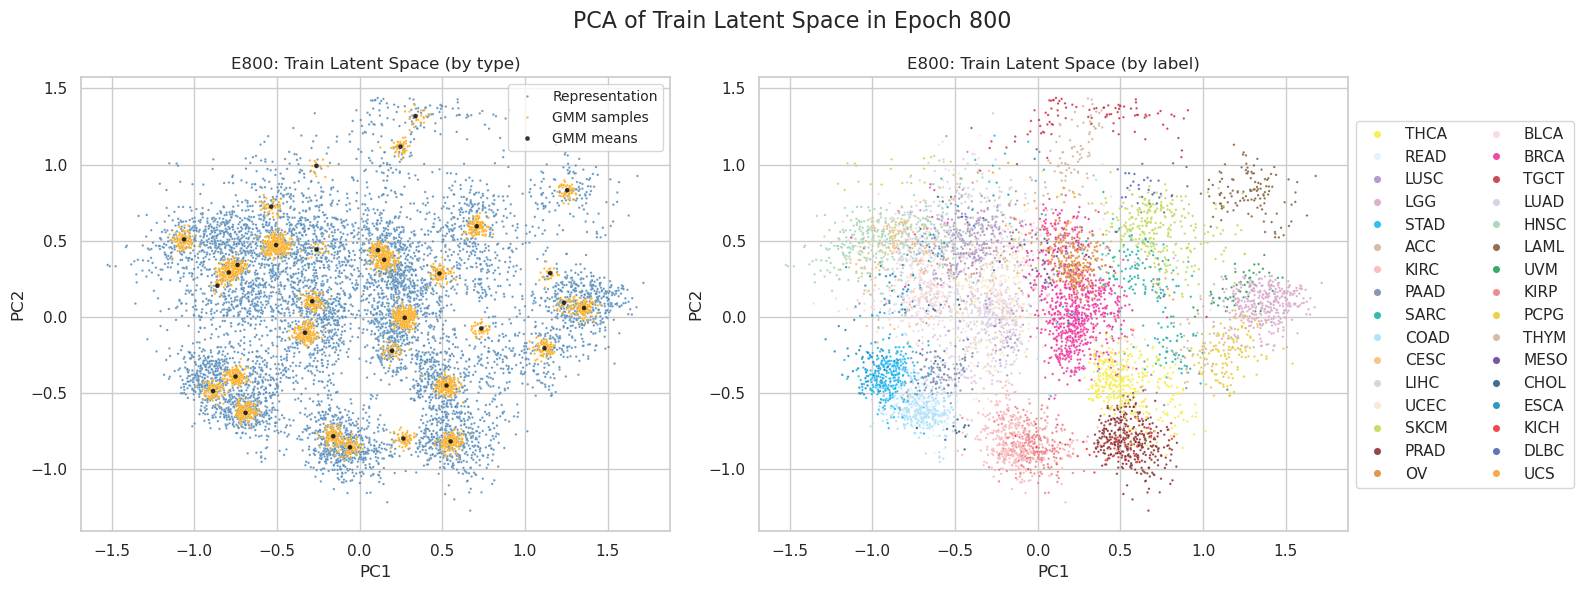

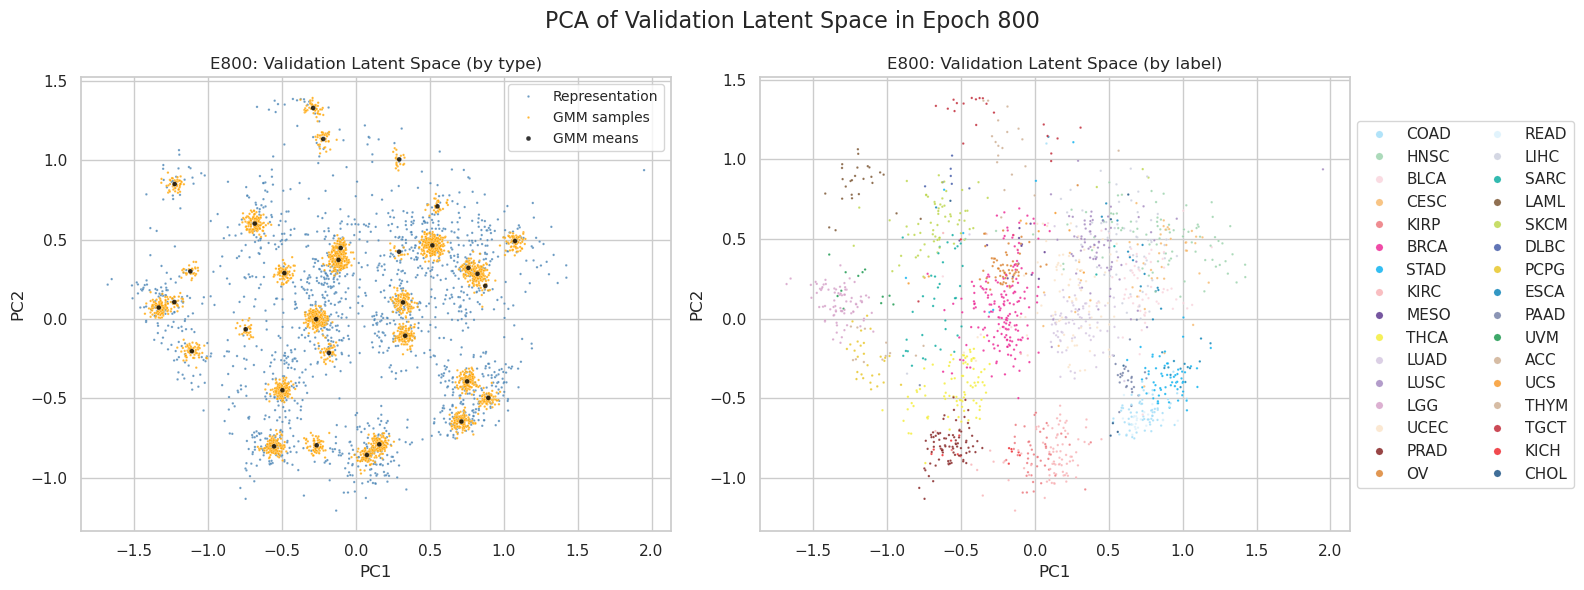

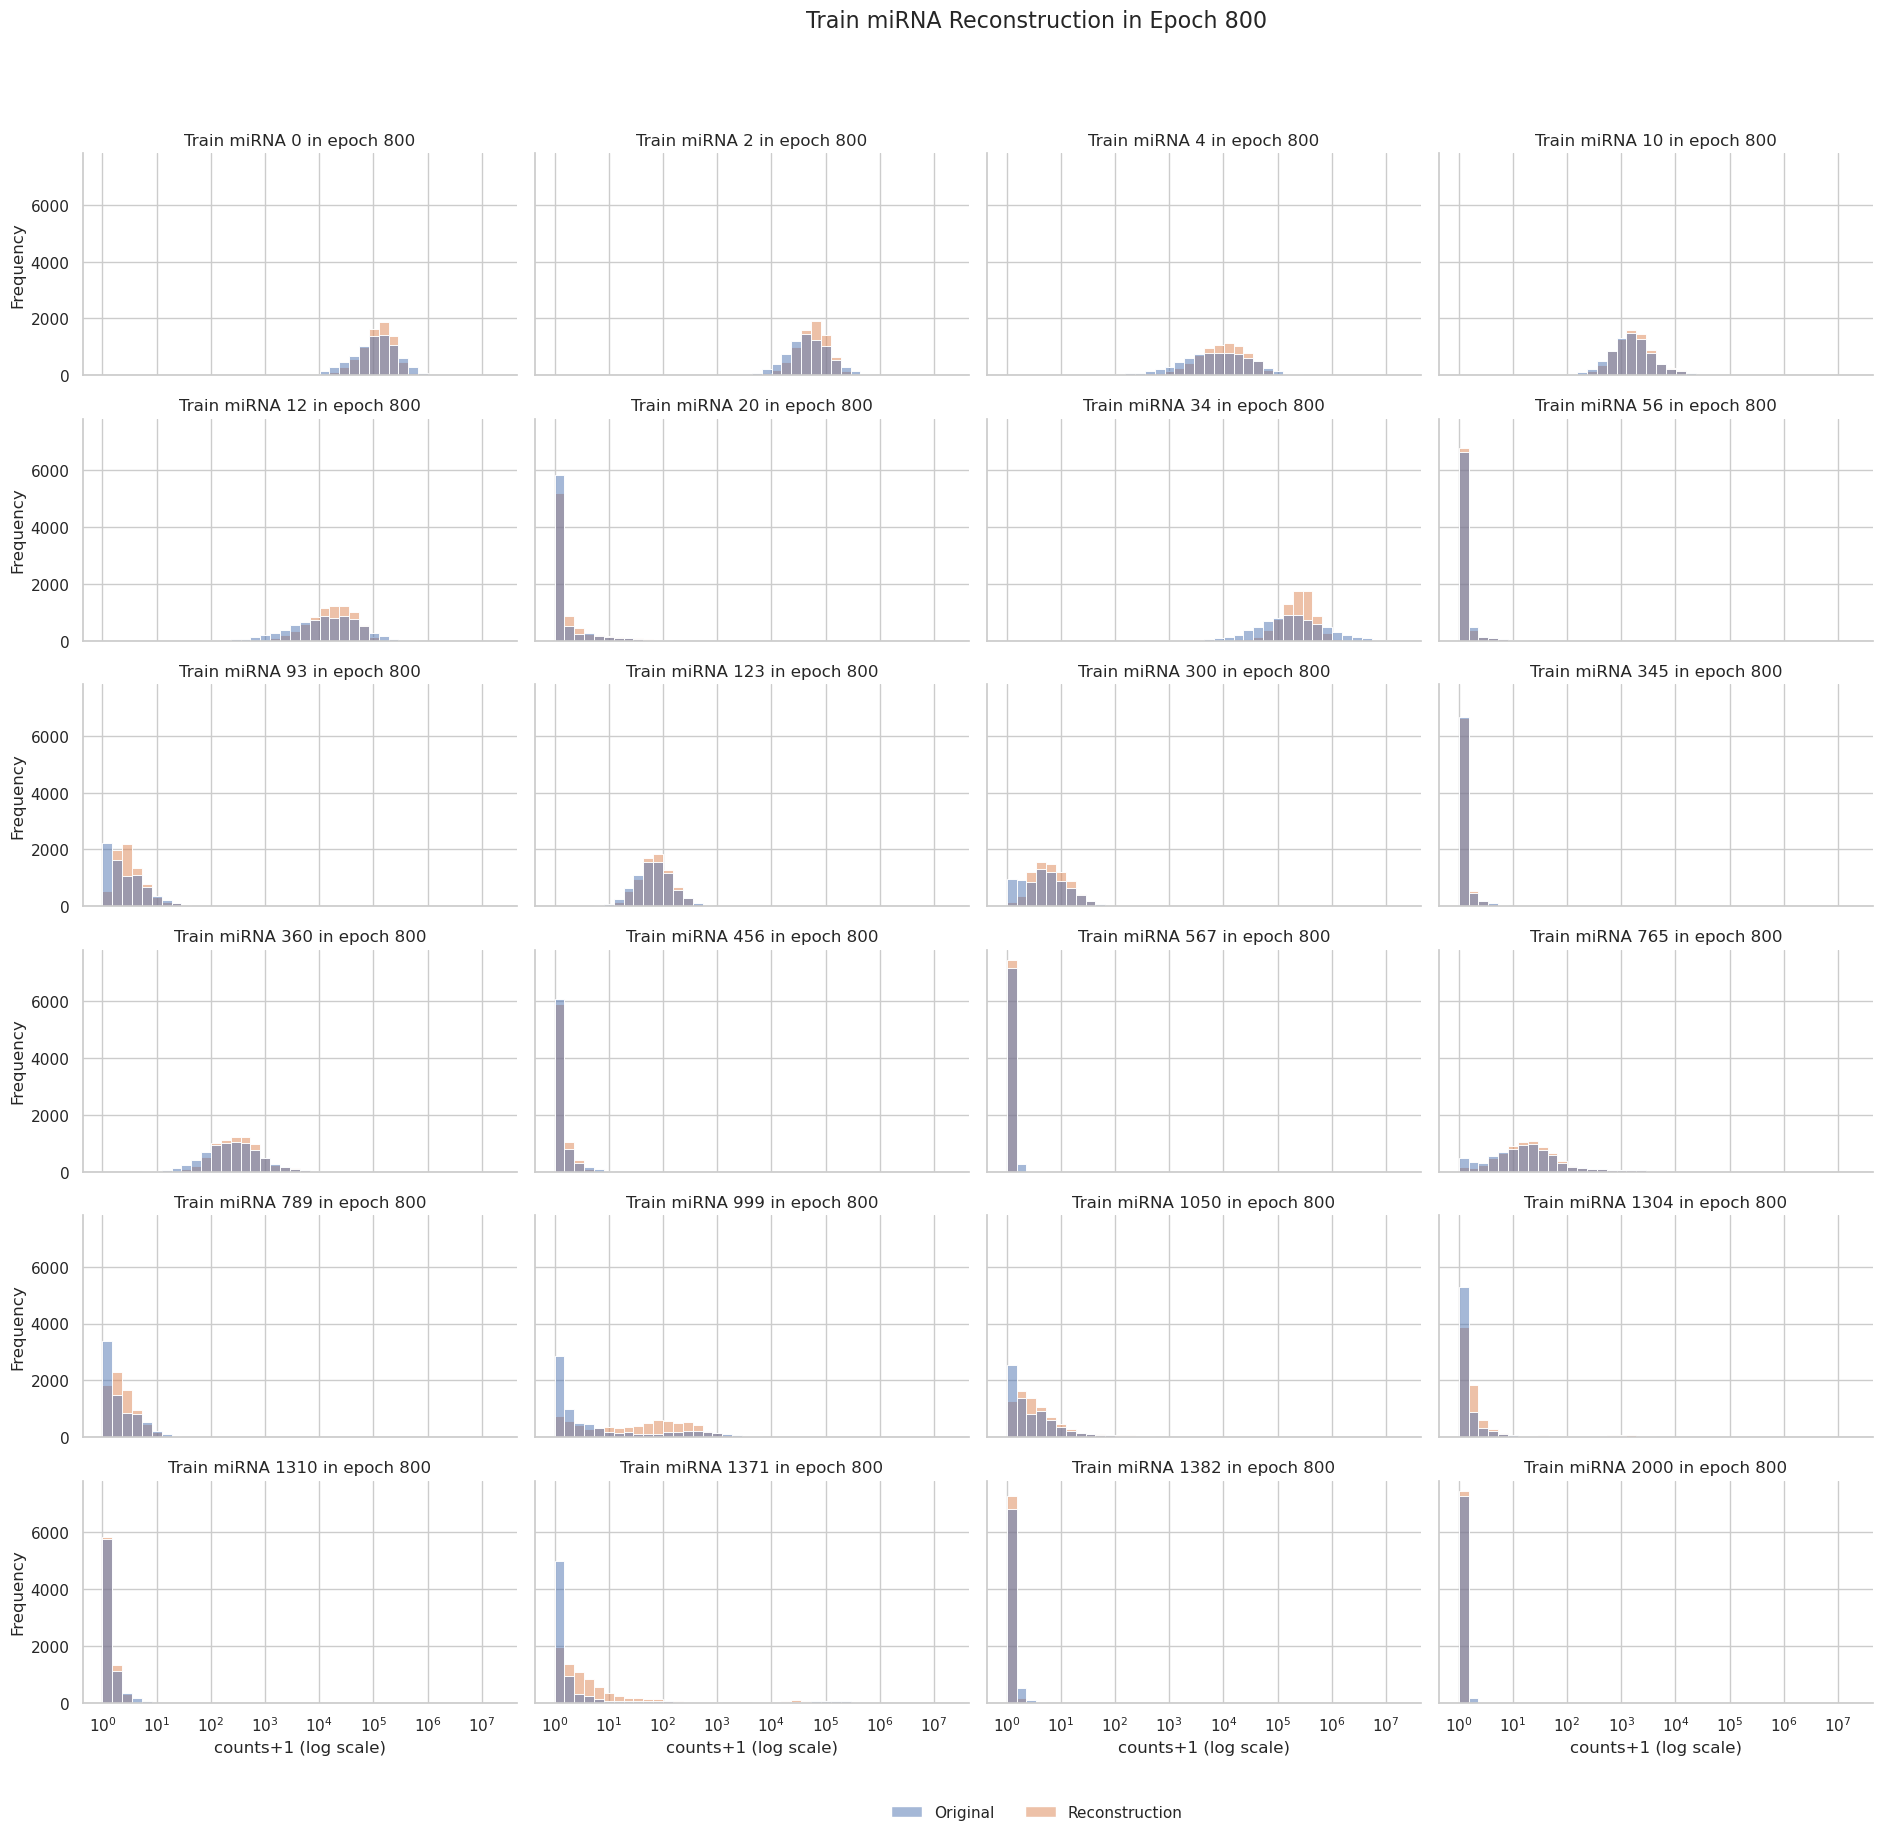

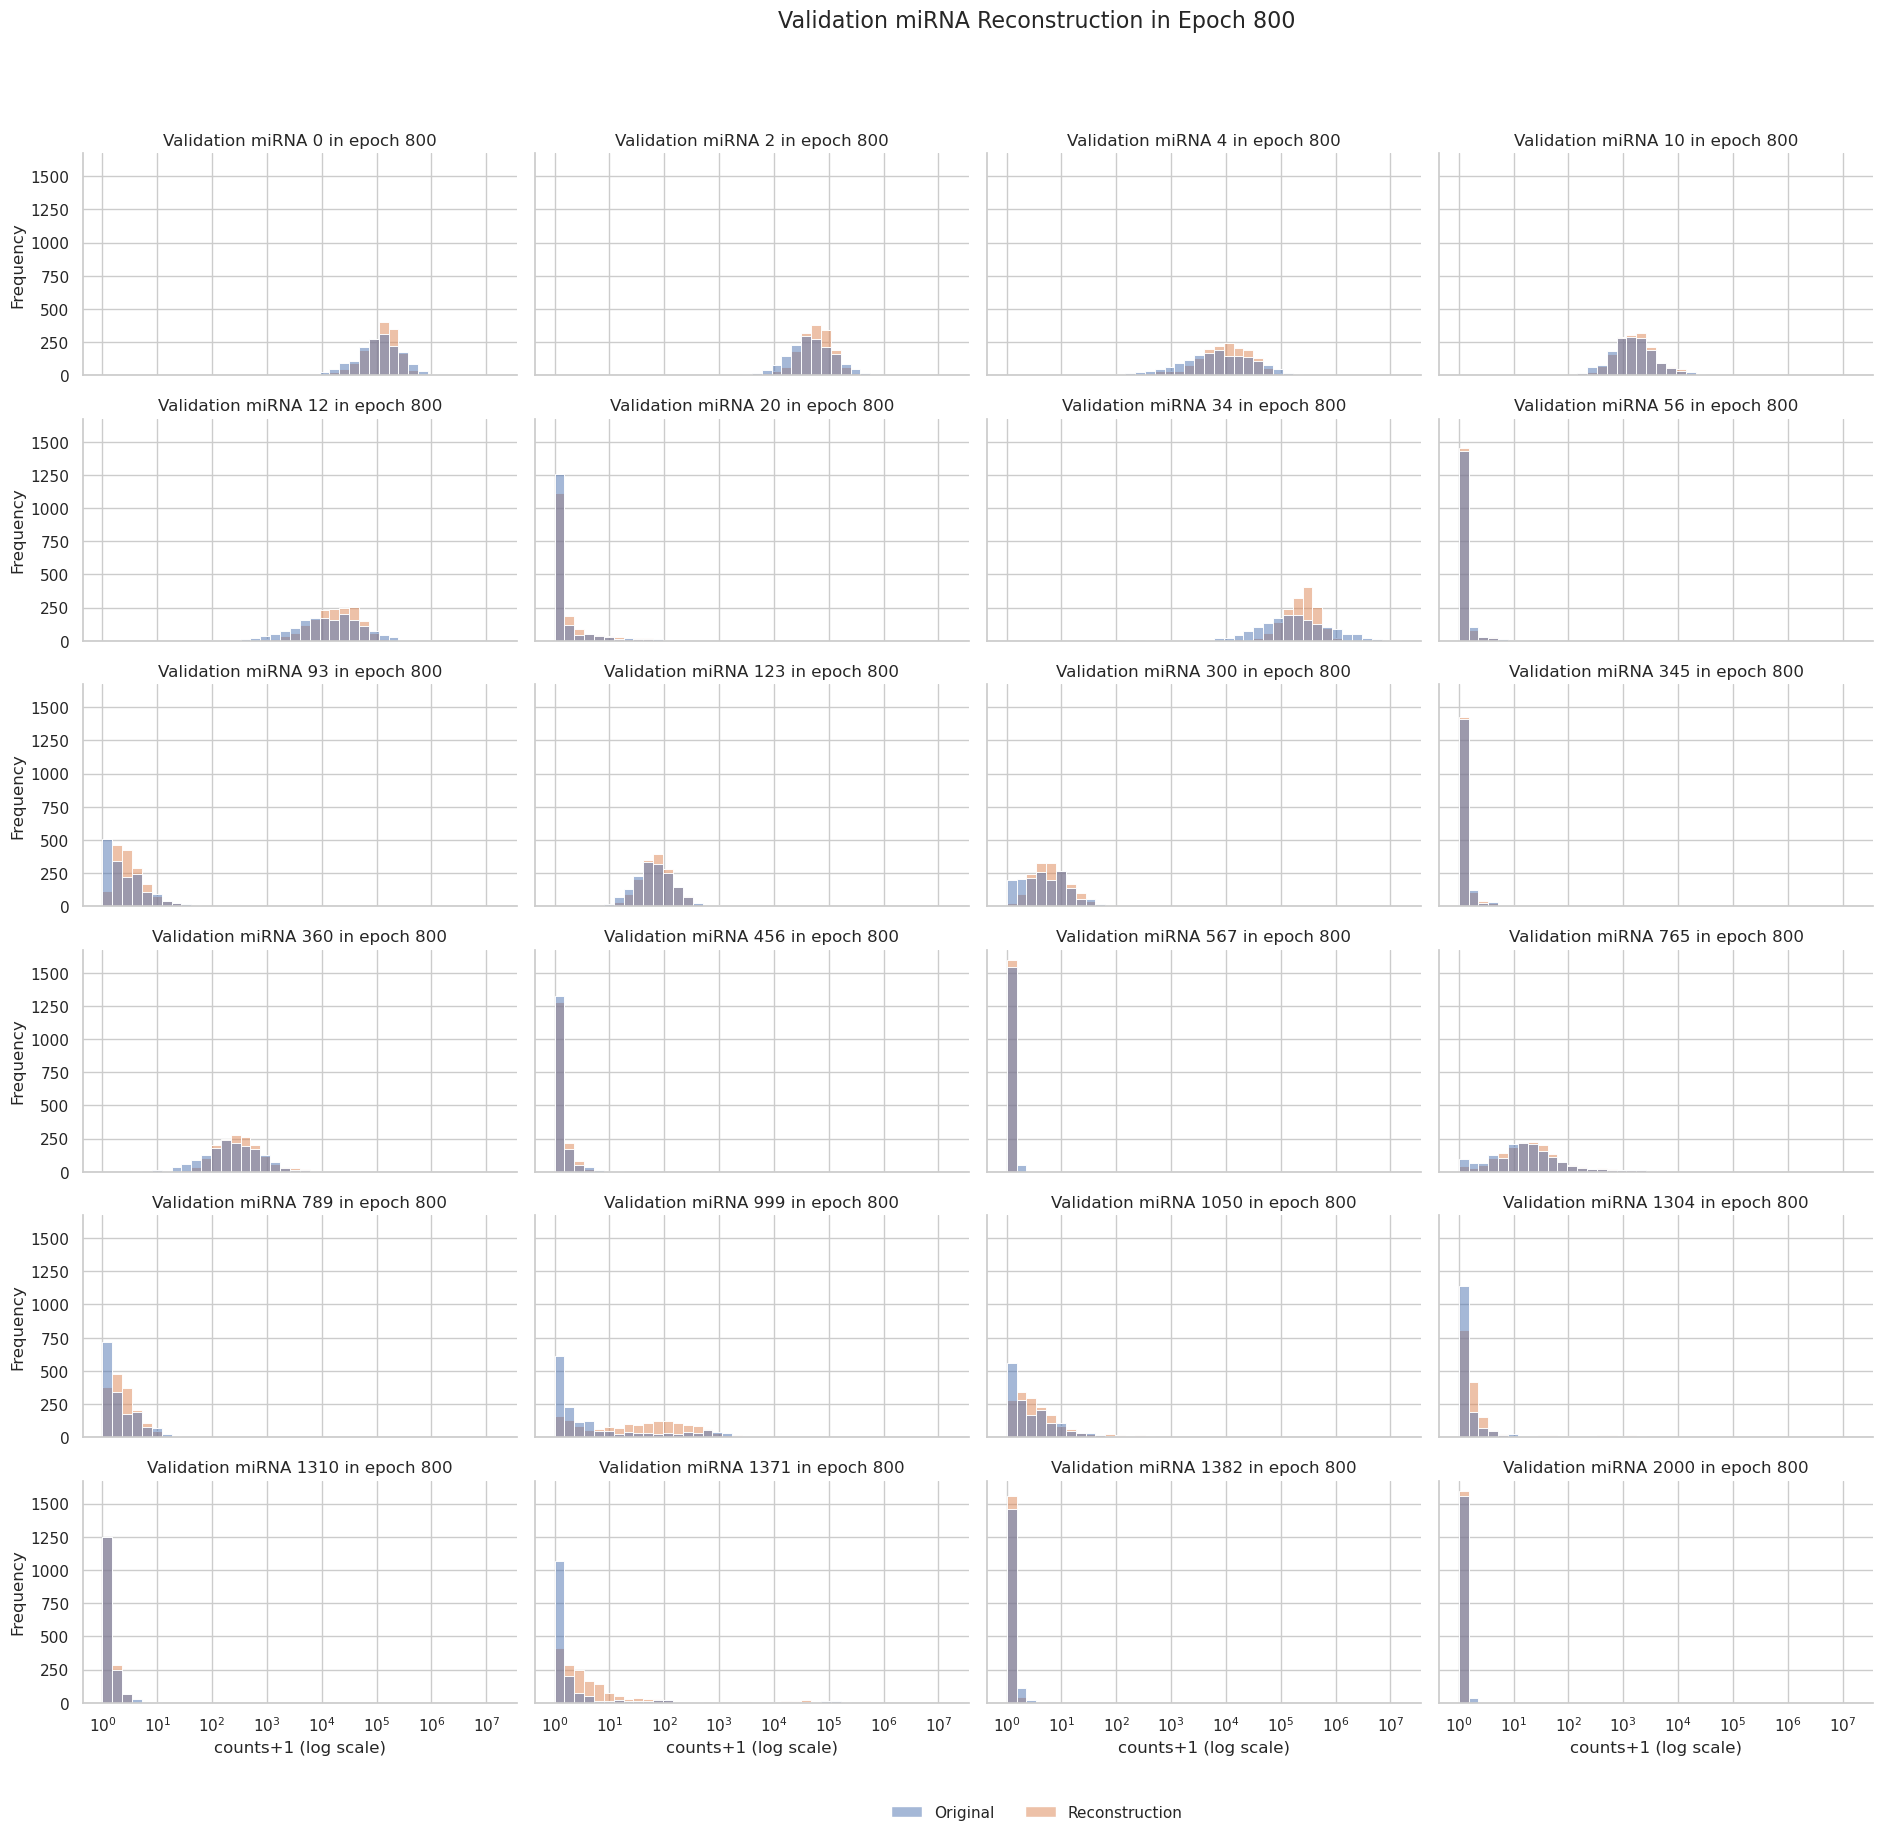

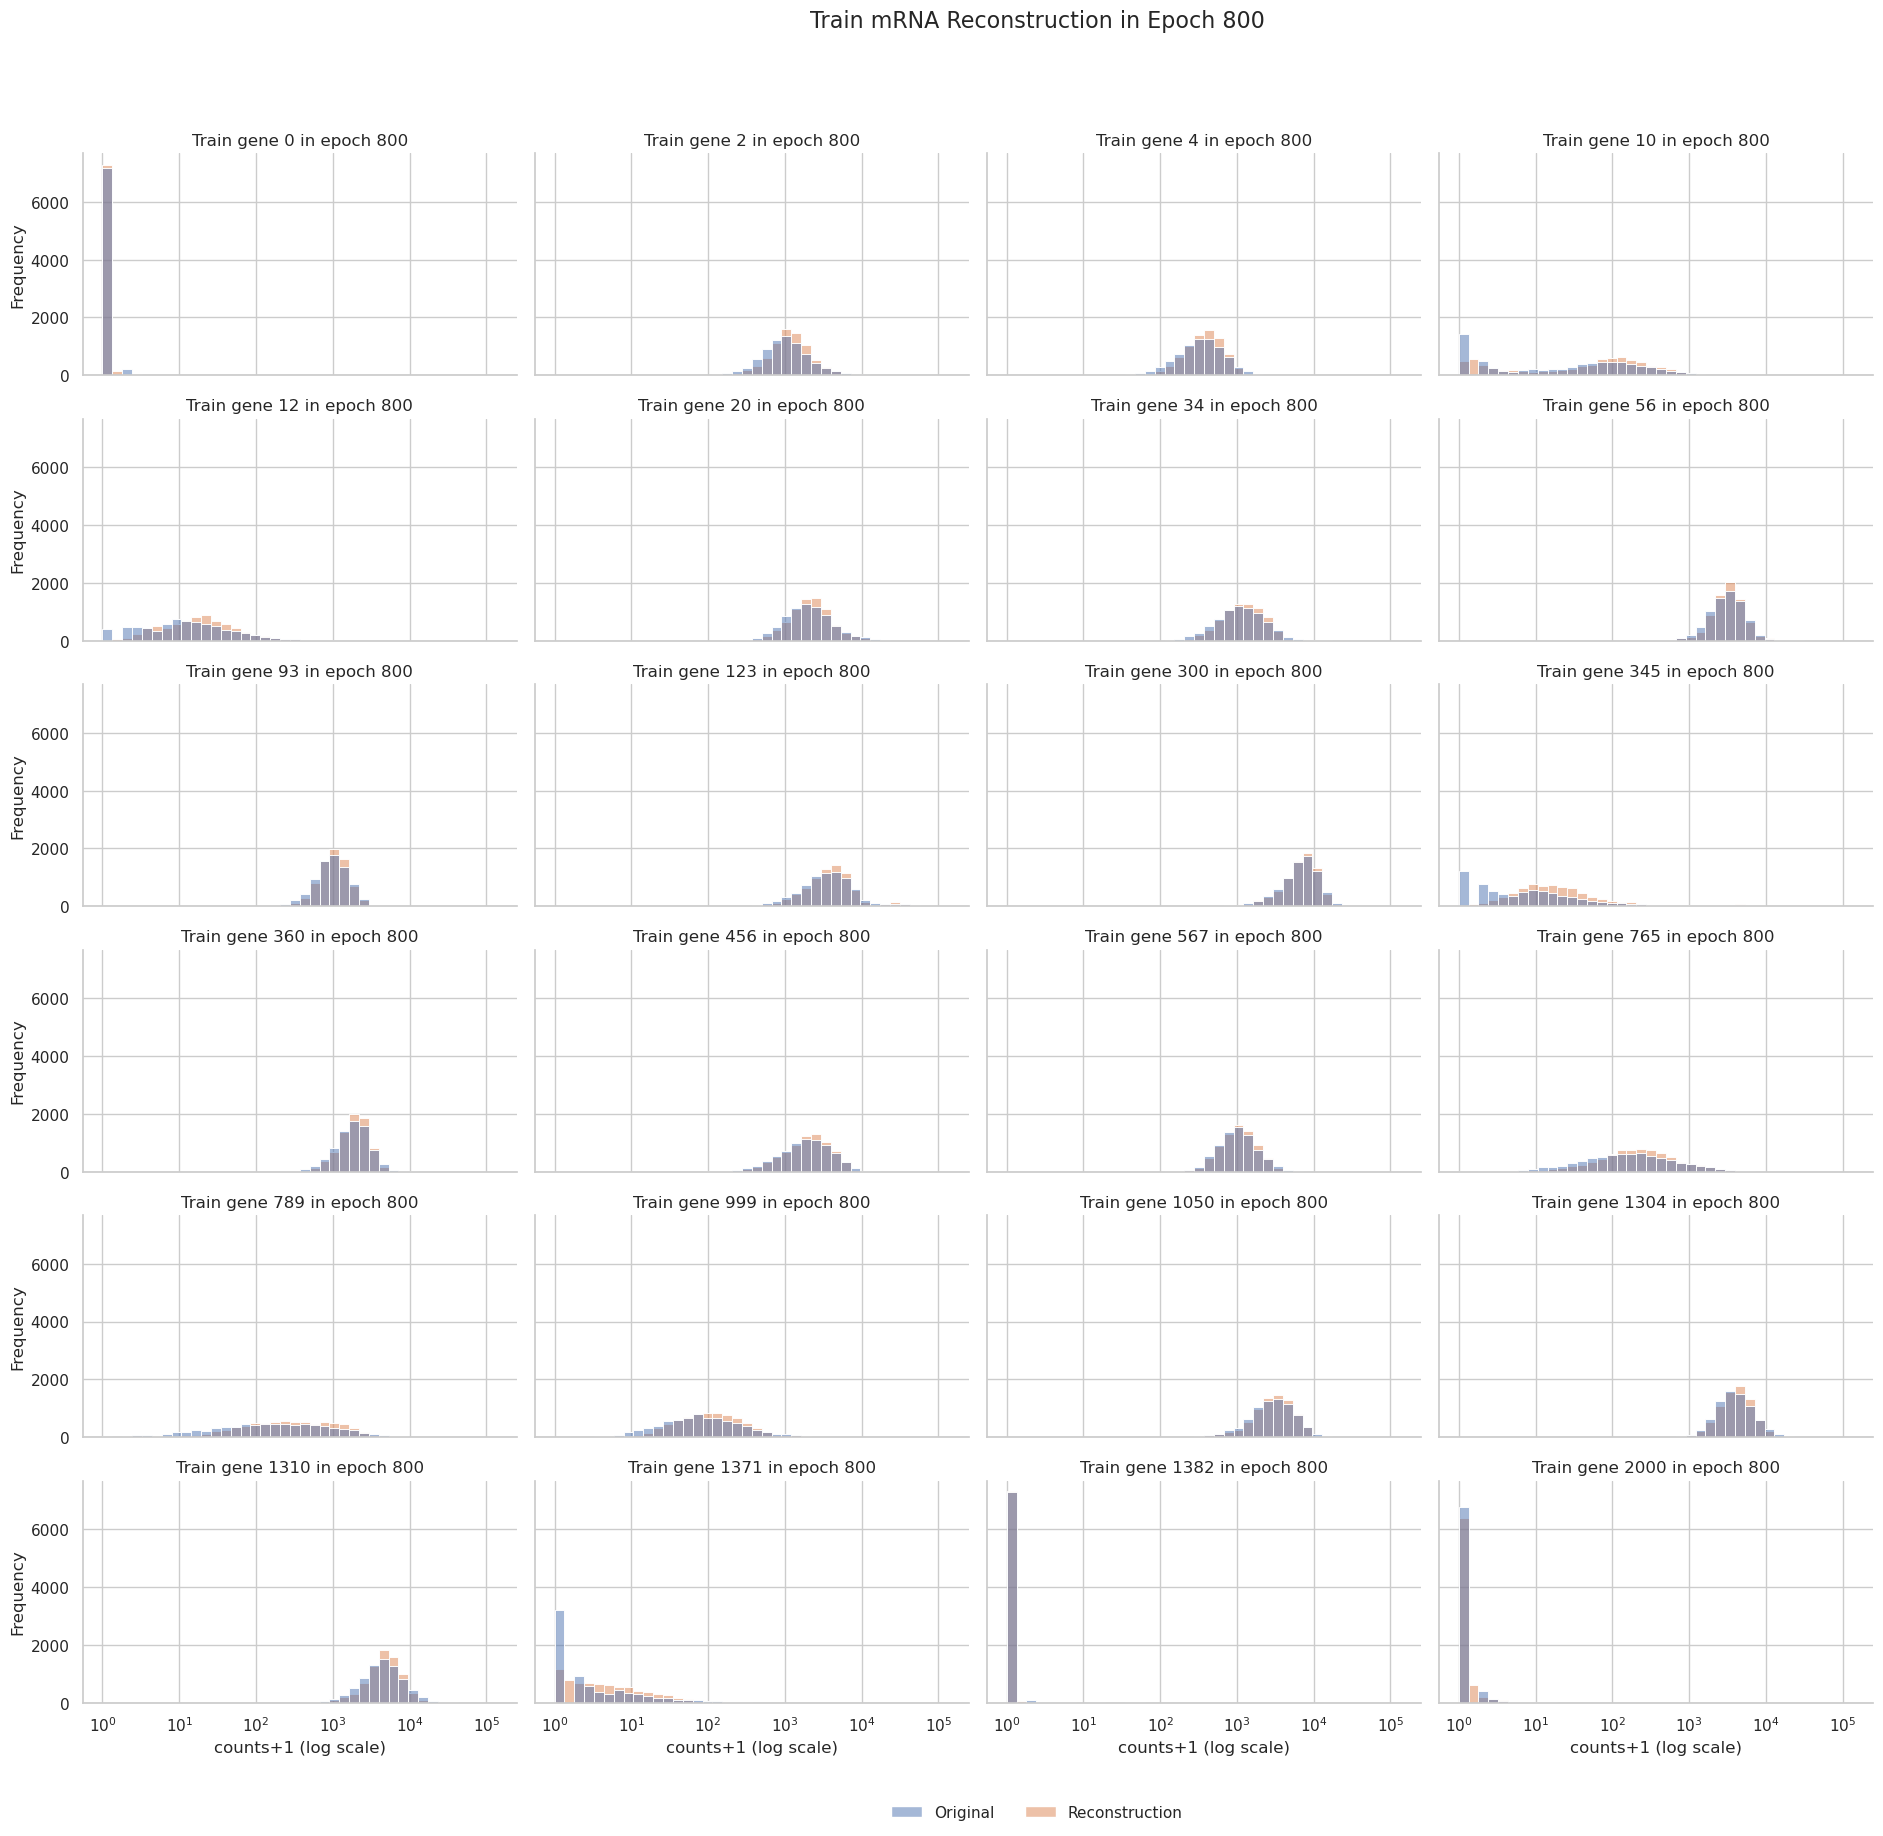

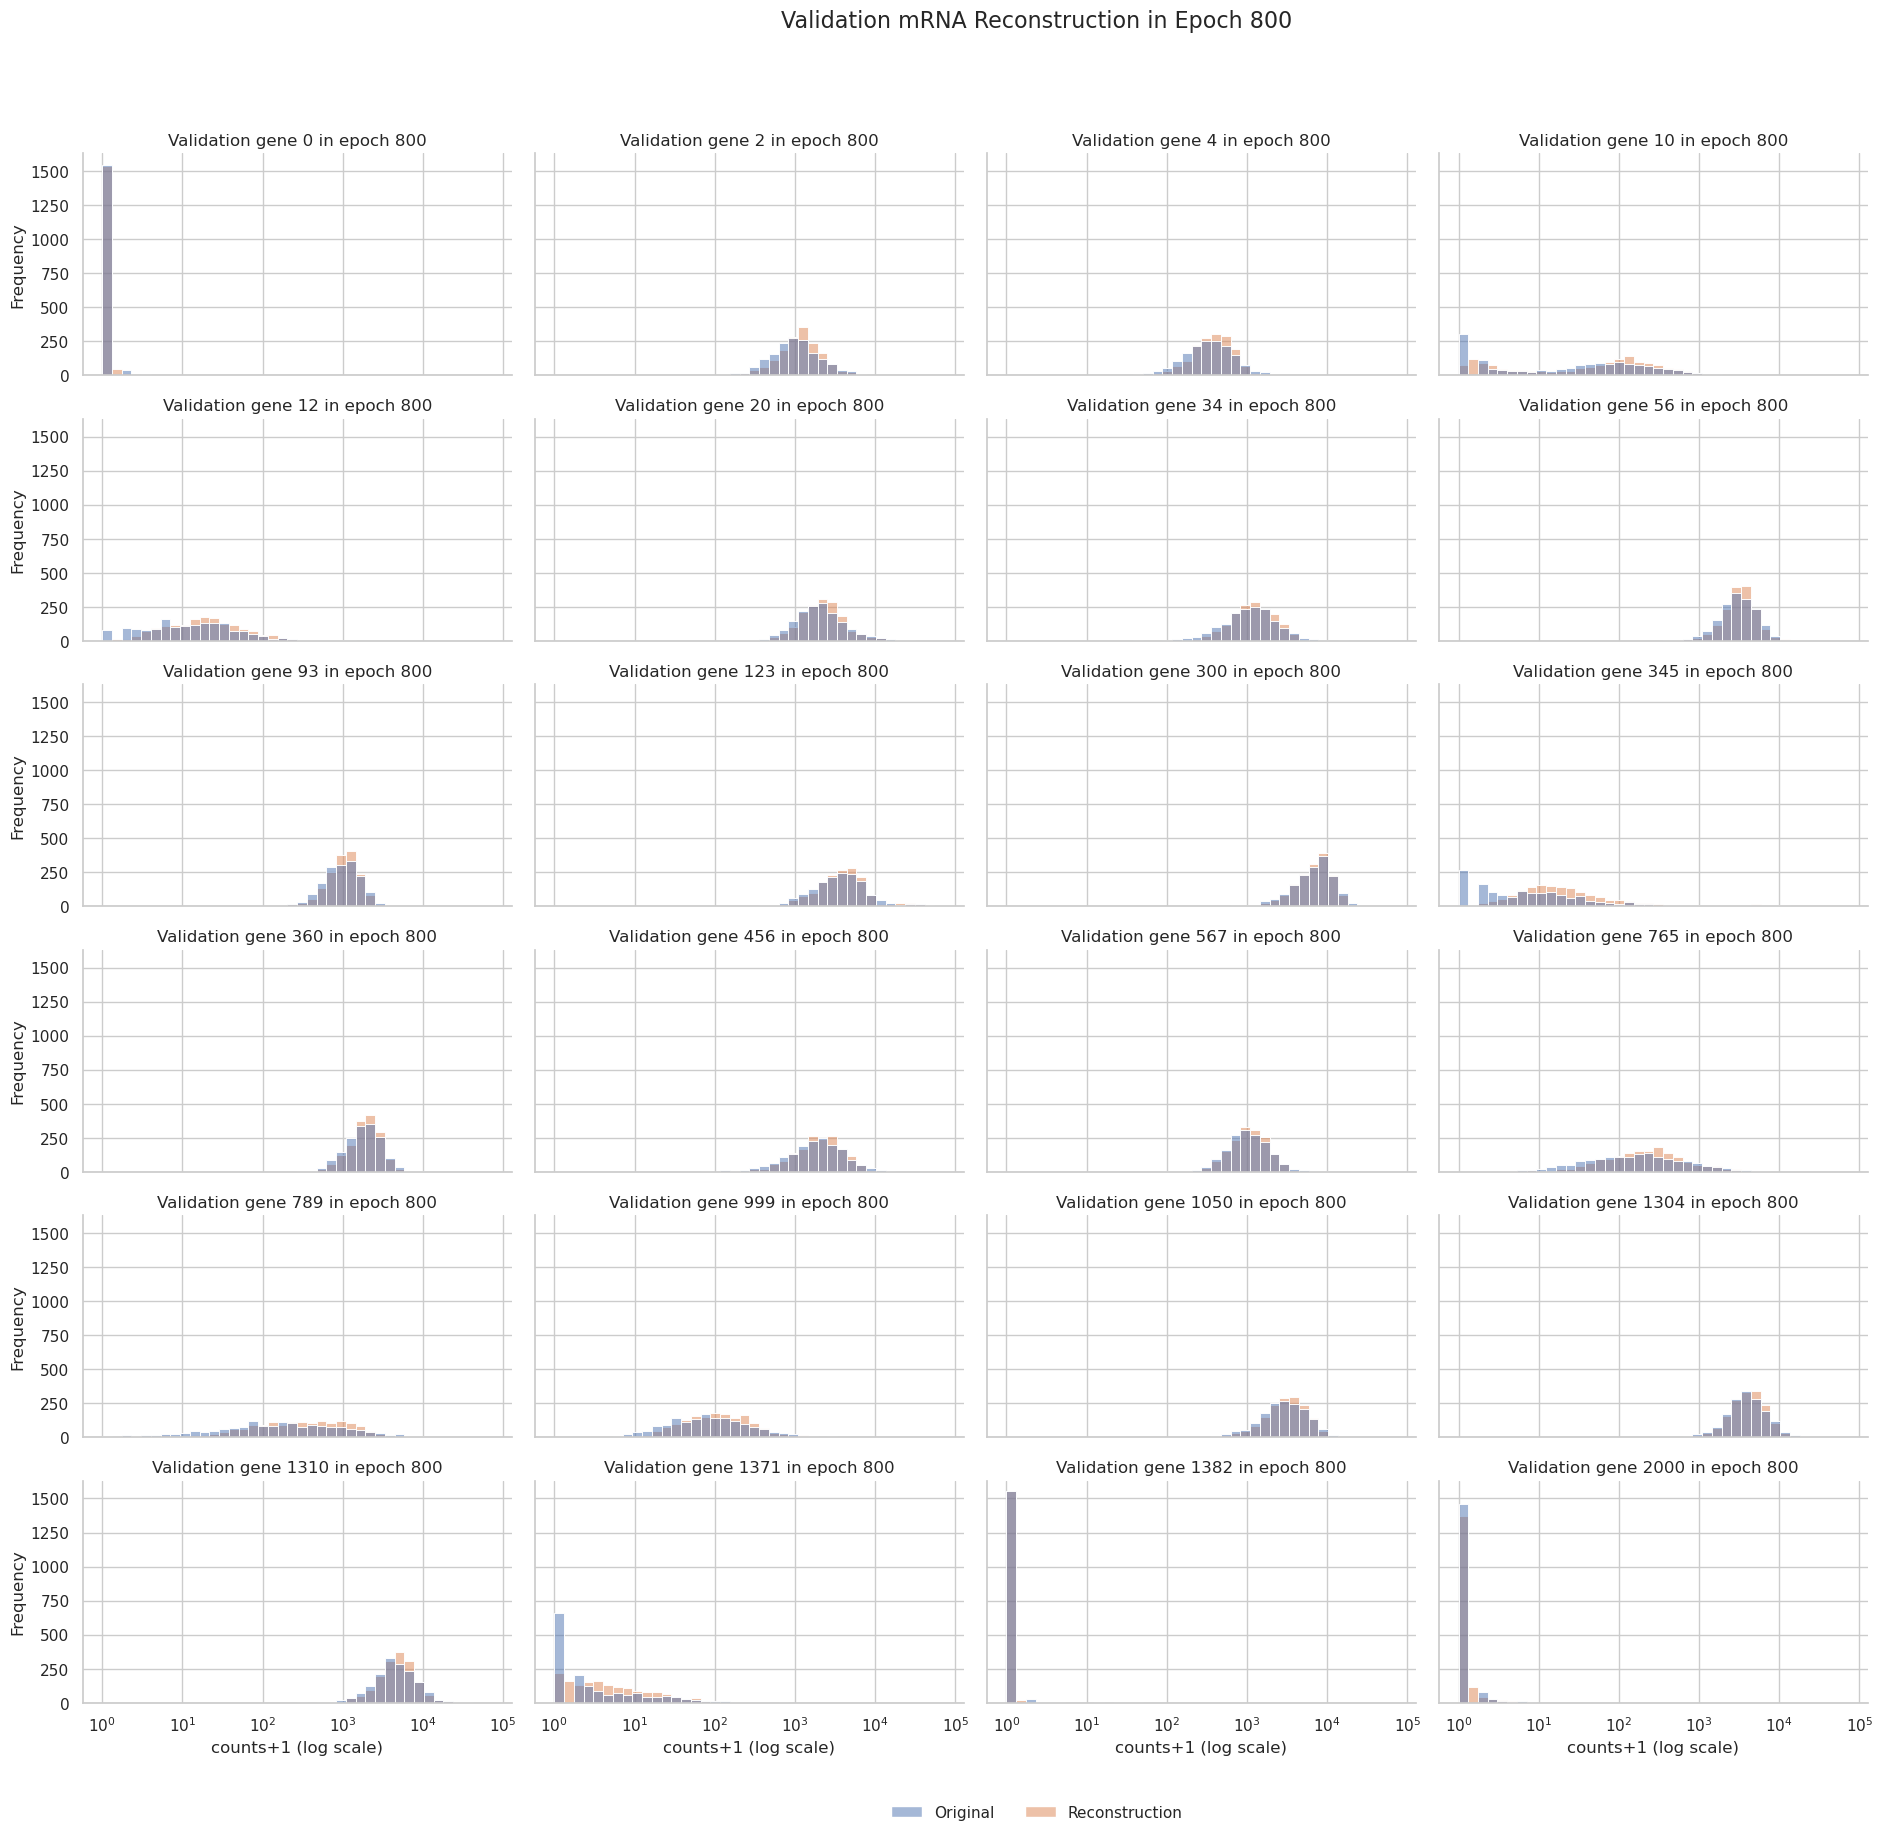

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [1:09:55<00:00,  5.24s/it]


In [20]:
loss_tab = train_midgd_all(
        dgd, train_loader, validation_loader, device,
        learning_rates=learning_rates,
        weight_decay=weight_decay, betas=betas, nepochs=nepochs,
        pr=pr, plot=plot, reduction_type=reduction_type,
        sample_index=sample_index, subset=subset, wandb_log=False
    )

In [21]:
# Set results paths
loss_path = 'results/loss_midgd_all.pickle'
dgd_path = 'results/dgd_midgd_all.pickle'

torch.save(loss_tab, loss_path)
torch.save(dgd, dgd_path)

# Plotting Loss

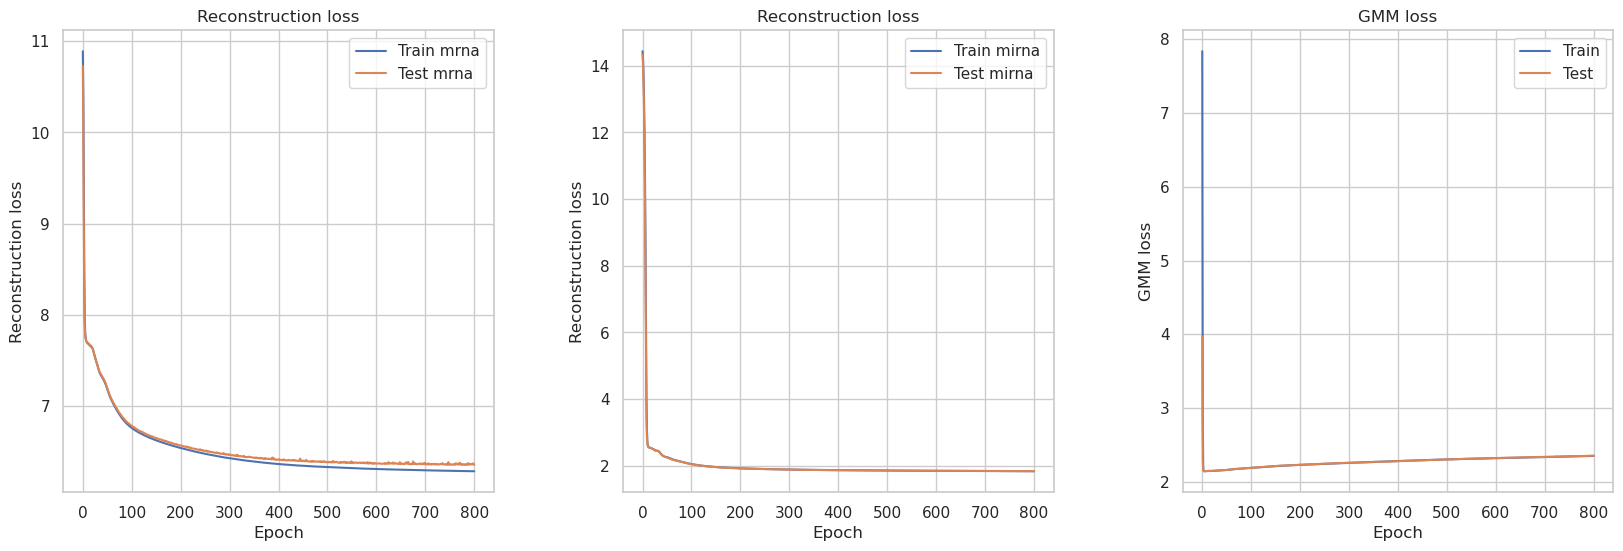

In [22]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(20, 6))
plt.subplots_adjust(wspace=0.3)

# First subplot for Reconstruction loss
plt.subplot(1, 3, 1)
sns.lineplot(x="epoch", y="train_recon_mrna", data=loss_tab, label="Train mrna")
sns.lineplot(x="epoch", y="test_recon_mrna", data=loss_tab, label="Test mrna")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# First subplot for Reconstruction loss
plt.subplot(1, 3, 2)
sns.lineplot(x="epoch", y="train_recon_mirna", data=loss_tab, label="Train mirna")
sns.lineplot(x="epoch", y="test_recon_mirna", data=loss_tab, label="Test mirna")
plt.title("Reconstruction loss")
plt.xlabel("Epoch")
plt.ylabel("Reconstruction loss")

# Second subplot for GMM loss
plt.subplot(1, 3, 3)
sns.lineplot(x="epoch", y="train_gmm", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_gmm", data=loss_tab, label="Test")
plt.title("GMM loss")
plt.xlabel("Epoch")
plt.ylabel("GMM loss")

# Display the plots
plt.show()

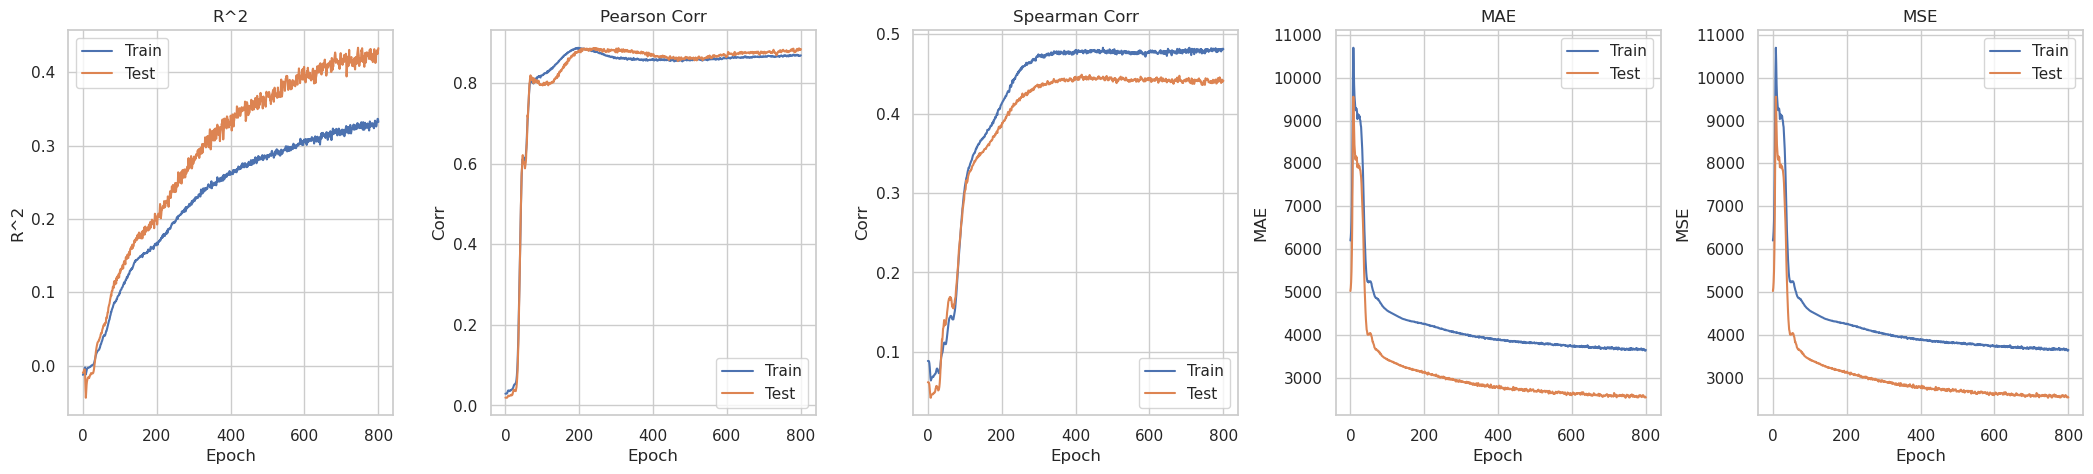

In [23]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(26, 5))
plt.subplots_adjust(wspace=0.3)

# First subplot for R-squared
plt.subplot(1, 5, 1)
sns.lineplot(x="epoch", y="train_r2", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_r2", data=loss_tab, label="Test")
plt.title("R^2")
plt.xlabel("Epoch")
plt.ylabel("R^2")

# Second subplot for Corr
plt.subplot(1, 5, 2)
sns.lineplot(x="epoch", y="train_pearson", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_pearson", data=loss_tab, label="Test")
plt.title("Pearson Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Third subplot for MSE
plt.subplot(1, 5, 3)
sns.lineplot(x="epoch", y="train_spearman", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_spearman", data=loss_tab, label="Test")
plt.title("Spearman Corr")
plt.xlabel("Epoch")
plt.ylabel("Corr")

# Fourth subplot for MAE
plt.subplot(1, 5, 4)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")

# Fourth subplot for MAE
plt.subplot(1, 5, 5)
sns.lineplot(x="epoch", y="train_mae", data=loss_tab, label="Train")
sns.lineplot(x="epoch", y="test_mae", data=loss_tab, label="Test")
plt.title("MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")

# Display the plots
plt.show()

# Simple Analysis

In [94]:
from base.plotting.plot_cv2 import plot_latent_space, plot_mirna
from base.dgd.latent import RepresentationLayer

In [95]:
dgd = torch.load('results/dgd_midgd_all.pickle')

In [96]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=20, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
    )
    (out_module_mirna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=512, bias=True)
        (3): ReLU()
        (4): Linear(in_features=512, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (val_rep): RepresentationLayer()
)

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def reshape_scaling_factor(x, o_dim):
    """
    the scaling factor needs to be of the same dimensionality as the predictions
    which can increase when searching for new representations.

    Given the desired dimensionality (i.e. that of the predictions), the
    scaling factors are extended. The first dimension keeps the number of features.
    """
    start_dim = len(x.shape)
    for _ in range(o_dim - start_dim):
        x = x.unsqueeze(1)
    return x


def prepare_potential_reps(sample_list):
    """
    takes a list of samples drawn from the DGD's distributions.
    The length gives the number of distributions which defines
    the dimensionality of the output tensor.
    If the list of samples is longer than 1, we will create representations
    from the combination of each GMM's samples.
    """
    return sample_list[0]

In [128]:
resampling_type="mean"
n_samples_new = len(test_loader.dataset)

potential_reps = prepare_potential_reps([dgd.gmm.sample_new_points(resampling_type)])

dgd.decoder.eval()
X_mirna, X_mrna = dgd.decoder(potential_reps.to(device))

rep_init_values = torch.zeros((n_samples_new, potential_reps.shape[-1]))

for (mrna_data, mirna_data, lib_mrna, lib_mirna, i) in test_loader.dataset:
    loss = torch.empty(0).to(device)
    for X in X_mrna:
        mrna_recon_loss = dgd.decoder.loss(
            nn_output=X.to(device), 
            target=mrna_data.to(device), 
            scale=lib_mrna, 
            mod_id="mrna", 
            feature_ids=None, 
            reduction="sum", 
            type="midgd"
        )
        loss = torch.cat((loss, mrna_recon_loss.unsqueeze(0)))
    best_fit_ids = torch.argmin(loss, dim=-1).detach().cpu()
    rep_init_values[i, :] = potential_reps.clone()[best_fit_ids, :]

In [129]:
rep_init_values.shape

torch.Size([1602, 20])

In [130]:
from tqdm import tqdm

test_epochs = 50
gmm_loss = True

Ntest=len(test_loader.dataset)
dgd.test_rep = RepresentationLayer(n_rep=dgd.rep_dim, 
                                   n_sample=Ntest,
                                   value_init=rep_init_values).to(device)
test_rep_optimizer = torch.optim.AdamW(dgd.test_rep.parameters(), lr=learning_rates['rep'], weight_decay=weight_decay, betas=betas)

for epoch in tqdm(range(test_epochs)):
    test_rep_optimizer.zero_grad()
    for (mrna_data, mirna_data, lib_mrna, lib_mirna, index) in test_loader:
        mirna_recon_loss, mrna_recon_loss, gmm_loss = dgd.forward_and_loss(
            z=dgd.test_rep(index),
            target=[mirna_data.to(device), mrna_data.to(device)],
            scale=[lib_mirna.unsqueeze(1).to(device), lib_mrna.unsqueeze(1).to(device)], 
            gmm_loss=gmm_loss,
            reduction=reduction_type,
            type="combined"
        )
        loss = mirna_recon_loss + mrna_recon_loss + gmm_loss
        loss.backward()
    test_rep_optimizer.step()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.44s/it]


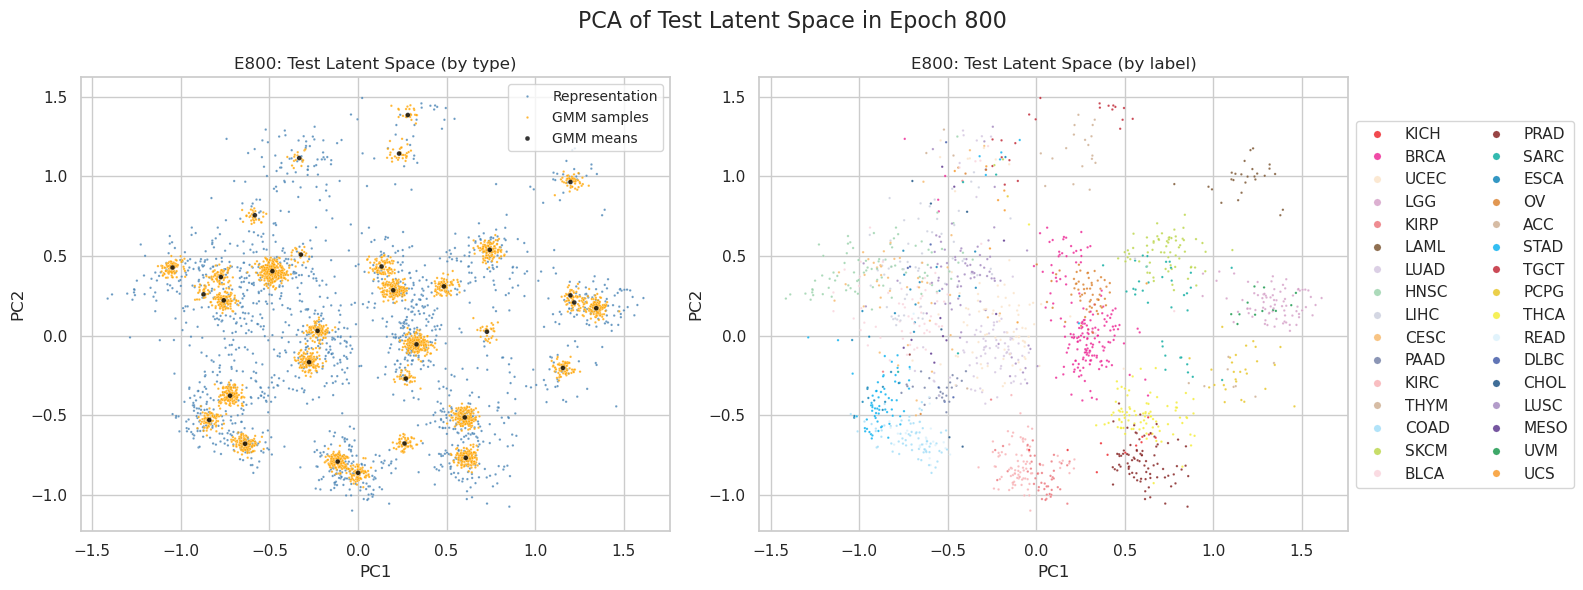

In [131]:
plot_latent_space(*dgd.get_latent_space_values("test",3000), test_loader.dataset.label, color_mapping, epoch=800, dataset="Test")

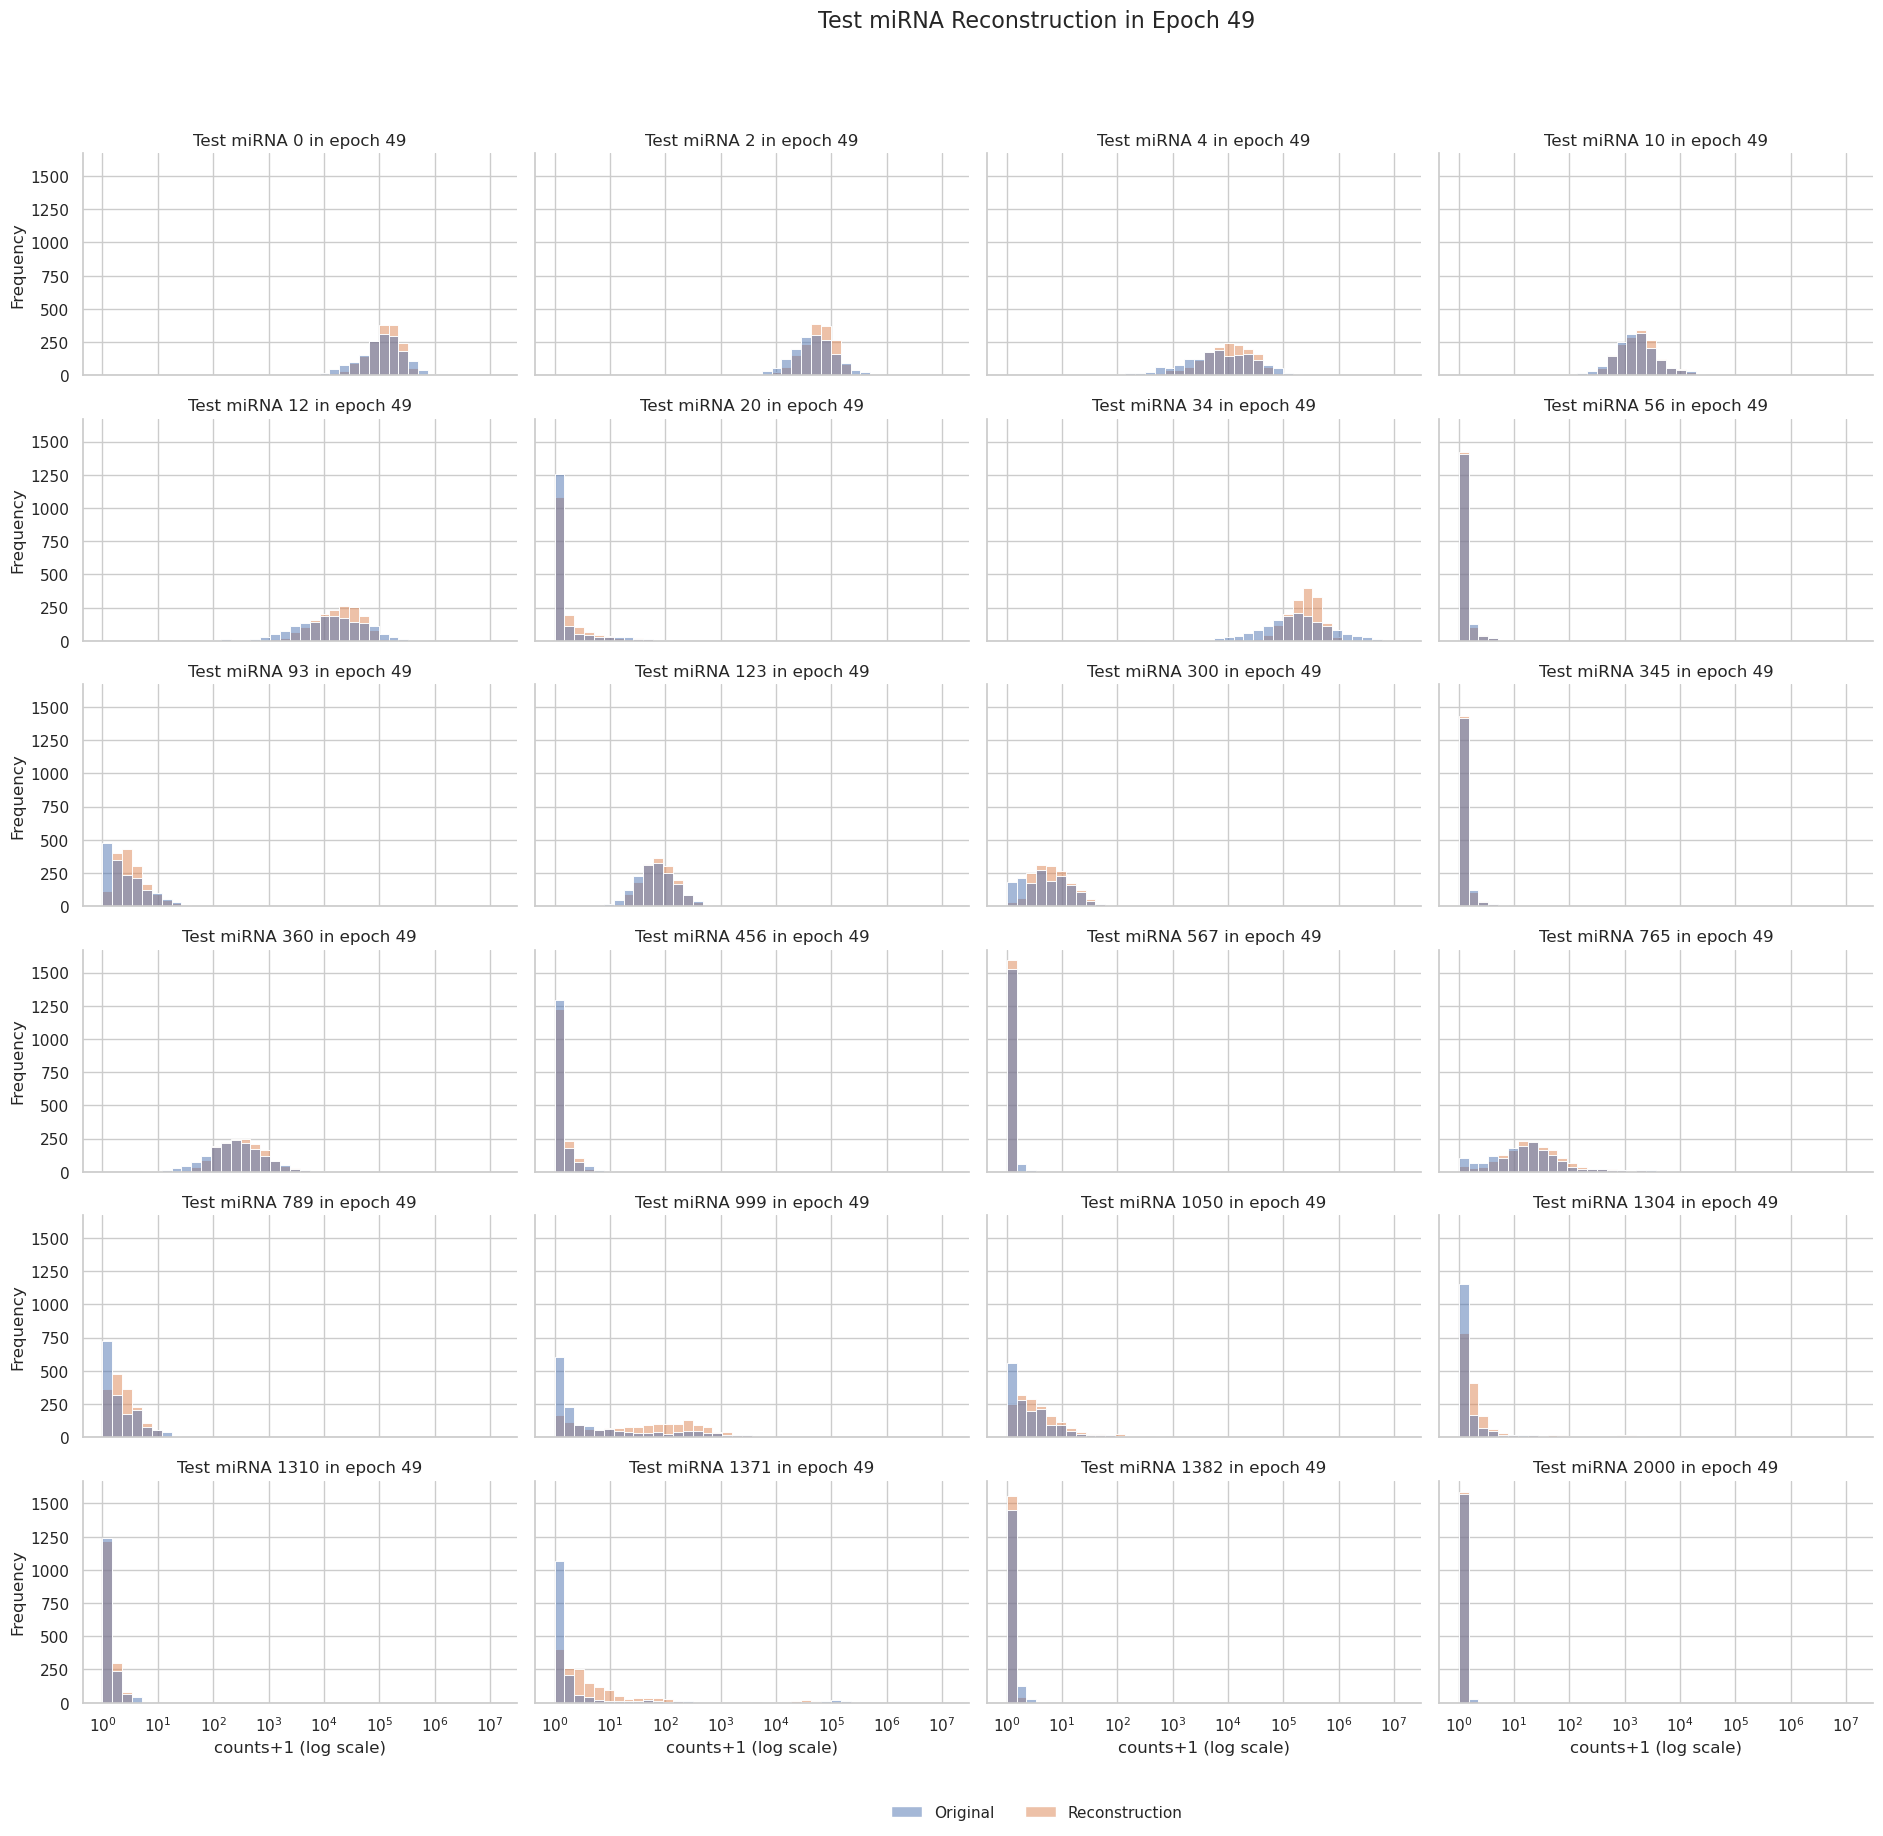

In [132]:
plot_mirna(dgd, test_loader, sample_index, epoch, device, type="Test")

In [133]:
with torch.inference_mode():
    train_scaling = torch.mean(train_loader.dataset.mirna_data, axis=1)
    val_scaling = torch.mean(validation_loader.dataset.mirna_data, axis=1)
    test_scaling = torch.mean(test_loader.dataset.mirna_data, axis=1)
    
    X_train, _ = dgd.forward(dgd.train_rep()) 
    X_train = X_train * train_scaling.unsqueeze(1).to(device)
    y_train = train_loader.dataset.mirna_data
    X_val, _ = dgd.forward(dgd.val_rep()) 
    X_val = X_val * val_scaling.unsqueeze(1).to(device)
    y_val = validation_loader.dataset.mirna_data
    X_test, _ = dgd.forward(dgd.test_rep()) 
    X_test = X_test * test_scaling.unsqueeze(1).to(device)
    y_test = test_loader.dataset.mirna_data

X_train = X_train.detach().cpu()
y_train = y_train.detach().cpu()
X_val = X_val.detach().cpu()
y_val = y_val.detach().cpu()
X_test = X_test.detach().cpu()
y_test = y_test.detach().cpu()

cancer_type = test_loader.dataset.label
color = test_loader.dataset.color
palette = dict(zip(cancer_type, color))

In [135]:
from scipy import stats

mirna_features = test_loader.dataset.mirna_data.shape[1]
spearman_corr = []
pearson_corr = []
spearman_pval = []
pearson_pval = []

for i in range(y_test.shape[1]):
    # Calculate Spearman correlation coefficient
    spearman, spearman_p = stats.spearmanr(X_test[:,i], y_test[:,i])
    pearson, pearson_p = stats.pearsonr(X_test[:,i], y_test[:,i])
    spearman_corr.append(spearman)
    pearson_corr.append(pearson)
    spearman_pval.append(spearman_p)
    pearson_pval.append(spearman_p)
    
corr_data = pd.DataFrame(
    data={
        'spearman': spearman_corr, 
        'pearson': pearson_corr,
        'spearman_p': spearman_pval,
        'pearson_p': pearson_pval,
        'mirna': np.arange(0,mirna_features)
    },
    index=np.arange(0,mirna_features)
)
corr_data

spearman   pearson     spearman_p      pearson_p  mirna
0     0.815975  0.682244   0.000000e+00   0.000000e+00      0
1     0.680304  0.546714  3.686647e-218  3.686647e-218      1
2     0.713134  0.559985  4.194379e-249  4.194379e-249      2
3     0.727894  0.699956  1.742879e-264  1.742879e-264      3
4     0.811420  0.635898   0.000000e+00   0.000000e+00      4
...        ...       ...            ...            ...    ...
2019  0.099268  0.051468   6.892913e-05   6.892913e-05   2019
2020  0.058469  0.170593   1.926357e-02   1.926357e-02   2020
2021  0.069516  0.015172   5.376233e-03   5.376233e-03   2021
2022  0.135159  0.043365   5.620990e-08   5.620990e-08   2022
2023  0.126135  0.163078   4.086962e-07   4.086962e-07   2023

[2024 rows x 5 columns]

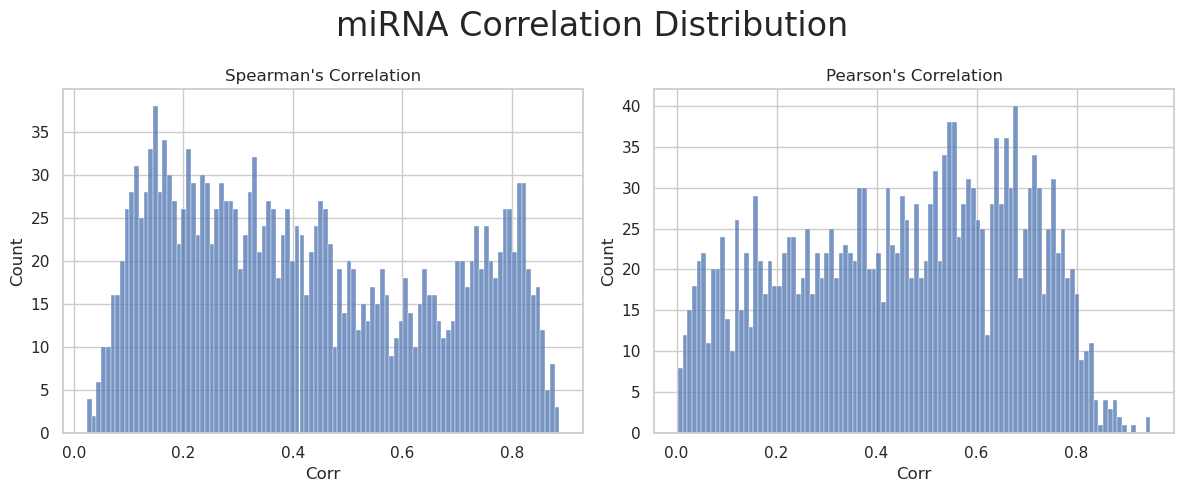

In [136]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.histplot(data=corr_data, x='spearman', bins=100)
plt.title("Spearman's Correlation")
plt.xlabel("Corr")

plt.subplot(1,2,2)
sns.histplot(data=corr_data, x='pearson', bins=100)
plt.title("Pearson's Correlation")
plt.xlabel("Corr")

# Add the main title to the figure
fig.suptitle("miRNA Correlation Distribution", fontsize=24)

# Display the plots
plt.tight_layout()
plt.show()

## miR-122-5p

In [137]:
miR_122_5p_train = pd.DataFrame(
    data={
        'X': X_train[:,1371], 
        'y': y_train[:,1371],
        'cancer_type': train_loader.dataset.label,
        'color': train_loader.dataset.color
    }
)
miR_122_5p_val = pd.DataFrame(
    data={
        'X': X_val[:,1371], 
        'y': y_val[:,1371],
        'cancer_type': validation_loader.dataset.label,
        'color': validation_loader.dataset.color
    }
)
miR_122_5p_test = pd.DataFrame(
    data={
        'X': X_test[:,1371], 
        'y': y_test[:,1371],
        'cancer_type': test_loader.dataset.label,
        'color': test_loader.dataset.color
    }
)

In [ ]:
# Sneaky filtering
# miR_122_5p_test = miR_122_5p_test.drop([533])

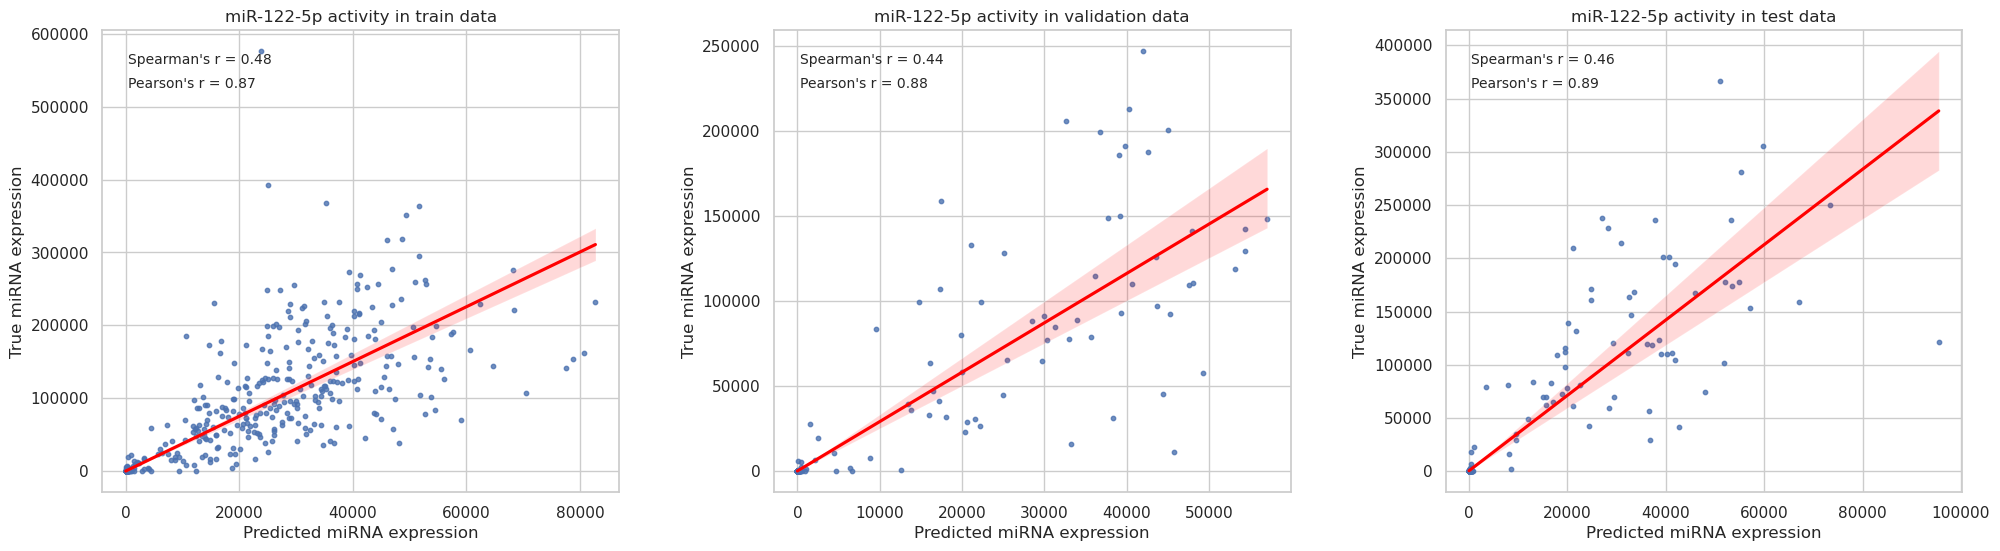

In [138]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# Subplot Train
plt.subplot(1, 3, 1)
# Create scatterplot
sns.regplot(data=miR_122_5p_train, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_122_5p_train['X'], miR_122_5p_train['y'])
pearson_corr, _ = stats.pearsonr(miR_122_5p_train['X'], miR_122_5p_train['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in train data")

# Subplot Train
plt.subplot(1, 3, 2)
# Create scatterplot
sns.regplot(data=miR_122_5p_val, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_122_5p_val['X'], miR_122_5p_val['y'])
pearson_corr, _ = stats.pearsonr(miR_122_5p_val['X'], miR_122_5p_val['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in validation data")

# Subplot Train
plt.subplot(1, 3, 3)
# Create scatterplot
sns.regplot(data=miR_122_5p_test, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_122_5p_test['X'], miR_122_5p_test['y'])
pearson_corr, _ = stats.pearsonr(miR_122_5p_test['X'], miR_122_5p_test['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-122-5p activity in test data")

plt.show()

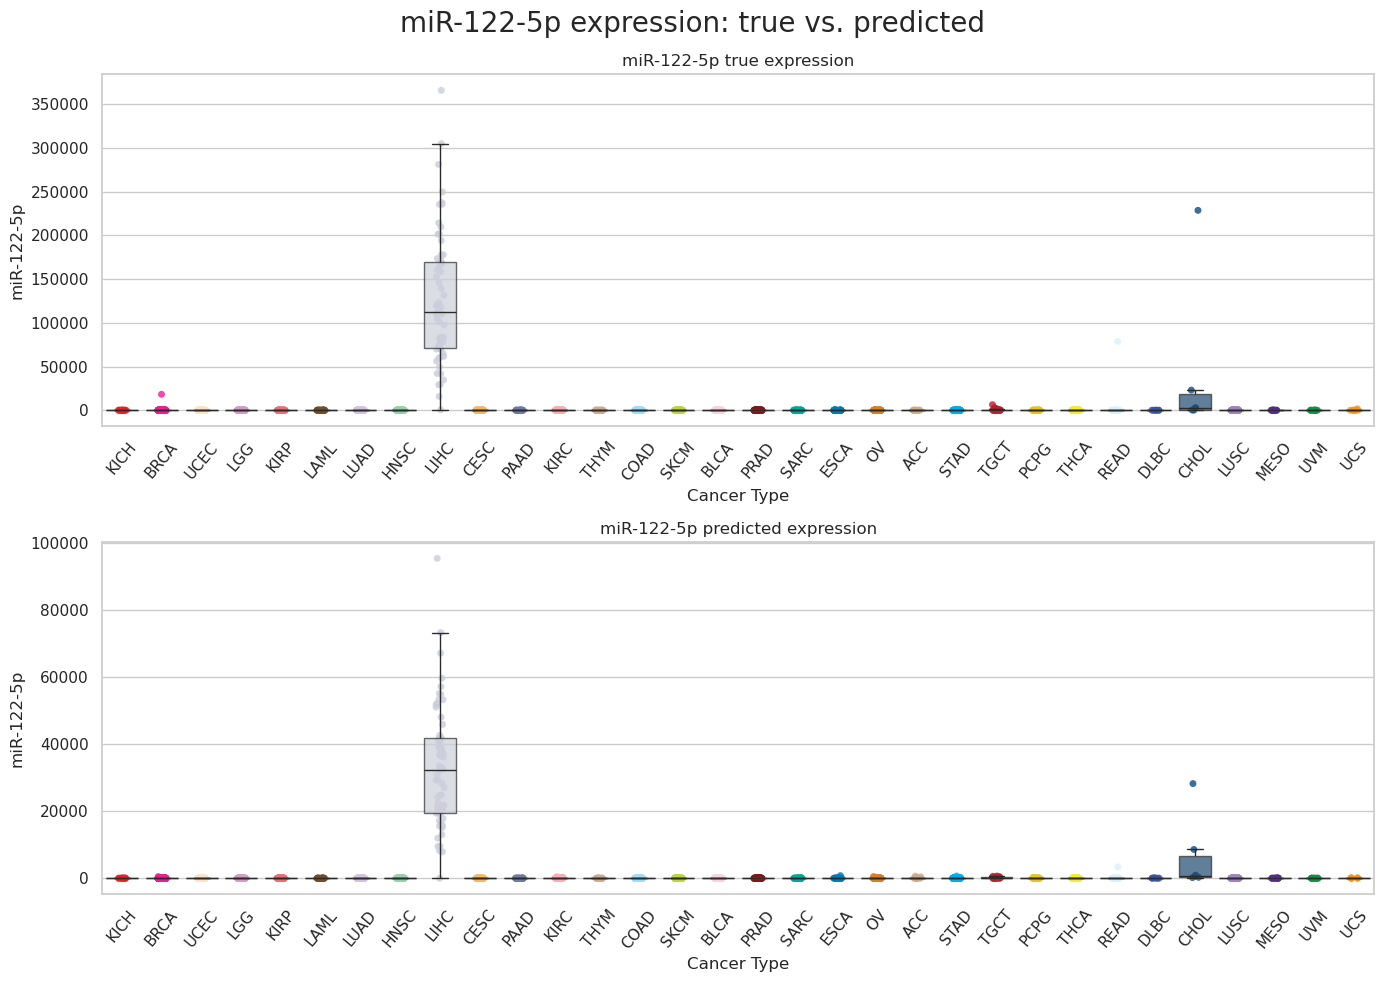

In [139]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_122_5p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.subplot(2, 1, 2)
sns.boxplot(data=miR_122_5p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_122_5p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR-122-5p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR-122-5p")
plt.xticks(rotation=50)

plt.suptitle("miR-122-5p expression: true vs. predicted", fontsize=20)
plt.tight_layout()
plt.show()

## miR-124-3p

In [140]:
miR_124_3p_train = pd.DataFrame(
    data={
        'X': X_train[:,1304], 
        'y': y_train[:,1304],
        'cancer_type': train_loader.dataset.label,
        'color': train_loader.dataset.color
    }
)
miR_124_3p_val = pd.DataFrame(
    data={
        'X': X_val[:,1304], 
        'y': y_val[:,1304],
        'cancer_type': validation_loader.dataset.label,
        'color': validation_loader.dataset.color
    }
)
miR_124_3p_test = pd.DataFrame(
    data={
        'X': X_test[:,1304], 
        'y': y_test[:,1304],
        'cancer_type': test_loader.dataset.label,
        'color': test_loader.dataset.color
    }
)

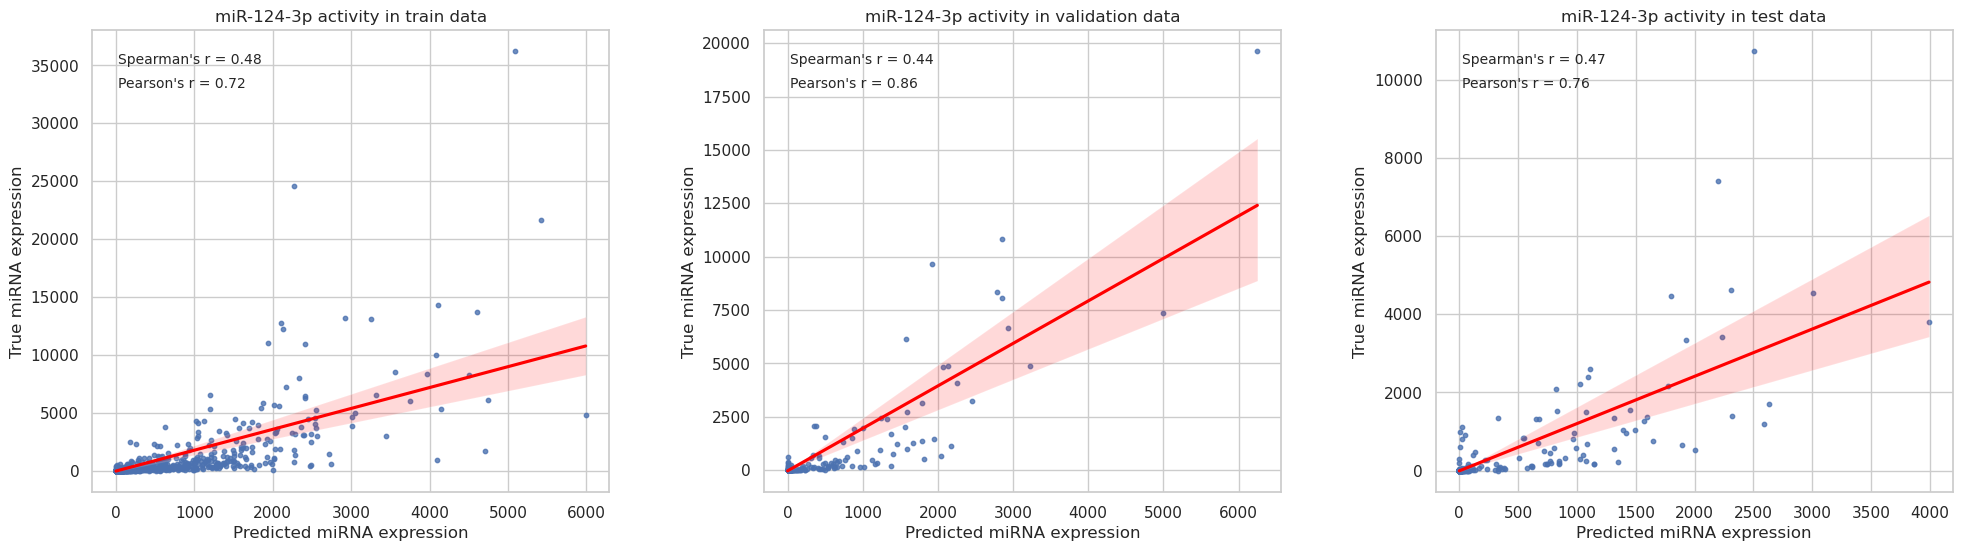

In [144]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create a figure to hold the subplots
plt.figure(figsize=(24, 6))
plt.subplots_adjust(wspace=0.3)

# Subplot Train
plt.subplot(1, 3, 1)
# Create scatterplot
sns.regplot(data=miR_124_3p_train, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_124_3p_train['X'], miR_124_3p_train['y'])
pearson_corr, _ = stats.pearsonr(miR_124_3p_train['X'], miR_124_3p_train['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-124-3p activity in train data")

# Subplot Train
plt.subplot(1, 3, 2)
# Create scatterplot
sns.regplot(data=miR_124_3p_val, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_124_3p_val['X'], miR_124_3p_val['y'])
pearson_corr, _ = stats.pearsonr(miR_124_3p_val['X'], miR_124_3p_val['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-124-3p activity in validation data")

# Subplot Train
plt.subplot(1, 3, 3)
# Create scatterplot
sns.regplot(data=miR_124_3p_test, x="X", y="y", scatter_kws={"s": 10}, line_kws={"color": "red"})
# Calculate Spearman correlation coefficient
spearman_corr, _ = stats.spearmanr(miR_124_3p_test['X'], miR_124_3p_test['y'])
pearson_corr, _ = stats.pearsonr(miR_124_3p_test['X'], miR_124_3p_test['y'])
# Add correlation coefficient as text annotation
plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.xlabel("Predicted miRNA expression")
plt.ylabel("True miRNA expression")
plt.title("miR-124-3p activity in test data")

plt.show()

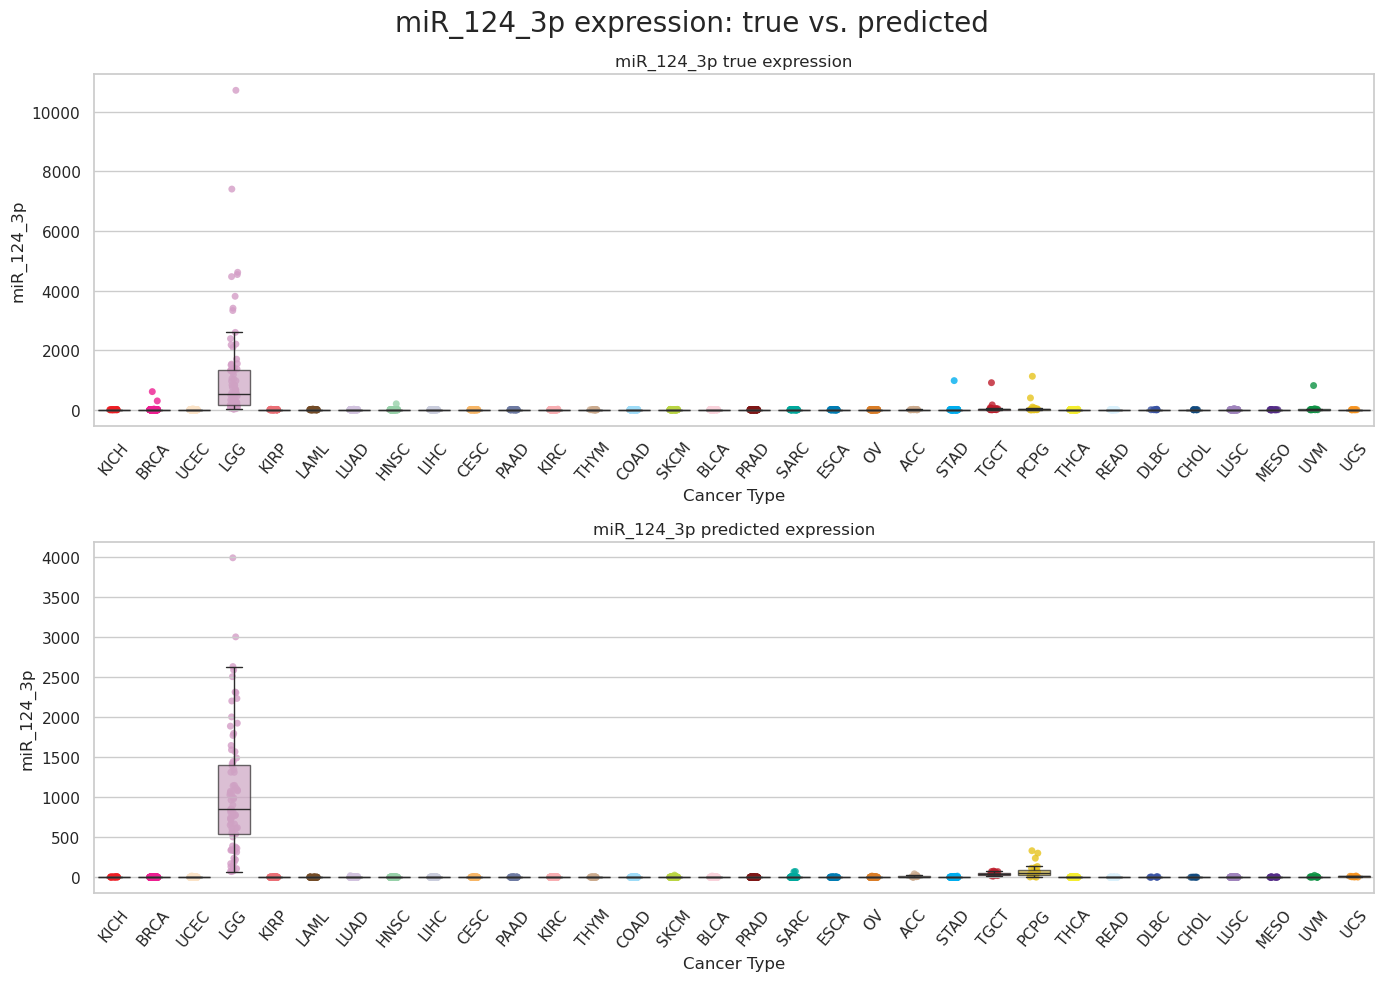

In [142]:
sns.set_style("whitegrid")
plt.figure(figsize=(14, 10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2, 1, 1)
sns.boxplot(data=miR_124_3p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, boxprops=dict(alpha=.7), showfliers=False)
sns.stripplot(data=miR_124_3p_test, x="cancer_type", y="y", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p true expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)


plt.subplot(2, 1, 2)
sns.boxplot(data=miR_124_3p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, boxprops=dict(alpha=0.7), showfliers=False)
sns.stripplot(data=miR_124_3p_test, x="cancer_type", y="X", hue="cancer_type", palette=palette, alpha=0.8, zorder=0)
plt.title("miR_124_3p predicted expression")
plt.xlabel("Cancer Type")
plt.ylabel("miR_124_3p")
plt.xticks(rotation=50)

plt.suptitle("miR_124_3p expression: true vs. predicted", fontsize=20)
plt.tight_layout()

plt.show()